<img src="https://www.ie.edu/IE/site/php/css/new/icons/svg/logo.svg" style="float: left; margin: 15px; height: 80px">


# Web Scraping for spainhouses.net and Predicting housing sales prices

We will be scraping from SpainHouses.net using BeautifulSoup. 

First, look at the source of an SpainHouses.net page: (https://www.spainhouses.net/en/sale-properties-madrid-madrid.html).

Notice, each house listing is underneath a `div` tag with a class name of `_details`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)


In [137]:
URL = "https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html#!page=4"

### Import Area

In [3]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm 
import numpy as np
import patsy

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import  linear_model
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV


import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### code preparation

In [139]:
## YOUR CODE HERE
# query search is q
r=requests.get(URL)
r.url

'https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html#!page=4'

In [140]:
html=r.text

In [702]:
html[:2000]

'<!DOCTYPE html><html lang="en"><head><title>Properties in Área Metropolitana de Madrid - SpainHouses.net</title><meta name="description" content="641 ads of Properties for sale in Área Metropolitana de Madrid from owners and real-estates agencies. Find and buy your property in Área Metropolitana de Madrid."><meta name="keywords" content="Properties, property, área metropolitana de madrid, madrid, for sale, buy, buy"><meta charset="UTF-8"><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><meta name="viewport" content="width=device-width,initial-scale=1.0"><meta name="robots" content="index,follow,NOODP,NOYDIR"><link rel="shortcut icon" href="https://alt.spainhouses.net/favicon.png" type="image/x-icon"><meta property="og:url" content="https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html"><meta property="og:image" content="https://static.spainhouses.net/images/spainhouses.png"><meta property="og:image:width" content="1600"><meta propert

In [142]:
soup = BeautifulSoup(html, 'html.parser')

In [704]:
print(soup.prettify()[:3000])

<!DOCTYPE html>
<html lang="en">
 <head>
  <title>
   Properties in Área Metropolitana de Madrid - SpainHouses.net
  </title>
  <meta content="641 ads of Properties for sale in Área Metropolitana de Madrid from owners and real-estates agencies. Find and buy your property in Área Metropolitana de Madrid." name="description"/>
  <meta content="Properties, property, área metropolitana de madrid, madrid, for sale, buy, buy" name="keywords"/>
  <meta charset="utf-8"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="width=device-width,initial-scale=1.0" name="viewport"/>
  <meta content="index,follow,NOODP,NOYDIR" name="robots"/>
  <link href="https://alt.spainhouses.net/favicon.png" rel="shortcut icon" type="image/x-icon"/>
  <meta content="https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html" property="og:url"/>
  <meta content="https://static.spainhouses.net/images/spainhouses.png" property="og:image"/>
  <meta con

In [144]:
soup.title

<title>Properties in Área Metropolitana de Madrid - SpainHouses.net</title>

In [145]:
soup.title.text

'Properties in Área Metropolitana de Madrid - SpainHouses.net'

In [146]:
soup.title.string

'Properties in Área Metropolitana de Madrid - SpainHouses.net'

In [147]:
soup.h1

<h1 class="title_1 sys_mainListName">Properties in <b class="locationSelector" id="locationSelector">Área Metropolitana de Madrid</b></h1>

In [708]:
houses_container=soup.find_all('div',{ 'class' : "details"})
houses_container[:3]

[<div class="details"><div class="upper"><div class="tool compact"><span class="alertButton alertProperty alertOff" data-id="3177108" style="" title="Price alert"></span><span class="alertButton alertProperty alertOn" data-id="3177108" style="display:none" title="Price alert"></span></div><div class="priceDiv"><div class="mainPrice"><span class="price">120,000</span> €</div><div class="second_price">1,967 €/<abbr title="Square metres">m<sup>2</sup></abbr></div></div><div class="title_1"><a data-position="1" href="https://www.spainhouses.net/en/flat-sale-alcorcon-madrid-3177108.html" title="Flat for sale in Alcorcón - QZU-92026-3">Flat in Alcorcón</a></div><span class="titleTail"></span><div class="title_2">Zona Sur<span class="locationLinks"></span></div><div class="features"><b>61 <abbr title="Square metres">m<sup>2</sup></abbr></b> | <b>2 bedrooms</b> | <b>1 bathroom</b> </div><div class="descTxt">This newly painted house is a great opportunity to live between two urban centers, Alco

#### ---

Let's look at one result more closely. A single `result` looks like

```
[<div class="details"><div class="upper"><div class="tool compact"><span class="alertButton alertProperty alertOff" data-id="3110288" style="" title="Price alert"></span><span class="alertButton alertProperty alertOn" data-id="3110288" style="display:none" title="Price alert"></span></div><div class="priceDiv"><div class="mainPrice"><span class="price">750,000</span> €</div><div class="second_price">1,875 €/<abbr title="Square metres">m<sup>2</sup></abbr></div></div><div class="title_1"><a data-position="1" href="https://www.spainhouses.net/en/building-sale-madrid-madrid-3110288.html" title="Building for sale in Bellas Vistas - FRANCISCO SALAS">Building in Bellas Vistas</a></div><span class="titleTail"></span><div class="title_2"><span class="locationLinks"></span></div><div class="features"><b>4 floors</b> | <b>400 <abbr title="Square metres">m<sup>2</sup></abbr></b> | <b>Plot: 165 <abbr title="Square metres">m<sup>2</sup></abbr></b> | <b>9 bedrooms</b> | <b>5 bathrooms</b> | <span>Furnished</span> | <span>Parking places</span> </div><div class="enterpriseLogoContainer"><a href="https://www.spainhouses.net/en/realestate-venza-solucion.html"><img alt="Venza Solución" data-image="//static.spainhouses.net/logos/venza-solucion-784.jpg" src="//static.spainhouses.net/imas/pix.gif" title="Venza Solución"/></a></div><div class="descTxt">Discard  Residential building for sale in Francisco Salas street, 20 Bellas Vistas, Madrid View map 700,000 x 900,000 x 22% 404 m2 1,733 eur/m2  Remove Discard Write a personal note (only you will be able to see it) Advertiser comment Available in: Spanish Other languages  'The building is built on a plot of 165 m2 and is a quadrilateral of 8 meters of front age by 20 in the background, in the first 10 meters is built a building of 4 floors whose date of construction is 1970 and consists of ground floor or local floor of 5 meters high with which you can take out two houses in height and then the first avocado with housing and in the second another house both of three bedrooms with bathroom one of them with air conditioning; in the 10 meters back and bottom there is another construction of two heights with two houses built in 1943 in ruined state and not inhabited for more than 30 years, the two buildings are to reform although the first one is habitable.'</div> </div><div class="lowRow"><div class="property-phone"><a class="phone" data-id="3110288" data-type="property" data-zone="list" href="tel:+34 644339621">
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The prices is available in a `price` element inside of a `div` element with `class='details'`.
- The features of a house is in a link with class set to `features`.  
- The house_title is set in a `div` with `class='title_1'`. 
- The house description or details is set in a `div` with `class='descTxt'`. 

### now we are going to write 4 functions to extract each item: ***house description, features, house_title***, and sale price.

Example: 
```python
for result in first_house.find_all('span', class_='price'):
    print(result.text)
```


- **we need to make Make sure these functions are robust and can handle cases where the data/field may not be available.**
   <br> Restrictions been done
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.

In [149]:
##jobs_container = soup.find_all('div', class_ = 'result')
print(type(houses_container))
print(len(houses_container))

<class 'bs4.element.ResultSet'>
24


In [43]:
first_house = houses_container[1]
first_house

<div class="details"><div class="upper"><div class="tool compact"><span class="alertButton alertProperty alertOff" data-id="3085350" style="" title="Price alert"></span><span class="alertButton alertProperty alertOn" data-id="3085350" style="display:none" title="Price alert"></span></div><div class="priceDiv"><span class="loweredArrow" title="Reduced, precio anterior: 850,000 €"> <span>(5%)</span> </span><div class="mainPrice"><span class="price">810,000</span> €</div><div class="second_price">1,705 €/<abbr title="Square metres">m<sup>2</sup></abbr></div></div><div class="title_1"><a data-position="2" href="https://www.spainhouses.net/en/building-sale-madrid-madrid-3085350.html" title="Building for sale in Bellas Vistas - Edificio">Building in Bellas Vistas</a></div><span class="titleTail"></span><div class="title_2"><span class="locationLinks"></span></div><div class="features"><b>3 floors</b> | <b>475 <abbr title="Square metres">m<sup>2</sup></abbr></b> | <b>7 bedrooms</b> | <b>3 bat

In [44]:
for result in first_house.find_all('span', class_='price'):
    print(result.text)

810,000


In [45]:
for result in first_house.find_all('div', class_='features'):
    print(result.text)

3 floors | 475 m2 | 7 bedrooms | 3 bathrooms | Furnished | Parking places | Gardens 


In [46]:
for result in first_house.find_all('div', class_='descTxt'):
    print(result.text)

Great office building for sale with the possibility of making it homes 2 floors of homes, ground floor storage room and storage room and upper floor duplex penthouses or also to make coworking type.


In [47]:
for result in first_house.find_all('div', class_='title_1'):
    print(result.text)

Building in Bellas Vistas


#### In the below function we are going to extract all description been extracted in  the result variable

In [48]:
# Extracting description
def extract_houses_descTxt_from_result(house_descTxt):
    descTxt = []
    for container in house_descTxt:
        for result in container.find_all('div', class_='descTxt'):
            descTxt.append(result.text)
    return(descTxt)

houses_descTxt = []
houses_descTxt = extract_houses_descTxt_from_result(houses_container)
houses_descTxt[:5]

["Discard  Residential building for sale in Francisco Salas street, 20 Bellas Vistas, Madrid View map 700,000 x 900,000 x 22% 404 m2 1,733 eur/m2  Remove Discard Write a personal note (only you will be able to see it) Advertiser comment Available in: Spanish Other languages  'The building is built on a plot of 165 m2 and is a quadrilateral of 8 meters of front age by 20 in the background, in the first 10 meters is built a building of 4 floors whose date of construction is 1970 and consists of ground floor or local floor of 5 meters high with which you can take out two houses in height and then the first avocado with housing and in the second another house both of three bedrooms with bathroom one of them with air conditioning; in the 10 meters back and bottom there is another construction of two heights with two houses built in 1943 in ruined state and not inhabited for more than 30 years, the two buildings are to reform although the first one is habitable.'",
 'Great office building fo

#### As well, In the below function we are going to extract all house features been extracted in  the result variable

In [49]:
## Extracting features
def extract_house_features_from_result(house_features):
    features=[]
    for container in house_features:
        for result in container.find_all('div', class_='features'):
            features.append(result.text)
    return(features)

house_features=[]        
house_features = extract_house_features_from_result(houses_container)
house_features[:5]

['4 floors | 400 m2 | Plot: 165 m2 | 9 bedrooms | 5 bathrooms | Furnished | Parking places ',
 '3 floors | 475 m2 | 7 bedrooms | 3 bathrooms | Furnished | Parking places | Gardens ',
 'Plot: 839 m2 | Parking places ',
 '82 m2 | 3 bedrooms | 1 bathroom ',
 'Detached | 4 floors | 510 m2 | Plot: 296 m2 | 8 bedrooms | 6 bathrooms | Gardens ']

#### In the below function we are going to extract all house title been extracted in  the result variable

In [50]:
# Extracting Titles
def extract_house_title_from_result(house_title):
    title = []
    for container in house_title:
        for result in container.find_all('div', class_='title_1'):
            title.append(result.text)
    return(title)


house_titles = []
house_titles = extract_house_title_from_result(houses_container)
house_titles[:5]

['Building in Bellas Vistas',
 'Building in Bellas Vistas',
 'Garage in Sol',
 'Flat in Chamberí',
 'Chalet in El Viso']

#### In the below function we are going to extract all prices been extracted in  the result variable

In [51]:
# Extracting sales prices
def extract_house_price_from_result(house_price):
    price = []
    for container in house_price:
        if container.find('span', class_='price') is not None:
            for result in container.find_all('span', class_='price'):
                price.append(result.text)
        else:
            price.append('NA')
    return(price)
    
prices = []
prices = extract_house_price_from_result(houses_container)
prices[:5]

['750,000', '810,000', '1,100,000', '490,000', '3,100,000']

##### Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.


In [79]:
URL_Madrid='https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html#!page=4' #28
URL_barca='https://www.spainhouses.net/en/sale-properties-barcelona.html' #134
URL_valencia='https://www.spainhouses.net/en/sale-properties-valencia.html' #134
URL_malaga='https://www.spainhouses.net/en/sale-properties-malaga.html' #134

##### In the below function we are going to combine all the above function in only one function that will be combining all data in only one dataframe

In [80]:
# the big picture (Compining all functions together and return our data frame)

def return_houses_dataframe(_url, _max_res=100):
    # defining variables
    _houses_descTxt = []
    _house_titles = []
    _house_features = []
    _prices = []
    data = {}
    appended_data = pd.DataFrame()
    #/#
    data = pd.DataFrame([])
    for start in range(0, _max_res):
        url_temp = '';
        url_temp = _url        
        print(start)
        if start > 0 : 
            url_temp = url_temp+"#!page="+str(start)
        else:
            url_temp = url_temp
        print(url_temp)
        _r = requests.get(url_temp)
        print(_r)
        _html = _r.text
        print(_html[:200])
        _soup = BeautifulSoup(_html, 'html.parser')
        _houses_container = _soup.find_all('div',{ 'class' : "details"})
        _houses_descTxt = extract_houses_descTxt_from_result(_houses_container)
        _house_titles = extract_house_title_from_result(_houses_container)
        _house_features = extract_house_features_from_result(_houses_container)
        _prices = extract_house_price_from_result(_houses_container)
        print(_prices[:5])
        data = data.append(pd.DataFrame({'title': _house_titles,
                                         'descTxt': _houses_descTxt,
                                         'features': _house_features,
                                         'price': _prices,
                                         'URL' :url_temp}),ignore_index=True)
    return(data)





### Calling the combined function to get all data together per link related to the city we are investigating

In [81]:
my_df_houses_madrid=return_houses_dataframe(URL_Madrid,28)
my_df_houses_barca=return_houses_dataframe(URL_barca,134)
my_df_houses_valencia=return_houses_dataframe(URL_valencia,129)
my_df_houses_malaga=return_houses_dataframe(URL_malaga,1232)




0
https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html#!page=4
<Response [200]>
<!DOCTYPE html><html lang="en"><head><title>Properties in Área Metropolitana de Madrid - SpainHouses.net</title><meta name="description" content="649 ads of Properties for sale in Área Metropolitana d
['265,000', '349,000', '50,000', '329,000', '400,000']
1
https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html#!page=4#!page=1
<Response [200]>
<!DOCTYPE html><html lang="en"><head><title>Properties in Área Metropolitana de Madrid - SpainHouses.net</title><meta name="description" content="649 ads of Properties for sale in Área Metropolitana d
['265,000', '349,000', '50,000', '329,000', '400,000']
2
https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html#!page=4#!page=2
<Response [200]>
<!DOCTYPE html><html lang="en"><head><title>Properties in Área Metropolitana de Madrid - SpainHouses.net</title><meta name="des

<Response [200]>
<!DOCTYPE html><html lang="en"><head><title>Properties in Área Metropolitana de Madrid - SpainHouses.net</title><meta name="description" content="649 ads of Properties for sale in Área Metropolitana d
['265,000', '349,000', '50,000', '329,000', '400,000']
23
https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html#!page=4#!page=23
<Response [200]>
<!DOCTYPE html><html lang="en"><head><title>Properties in Área Metropolitana de Madrid - SpainHouses.net</title><meta name="description" content="649 ads of Properties for sale in Área Metropolitana d
['265,000', '349,000', '50,000', '329,000', '400,000']
24
https://www.spainhouses.net/en/sale-properties-area-metropolitana-de-madrid-madrid.html#!page=4#!page=24
<Response [200]>
<!DOCTYPE html><html lang="en"><head><title>Properties in Área Metropolitana de Madrid - SpainHouses.net</title><meta name="description" content="649 ads of Properties for sale in Área Metropolitana d
['265,000', '349,000

KeyboardInterrupt: 

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [527]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [528]:
my_df_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 5 columns):
title       3216 non-null object
descTxt     3216 non-null object
features    3216 non-null object
price       3216 non-null object
URL         3216 non-null object
dtypes: object(5)
memory usage: 125.8+ KB


In [529]:
my_df_houses.head(100)

,title,descTxt,features,price,URL
0,Villa in Santa Susanna,Interesting and cozy house in Santa Susana (Co...,173 m2 | Plot: 790 m2 | 4 bedrooms | 2 bathroo...,"350,000",https://www.spainhouses.net/en/sale-properties...
1,"Flat in Valldaura - Ctra. de Cardona, Manresa",The publisher did not included any description,55 m2 | 3 bedrooms | 1 bathroom,"59,900",https://www.spainhouses.net/en/sale-properties...
2,"Flat in Valldaura - Ctra. de Cardona, Manresa",The publisher did not included any description,55 m2 | 3 bedrooms | 1 bathroom,"59,900",https://www.spainhouses.net/en/sale-properties...
3,Building-site in Tordera,"800 m² site surface, asphalted, tree-covered, ...",988 m2 | Plot: 988 m2,"46,000",https://www.spainhouses.net/en/sale-properties...
4,Building-site in Fogars de la Selva,"800 m² site surface, asphalted, building land,...",800 m2 | Plot: 800 m2,"42,000",https://www.spainhouses.net/en/sale-properties...
5,Building-site in Tordera,"700 m² site surface, asphalted, building land,...",700 m2 | Plot: 700 m2,"35,500",https://www.spainhouses.net/en/sale-properties...
6,"Apartment in Poblenou, Barcelona",This newly renovated apartment is situated on ...,82 m2 | 2 bedrooms | 1 bathroom,"395,000",https://www.spainhouses.net/en/sale-properties...
7,Apartment in Gavà Mar,The publisher did not included any description,200 m2 | 3 bedrooms | 3 bathrooms | Parking pl...,"1,200,000",https://www.spainhouses.net/en/sale-properties...
8,"Flat in Eixample, Barcelona",The publisher did not included any description,71 m2 | 2 bedrooms | 1 bathroom | Furnished,"485,000",https://www.spainhouses.net/en/sale-properties...
9,Premises in Gavà,The publisher did not included any description,1 bathroom,"181,000",https://www.spainhouses.net/en/sale-properties...


In [530]:
new_df = my_df_houses

In [535]:
df=my_df_houses_madrid
df=df.append(my_df_houses_barca, ignore_index=True)
df=df.append(my_df_houses_valencia, ignore_index=True)
df=df.append(my_df_houses_malaga, ignore_index=True)




# ----->>>   EDA and ML Part
#### Let's start the data cleansing part and separating all the needed features been extracted through the web scrapper

In [536]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36552 entries, 0 to 36551
Data columns (total 5 columns):
title       36552 non-null object
descTxt     36552 non-null object
features    36552 non-null object
price       36552 non-null object
URL         36552 non-null object
dtypes: object(5)
memory usage: 1.4+ MB


In [534]:
my_df_houses_barca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 5 columns):
title       3216 non-null object
descTxt     3216 non-null object
features    3216 non-null object
price       3216 non-null object
URL         3216 non-null object
dtypes: object(5)
memory usage: 125.8+ KB


In [551]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36552 entries, 0 to 36551
Data columns (total 5 columns):
title       36552 non-null object
descTxt     36552 non-null object
features    36552 non-null object
price       36552 non-null object
URL         36552 non-null object
dtypes: object(5)
memory usage: 1.4+ MB


In [140]:
my_df_houses = pd.read_csv('spainHouses2.csv',sep=',')
my_df_houses.head()

,Title,Title_link,Thumbnail,slide-content1,slide-content2,features,descTxt,total,Ref,second_price,mainPrice,title_2
0,"Flat in Palos de Moguer, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,https://static.spainhouses.net/sfotos/46775/46...,https://static.spainhouses.net/fotos/46775/467...,https://static.spainhouses.net/fotos/46775/467...,77 m2 | 2 bedrooms | 1 bathroom,Exterior floor of 77 m2 in one of the best are...,30.0,3248-14234,"3,442 €/m2","265,000 €",NaN
1,"Flat in Trafalgar, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,https://static.spainhouses.net/sfotos/46775/46...,https://static.spainhouses.net/fotos/46775/467...,https://static.spainhouses.net/fotos/46775/467...,78 m2 | 2 bedrooms | 1 bathroom,"In the heart of Chamberí, Trafalgar neighborho...",23.0,3248-17009,"4,474 €/m2","349,000 €",NaN
2,"Storeroom in Ríos Rosas, Madrid",https://www.spainhouses.net/en/storeroom-sale-...,NaN,NaN,NaN,11 m2,Large storage room of 11 mts² is sold in the 3...,6.0,3248-17001,"4,545 €/m2","50,000 €",NaN
3,"Flat in Goya, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,NaN,NaN,NaN,89 m2 | 1 bedroom | 1 bathroom,Exceptional location: in the Salamanca distric...,21.0,3248-16391,"3,697 €/m2","329,000 €",NaN
4,"Flat in Hispanoamérica, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,NaN,NaN,NaN,75 m2 | 2 bedrooms | 1 bathroom,Exterior housing oriented southeast and very b...,24.0,3248-16632,"5,333 €/m2","400,000 €",NaN


In [141]:
my_df_houses.head()

,Title,Title_link,Thumbnail,slide-content1,slide-content2,features,descTxt,total,Ref,second_price,mainPrice,title_2
0,"Flat in Palos de Moguer, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,https://static.spainhouses.net/sfotos/46775/46...,https://static.spainhouses.net/fotos/46775/467...,https://static.spainhouses.net/fotos/46775/467...,77 m2 | 2 bedrooms | 1 bathroom,Exterior floor of 77 m2 in one of the best are...,30.0,3248-14234,"3,442 €/m2","265,000 €",NaN
1,"Flat in Trafalgar, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,https://static.spainhouses.net/sfotos/46775/46...,https://static.spainhouses.net/fotos/46775/467...,https://static.spainhouses.net/fotos/46775/467...,78 m2 | 2 bedrooms | 1 bathroom,"In the heart of Chamberí, Trafalgar neighborho...",23.0,3248-17009,"4,474 €/m2","349,000 €",NaN
2,"Storeroom in Ríos Rosas, Madrid",https://www.spainhouses.net/en/storeroom-sale-...,NaN,NaN,NaN,11 m2,Large storage room of 11 mts² is sold in the 3...,6.0,3248-17001,"4,545 €/m2","50,000 €",NaN
3,"Flat in Goya, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,NaN,NaN,NaN,89 m2 | 1 bedroom | 1 bathroom,Exceptional location: in the Salamanca distric...,21.0,3248-16391,"3,697 €/m2","329,000 €",NaN
4,"Flat in Hispanoamérica, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,NaN,NaN,NaN,75 m2 | 2 bedrooms | 1 bathroom,Exterior housing oriented southeast and very b...,24.0,3248-16632,"5,333 €/m2","400,000 €",NaN


In [142]:
my_df_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 12 columns):
Title             660 non-null object
Title_link        660 non-null object
Thumbnail         54 non-null object
slide-content1    54 non-null object
slide-content2    54 non-null object
features          655 non-null object
descTxt           660 non-null object
total             641 non-null float64
Ref               660 non-null object
second_price      633 non-null object
mainPrice         660 non-null object
title_2           187 non-null object
dtypes: float64(1), object(11)
memory usage: 62.0+ KB


In [143]:
my_df_houses.isnull().sum()

Title               0
Title_link          0
Thumbnail         606
slide-content1    606
slide-content2    606
features            5
descTxt             0
total              19
Ref                 0
second_price       27
mainPrice           0
title_2           473
dtype: int64

In [133]:
my_df_houses['mainPrice'].value_counts()

450,000 €    10
650,000 €     9
550,000 €     9
890,000 €     7
850,000 €     7
             ..
680,400 €     1
335,000 €     1
500,000 €     1
913,800 €     1
153,000 €     1
Name: mainPrice, Length: 348, dtype: int64

In [134]:
new = my_df_houses["features"].str.split("|", n = 7, expand = True) 

In [135]:
new.head(1000)

,0,1,2,3,4,5,6
0,77 m2,2 bedrooms,1 bathroom,None,None,None,None
1,78 m2,2 bedrooms,1 bathroom,None,None,None,None
2,11 m2,None,None,None,None,None,None
3,89 m2,1 bedroom,1 bathroom,None,None,None,None
4,75 m2,2 bedrooms,1 bathroom,None,None,None,None
...,...,...,...,...,...,...,...
655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656,94 m2,2 bedrooms,2 bathrooms,Swimming-pool,None,None,None
657,127 m2,4 bedrooms,2 bathrooms,Parking place,Swimming-pool,Gardens,Storeroom
658,72 m2,"Plot: 1,375 m2",2 bedrooms,1 bathroom,Swimming-pool,Gardens,Storeroom


In [138]:
new

,0,1,2,3,4,5,6
0,77 m2,2 bedrooms,1 bathroom,None,None,None,None
1,78 m2,2 bedrooms,1 bathroom,None,None,None,None
2,11 m2,None,None,None,None,None,None
3,89 m2,1 bedroom,1 bathroom,None,None,None,None
4,75 m2,2 bedrooms,1 bathroom,None,None,None,None
...,...,...,...,...,...,...,...
655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656,94 m2,2 bedrooms,2 bathrooms,Swimming-pool,None,None,None
657,127 m2,4 bedrooms,2 bathrooms,Parking place,Swimming-pool,Gardens,Storeroom
658,72 m2,"Plot: 1,375 m2",2 bedrooms,1 bathroom,Swimming-pool,Gardens,Storeroom


In [152]:
t=my_df_houses["features"].astype(str).apply(lambda x: x.split("|"))

In [100]:
t

0     [77 m2 ,  2 bedrooms ,  1 bathroom]
1     [78 m2 ,  2 bedrooms ,  1 bathroom]
2                                 [11 m2]
3      [89 m2 ,  1 bedroom ,  1 bathroom]
4     [75 m2 ,  2 bedrooms ,  1 bathroom]
                     ...                 
95                [203 m2 ,  2 bathrooms]
96                [484 m2 ,  2 bathrooms]
97                                [10 m2]
98                [102 m2 ,  2 bathrooms]
99                [222 m2 ,  2 bathrooms]
Name: features, Length: 100, dtype: object

### In the below function we'll be segregating the features been extraxted through the webscraper, mainly we'll be creating eight columns related to the house features

In [153]:
def search_col(mylist):
    data = pd.DataFrame([])
    _floors=[]
    _m2=[]
    _bedrooms=[]
    _detached=[]
    _plot=[]
    _bathrooms=[]
    _parking=[]
    _gardens=[]
    _furnished=[]
    for i in mylist:
        tmpfloors =''
        tmpm2 =''
        tmpbedrooms =''
        tmpdetached =''
        tmpplot =''
        bathrooms =''
        parking =''
        garden =''
        furnished =''
        for k in i:
            if 'floor' in k.lower():
                tmpfloors = k
            if 'm2' in k.lower() and 'plot' not in k.lower():
                tmpm2 = k
            if 'bedroom' in k.lower():
                tmpbedrooms = k
            if 'detach' in k.lower():
                tmpdetached = k
            if 'plot' in k.lower():
                tmpplot = k
            if 'bathroom' in k.lower():
                bathrooms = k
            if 'gardens' in k.lower():
                garden = k
            if 'furnished' in k.lower():
                furnished = k
        _floors.append(tmpfloors)
        _m2.append(tmpm2)
        _bedrooms.append(tmpbedrooms)
        _detached.append(tmpdetached)
        _plot.append(tmpplot)
        _bathrooms.append(bathrooms)
        _parking.append(parking)
        _gardens.append(parking)
        _furnished.append(furnished)
    data = data.append(pd.DataFrame({'detached': _detached,'#floors': _floors,'m2': _m2
                                     ,'#bedrooms': _bedrooms,'plot': _plot,'#bathrooms': _bathrooms
                                     ,'parking': _parking,'garden': _gardens,'furnished': _furnished}),ignore_index=True)
    return(data)

In [154]:
mmm=search_col(t)

In [155]:
mmm.head()

,detached,#floors,m2,#bedrooms,plot,#bathrooms,parking,garden,furnished
0,,,77 m2,2 bedrooms,,1 bathroom,,,
1,,,78 m2,2 bedrooms,,1 bathroom,,,
2,,,11 m2,,,,,,
3,,,89 m2,1 bedroom,,1 bathroom,,,
4,,,75 m2,2 bedrooms,,1 bathroom,,,


In [156]:
my_df_houses.head()

,Title,Title_link,Thumbnail,slide-content1,slide-content2,features,descTxt,total,Ref,second_price,mainPrice,title_2
0,"Flat in Palos de Moguer, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,https://static.spainhouses.net/sfotos/46775/46...,https://static.spainhouses.net/fotos/46775/467...,https://static.spainhouses.net/fotos/46775/467...,77 m2 | 2 bedrooms | 1 bathroom,Exterior floor of 77 m2 in one of the best are...,30.0,3248-14234,"3,442 €/m2","265,000 €",NaN
1,"Flat in Trafalgar, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,https://static.spainhouses.net/sfotos/46775/46...,https://static.spainhouses.net/fotos/46775/467...,https://static.spainhouses.net/fotos/46775/467...,78 m2 | 2 bedrooms | 1 bathroom,"In the heart of Chamberí, Trafalgar neighborho...",23.0,3248-17009,"4,474 €/m2","349,000 €",NaN
2,"Storeroom in Ríos Rosas, Madrid",https://www.spainhouses.net/en/storeroom-sale-...,NaN,NaN,NaN,11 m2,Large storage room of 11 mts² is sold in the 3...,6.0,3248-17001,"4,545 €/m2","50,000 €",NaN
3,"Flat in Goya, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,NaN,NaN,NaN,89 m2 | 1 bedroom | 1 bathroom,Exceptional location: in the Salamanca distric...,21.0,3248-16391,"3,697 €/m2","329,000 €",NaN
4,"Flat in Hispanoamérica, Madrid",https://www.spainhouses.net/en/flat-sale-madri...,NaN,NaN,NaN,75 m2 | 2 bedrooms | 1 bathroom,Exterior housing oriented southeast and very b...,24.0,3248-16632,"5,333 €/m2","400,000 €",NaN


##### Preparing the dataset with related feature (0/1) for yeas or No features 

In [122]:
my_df_houses['detached'] = mmm['detached'].str.replace("Detached", "1", case = False)
my_df_houses['#floors'] = mmm['#floors'].str.replace("floors", "", case = False)
my_df_houses['m2'] = mmm['m2'].str.replace("m2", "", case = False)
my_df_houses['plot'] = mmm['plot'].str.replace("plot", "", case = False)
my_df_houses['plot'] = my_df_houses['plot'].str.replace("m2", "", case = False)
my_df_houses['#bedrooms'] = mmm['#bedrooms'].str.replace("bedrooms", "", case = False)
my_df_houses['#bedrooms'] = my_df_houses['#bedrooms'].str.replace("bedroom", "", case = False)
my_df_houses['#bathrooms'] = mmm['#bathrooms'].str.replace("bathrooms", "", case = False)
my_df_houses['#bathrooms'] = my_df_houses['#bathrooms'].str.replace("bathroom", "", case = False)
my_df_houses['parking'] = mmm['parking'].str.replace("Parking places", "1", case = False)
my_df_houses['garden'] = mmm['garden'].str.replace("Gardens", "1", case = False)
my_df_houses['furnished'] = mmm['furnished'].str.replace("Furnished", "1", case = False)

In [127]:
my_df_houses['Title'].value_counts()

Flat in Madrid                          6
House in Rivas-Vaciamadrid              6
Office in Coslada                       4
Industrial-unit in Torrejón de Ardoz    3
Industrial-unit in Madrid               3
                                       ..
Premises in Canillejas, Madrid          1
House in Boadilla del Monte             1
Flat in Pacífico, Madrid                1
Premises in Vista Alegre, Madrid        1
Flat in Puerta del Ángel, Madrid        1
Name: Title, Length: 72, dtype: int64

In [448]:
my_df_houses['furnished'].value_counts()

       11000
 1      1000
Name: furnished, dtype: int64

In [449]:
my_df_houses['parking'].value_counts()

    12000
Name: parking, dtype: int64

In [128]:
my_df_houses.to_csv('spainHouses1.csv', sep=';')

In [569]:
my_df_houses.head()

,title,descTxt,features,price,URL,detached,#floors,m2,plot,#bedrooms,#bathrooms,parking,garden,furnished
0,"Flat in Universidad, Madrid","large house in exclusive residential, landscap...",215 m2 | 5 bedrooms | 2 bathrooms | Parking pl...,"615,000",https://www.spainhouses.net/en/sale-properties...,,,215,,5,2,,,
1,"Garage in Sol, Madrid",VENZA SOLUTION Sells great GARAGE ENTIRE meter...,Plot: 839 m2 | Parking places,"1,100,000",https://www.spainhouses.net/en/sale-properties...,,,,: 839,,,,,
2,"Office in Fuente del Berro, Madrid",'VENZA SOLUTION with extensive experience in r...,150 m2 | 2 offices | Furnished,"440,000",https://www.spainhouses.net/en/sale-properties...,,,150,,,,,,1
3,"Flat in Campamento, Madrid","Latina, Camp, 54 m2 flat with two bedrooms, li...",54 m2 | 2 bedrooms | 1 bathroom,"108,000",https://www.spainhouses.net/en/sale-properties...,,,54,,2,1,,,
4,"Flat in Opañel, Madrid","Carabanchel, Opañel, apartment in urbanization...",91 m2 | 2 bedrooms | 2 bathrooms | Swimming-po...,"195,000",https://www.spainhouses.net/en/sale-properties...,,,91,,2,2,,,


In [242]:
my_df_houses = my_df_houses.append(pd.DataFrame({'#floor': mmm}))

In [243]:
my_df_houses.head()

,#floor,descTxt,features,price,title
0,NaN,Discard Residential building for sale in Fran...,4 floors | 400 m2 | Plot: 165 m2 | 9 bedrooms ...,"750,000",Building in Bellas Vistas
1,NaN,Great office building for sale with the possib...,3 floors | 475 m2 | 7 bedrooms | 3 bathrooms |...,"810,000",Building in Bellas Vistas
2,NaN,VENZA SOLUTION Sells great GARAGE ENTIRE meter...,Plot: 839 m2 | Parking places,"1,200,000",Garage in Sol
3,NaN,'VENZASOLUCION sells PROMINENT EXTERIOR apartm...,82 m2 | 3 bedrooms | 1 bathroom,"490,000",Flat in Chamberí
4,NaN,"EXCLUSIVE INDEPENDENT CHALET IN THE VISO, MADR...",Detached | 4 floors | 510 m2 | Plot: 296 m2 | ...,"3,100,000",Chalet in El Viso


### Reading Again what have been cleaned through Dataiku

In [4]:
df_houses = pd.read_csv('analysis_output_analysis.csv',sep=',')
#df_houses.drop('Unnamed: 0',axis=1,inplace=True)
df_houses.head()

,Type_estate,Location,Price,FLOORS,Detached,Semi_Detached,Not_detached,m2,Plot,Bedrooms,Bathrooms,Parking,Garden
0,Flat,"Palos de Moguer, Madrid","265,000",1,0,0,1,77,0,2,1.0,0,0
1,Flat,"Trafalgar, Madrid","349,000",1,0,0,1,78,0,2,1.0,0,0
2,Flat,"Goya, Madrid","329,000",1,0,0,1,89,0,1,1.0,0,0
3,Flat,"Hispanoamrica, Madrid","400,000",1,0,0,1,75,0,2,1.0,0,0
4,House,Torrelodones,"799,000",3,1,0,0,739,"2,000",5,7.0,0,0


In [5]:
df_houses['Price'].value_counts()

150,000    67
125,000    64
250,000    60
350,000    58
165,000    55
           ..
338,000     1
129,950     1
186,485     1
93,500      1
25,000      1
Name: Price, Length: 1278, dtype: int64

In [6]:
df_houses.describe()

,FLOORS,Detached,Semi_Detached,Not_detached,Bedrooms,Bathrooms,Parking,Garden
count,5721.000000,5721.000000,5721.000000,5721.000000,5721.000000,5668.000000,5721.000000,5721.000000
mean,1.675232,0.093166,0.007866,0.898969,3.396259,2.001411,0.114490,0.206957
std,0.708907,0.290690,0.088347,0.301396,1.424111,1.159123,0.318434,0.405160
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,1.000000,3.000000,2.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,1.000000,4.000000,2.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000,1.000000,20.000000,16.000000,1.000000,1.000000


#### Now let's see if there are still null values

In [7]:
nulls = df_houses.isnull().sum()[df_houses.isnull().sum() > 0]
nulls

m2           237
Bathrooms     53
dtype: int64

In [8]:
## we've found null values, let's drop 

In [9]:
# Get names of indexes for which column m2 is null
indexNames = df_houses[df_houses['m2'].isnull()].index
 
indexNames

Int64Index([ 171,  310,  324,  325,  326,  350,  388,  389,  423,  424,
            ...
            5605, 5606, 5615, 5618, 5628, 5630, 5635, 5642, 5643, 5644],
           dtype='int64', length=237)

In [10]:
# Delete these row indexes from dataFrame
df_houses.drop(indexNames , inplace=True)

In [11]:
df_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5484 entries, 0 to 5720
Data columns (total 13 columns):
Type_estate      5484 non-null object
Location         5484 non-null object
Price            5484 non-null object
FLOORS           5484 non-null int64
Detached         5484 non-null int64
Semi_Detached    5484 non-null int64
Not_detached     5484 non-null int64
m2               5484 non-null object
Plot             5484 non-null object
Bedrooms         5484 non-null int64
Bathrooms        5438 non-null float64
Parking          5484 non-null int64
Garden           5484 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 599.8+ KB


In [12]:
# YOUR CODE HERE
from itertools import groupby
import numpy as np 
def column_Convert(_df, _col='Price'):
    # remove any characters
    _df[_col] = _df[_col].map(lambda x: x.replace(',',''))
    _df[_col] = _df[_col].map(lambda x: np.mean([int(''.join(i)) for is_digit,
                                   i in groupby(x, str.isdigit) if is_digit]))
    return _df

In [13]:
df_housesNEW=column_Convert(df_houses,'Price')


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
df_housesNEW=column_Convert(df_houses,'m2')

In [15]:
df_housesNEW=column_Convert(df_houses,'Plot')

In [16]:
df_housesNEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5484 entries, 0 to 5720
Data columns (total 13 columns):
Type_estate      5484 non-null object
Location         5484 non-null object
Price            5482 non-null float64
FLOORS           5484 non-null int64
Detached         5484 non-null int64
Semi_Detached    5484 non-null int64
Not_detached     5484 non-null int64
m2               5484 non-null float64
Plot             5484 non-null float64
Bedrooms         5484 non-null int64
Bathrooms        5438 non-null float64
Parking          5484 non-null int64
Garden           5484 non-null int64
dtypes: float64(4), int64(7), object(2)
memory usage: 599.8+ KB


In [17]:
#df_houses['m2'].apply(lambda x:  x.median() if np.nan(x) is True else x)
#df_houses['m2'].apply(lambda x: x.fillna(x.mean()))

In [18]:
# Get names of indexes for which column bathrooms is null
indexNames = df_housesNEW[df_housesNEW['Bathrooms'].isnull()].index
 
indexNames

Int64Index([ 406,  532,  577,  773,  873,  978, 1095, 1279, 1627, 1646, 1814,
            3096, 3206, 3503, 3610, 3895, 3948, 4161, 4234, 4338, 4367, 4480,
            4486, 4527, 4561, 4612, 4788, 5018, 5078, 5085, 5133, 5190, 5193,
            5195, 5222, 5251, 5297, 5303, 5334, 5374, 5378, 5406, 5422, 5423,
            5521, 5638],
           dtype='int64')

In [19]:
# update rows with median these row indexes from dataFrame
df_housesNEW['Bathrooms'] = df_housesNEW['Bathrooms'].map(lambda x:  x.median() if x is None else x)
df_housesNEW['Price'] = df_housesNEW['Price'].map(lambda x:  x.median() if x is None else x)
df_housesNEW['m2'] = df_housesNEW['m2'].map(lambda x:  x.median() if x is None else x)


In [20]:
nulls = df_housesNEW.isnull().sum()[df_housesNEW.isnull().sum() > 0]
nulls

Price         2
Bathrooms    46
dtype: int64

In [21]:
df_housesNEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5484 entries, 0 to 5720
Data columns (total 13 columns):
Type_estate      5484 non-null object
Location         5484 non-null object
Price            5482 non-null float64
FLOORS           5484 non-null int64
Detached         5484 non-null int64
Semi_Detached    5484 non-null int64
Not_detached     5484 non-null int64
m2               5484 non-null float64
Plot             5484 non-null float64
Bedrooms         5484 non-null int64
Bathrooms        5438 non-null float64
Parking          5484 non-null int64
Garden           5484 non-null int64
dtypes: float64(4), int64(7), object(2)
memory usage: 599.8+ KB


In [22]:
df_housesNEW=df_housesNEW.dropna()

In [23]:
df_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5484 entries, 0 to 5720
Data columns (total 13 columns):
Type_estate      5484 non-null object
Location         5484 non-null object
Price            5482 non-null float64
FLOORS           5484 non-null int64
Detached         5484 non-null int64
Semi_Detached    5484 non-null int64
Not_detached     5484 non-null int64
m2               5484 non-null float64
Plot             5484 non-null float64
Bedrooms         5484 non-null int64
Bathrooms        5438 non-null float64
Parking          5484 non-null int64
Garden           5484 non-null int64
dtypes: float64(4), int64(7), object(2)
memory usage: 599.8+ KB


In [24]:
nulls = df_housesNEW.isnull().sum()[df_housesNEW.isnull().sum() > 0]
nulls

Series([], dtype: int64)

In [25]:
# droping location and detached columns
df_housesNEW.drop('Location', axis=1, inplace=True)
df_housesNEW.drop('Detached', axis=1, inplace=True)
df_housesNEW.drop('Semi_Detached', axis=1, inplace=True)

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
# Get names of indexes for which column bathrooms is null
indexNames = df_housesNEW[df_housesNEW['Type_estate'] == 'Loft'].index
df_housesNEW.drop(indexNames , inplace=True)
indexNames = df_housesNEW[df_housesNEW['Type_estate'] == 'Chalet'].index
df_housesNEW.drop(indexNames , inplace=True)
indexNames = df_housesNEW[df_housesNEW['Type_estate'] == 'Bungalow'].index
df_housesNEW.drop(indexNames , inplace=True)

In [27]:
df_housesNEW.head(20)

,Type_estate,Price,FLOORS,Not_detached,m2,Plot,Bedrooms,Bathrooms,Parking,Garden
0,Flat,265000.0,1,1,77.0,0.0,2,1.0,0,0
1,Flat,349000.0,1,1,78.0,0.0,2,1.0,0,0
2,Flat,329000.0,1,1,89.0,0.0,1,1.0,0,0
3,Flat,400000.0,1,1,75.0,0.0,2,1.0,0,0
4,House,799000.0,3,0,739.0,2000.0,5,7.0,0,0
5,Flat,90000.0,1,1,64.0,0.0,3,1.0,0,0
6,Flat,470000.0,1,1,195.0,0.0,5,3.0,0,0
7,Flat,153000.0,1,1,67.0,0.0,3,1.0,0,0
8,Flat,480000.0,1,1,105.0,0.0,3,1.0,0,0
9,Flat,121000.0,1,1,55.0,0.0,2,1.0,0,0


In [28]:
df_housesNEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4779 entries, 0 to 5720
Data columns (total 10 columns):
Type_estate     4779 non-null object
Price           4779 non-null float64
FLOORS          4779 non-null int64
Not_detached    4779 non-null int64
m2              4779 non-null float64
Plot            4779 non-null float64
Bedrooms        4779 non-null int64
Bathrooms       4779 non-null float64
Parking         4779 non-null int64
Garden          4779 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 410.7+ KB


In [29]:
df_housesNEW['Price'].value_counts()

125000.0    52
150000.0    52
250000.0    47
120000.0    43
135000.0    42
            ..
183400.0     1
383183.0     1
141800.0     1
461000.0     1
164400.0     1
Name: Price, Length: 1163, dtype: int64

In [30]:
d= df_housesNEW['Price']

In [31]:
d.sort_index(ascending=True)

0       265000.0
1       349000.0
2       329000.0
3       400000.0
4       799000.0
          ...   
5716    215000.0
5717    169900.0
5718    299900.0
5719    229900.0
5720    152400.0
Name: Price, Length: 4779, dtype: float64

In [32]:
df_housesNEW.head(20)

,Type_estate,Price,FLOORS,Not_detached,m2,Plot,Bedrooms,Bathrooms,Parking,Garden
0,Flat,265000.0,1,1,77.0,0.0,2,1.0,0,0
1,Flat,349000.0,1,1,78.0,0.0,2,1.0,0,0
2,Flat,329000.0,1,1,89.0,0.0,1,1.0,0,0
3,Flat,400000.0,1,1,75.0,0.0,2,1.0,0,0
4,House,799000.0,3,0,739.0,2000.0,5,7.0,0,0
5,Flat,90000.0,1,1,64.0,0.0,3,1.0,0,0
6,Flat,470000.0,1,1,195.0,0.0,5,3.0,0,0
7,Flat,153000.0,1,1,67.0,0.0,3,1.0,0,0
8,Flat,480000.0,1,1,105.0,0.0,3,1.0,0,0
9,Flat,121000.0,1,1,55.0,0.0,2,1.0,0,0


In [33]:
df_housesNEW.describe()

,Price,FLOORS,Not_detached,m2,Plot,Bedrooms,Bathrooms,Parking,Garden
count,4.779000e+03,4779.000000,4779.000000,4779.000000,4779.000000,4779.000000,4779.000000,4779.000000,4779.000000
mean,3.472097e+05,1.580247,0.918811,257.872777,581.672735,3.317430,1.966102,0.118644,0.199414
std,6.461076e+05,0.697717,0.273153,4068.526863,4026.629644,1.404521,1.137889,0.323403,0.399602
min,1.900000e+04,1.000000,0.000000,25.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.290000e+05,1.000000,1.000000,87.000000,0.000000,2.000000,1.000000,0.000000,0.000000
50%,2.035200e+05,1.000000,1.000000,120.000000,0.000000,3.000000,2.000000,0.000000,0.000000
75%,3.550000e+05,2.000000,1.000000,188.000000,117.500000,4.000000,2.000000,0.000000,0.000000
max,2.900000e+07,4.000000,1.000000,275000.000000,150000.000000,20.000000,13.000000,1.000000,1.000000


In [34]:
import matplotlib
#matplotlib.use('Agg')
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 12}
#matplotlib.rcParams('font', **font)
matplotlib.rcParams['font.weight']='bold'
#matplotlib.rcParams['font.family']='normal'
matplotlib.rcParams['font.size']=12
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

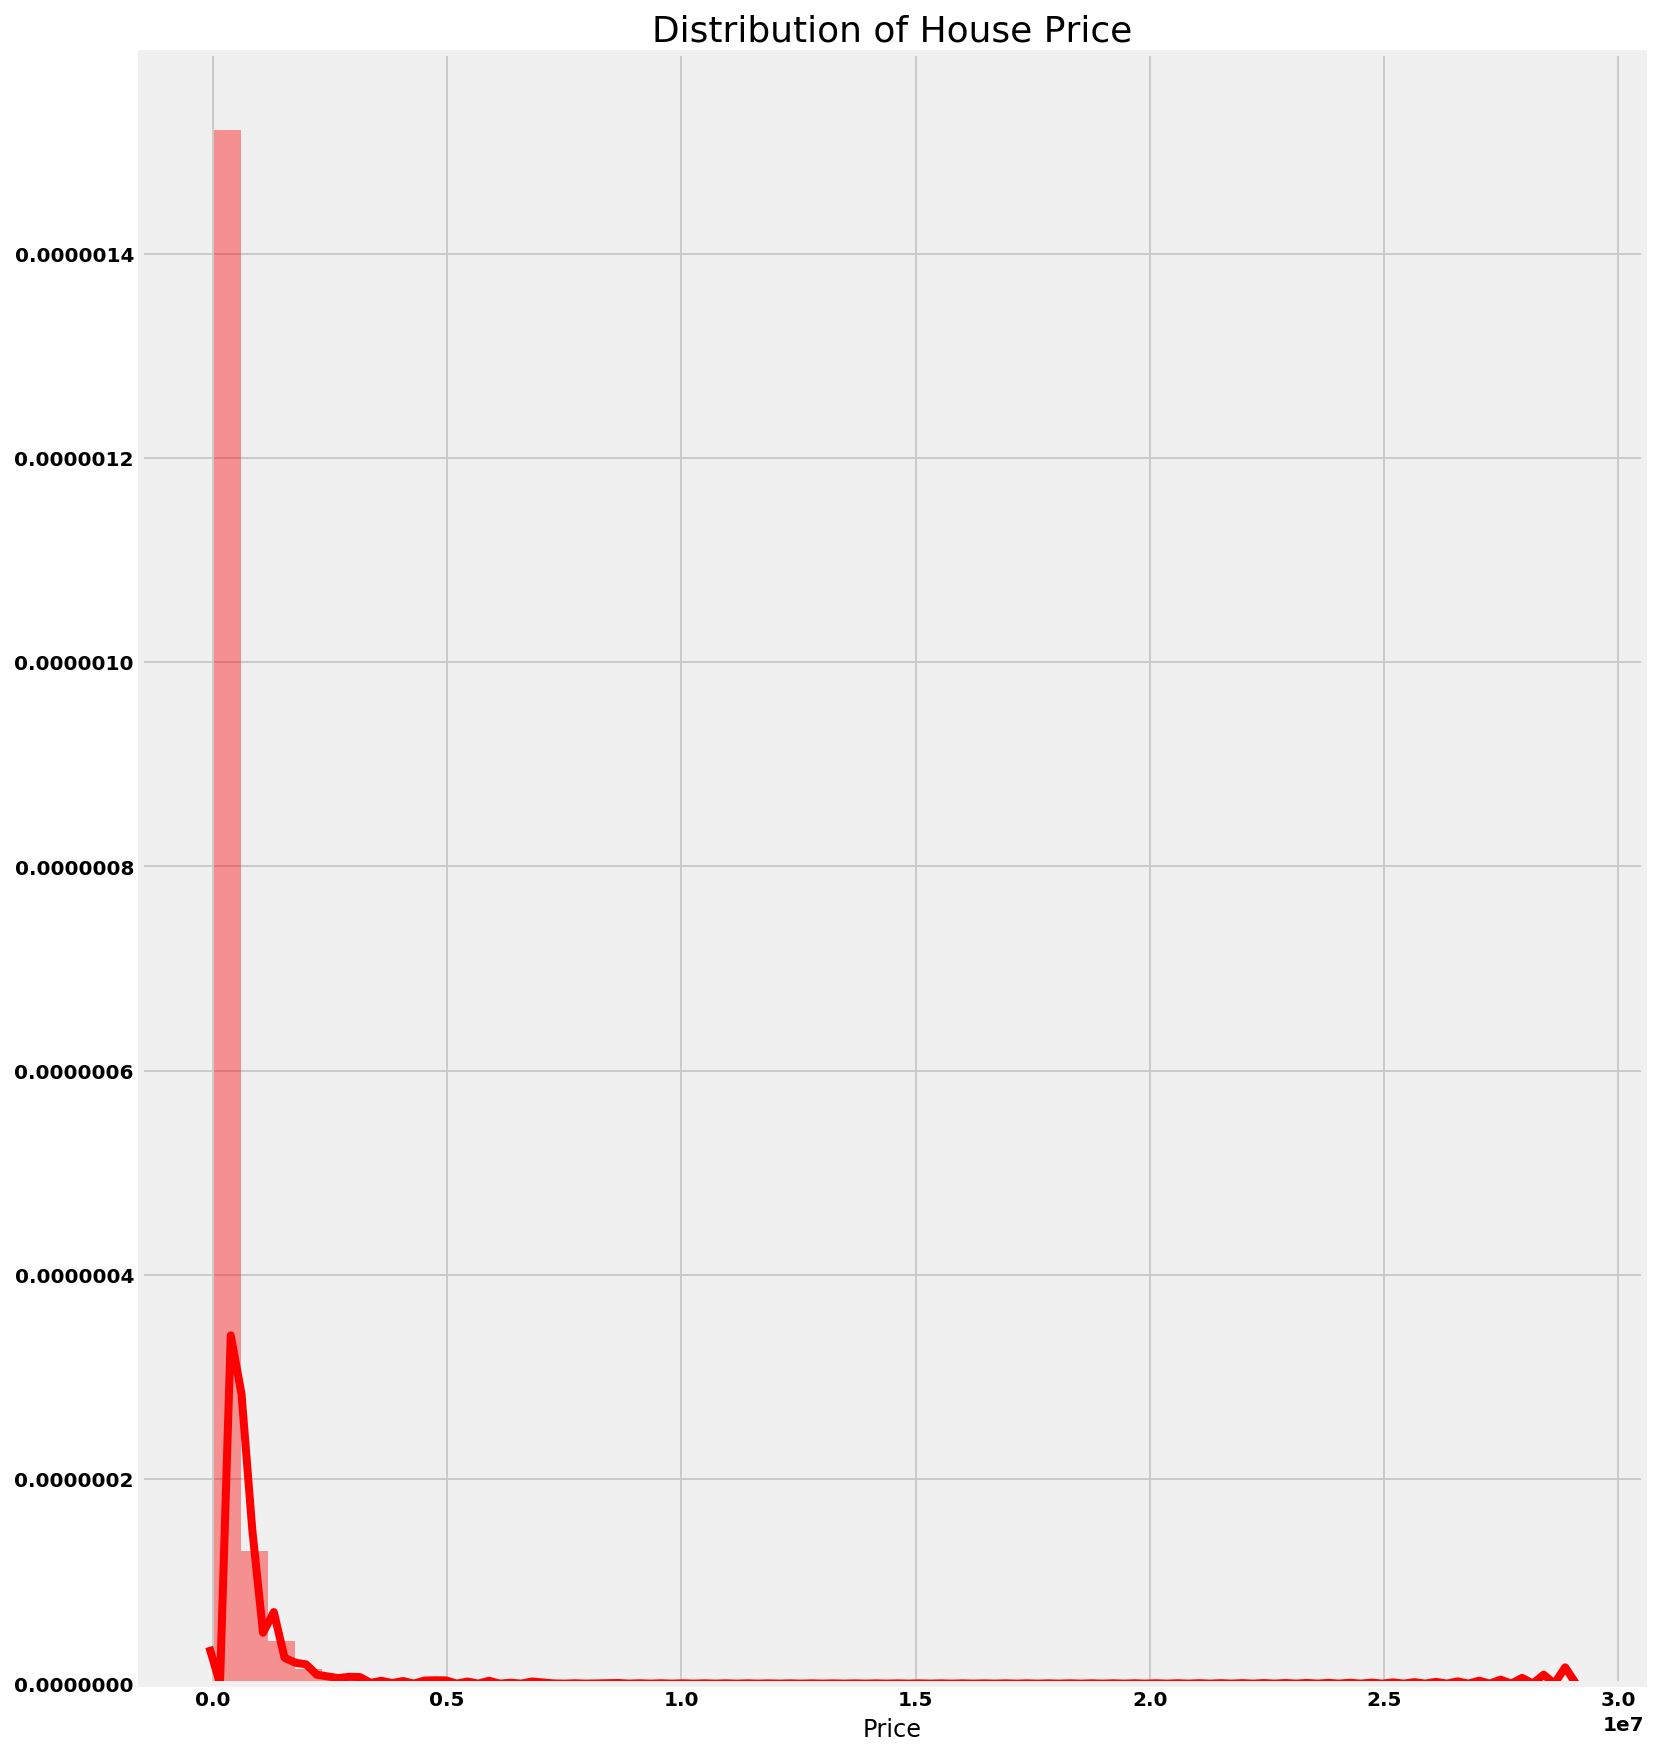

In [35]:
plt.figure(figsize=(12,15))
sns.distplot(df_housesNEW['Price'], color='r')
plt.title('Distribution of House Price', fontsize=18)

plt.show()

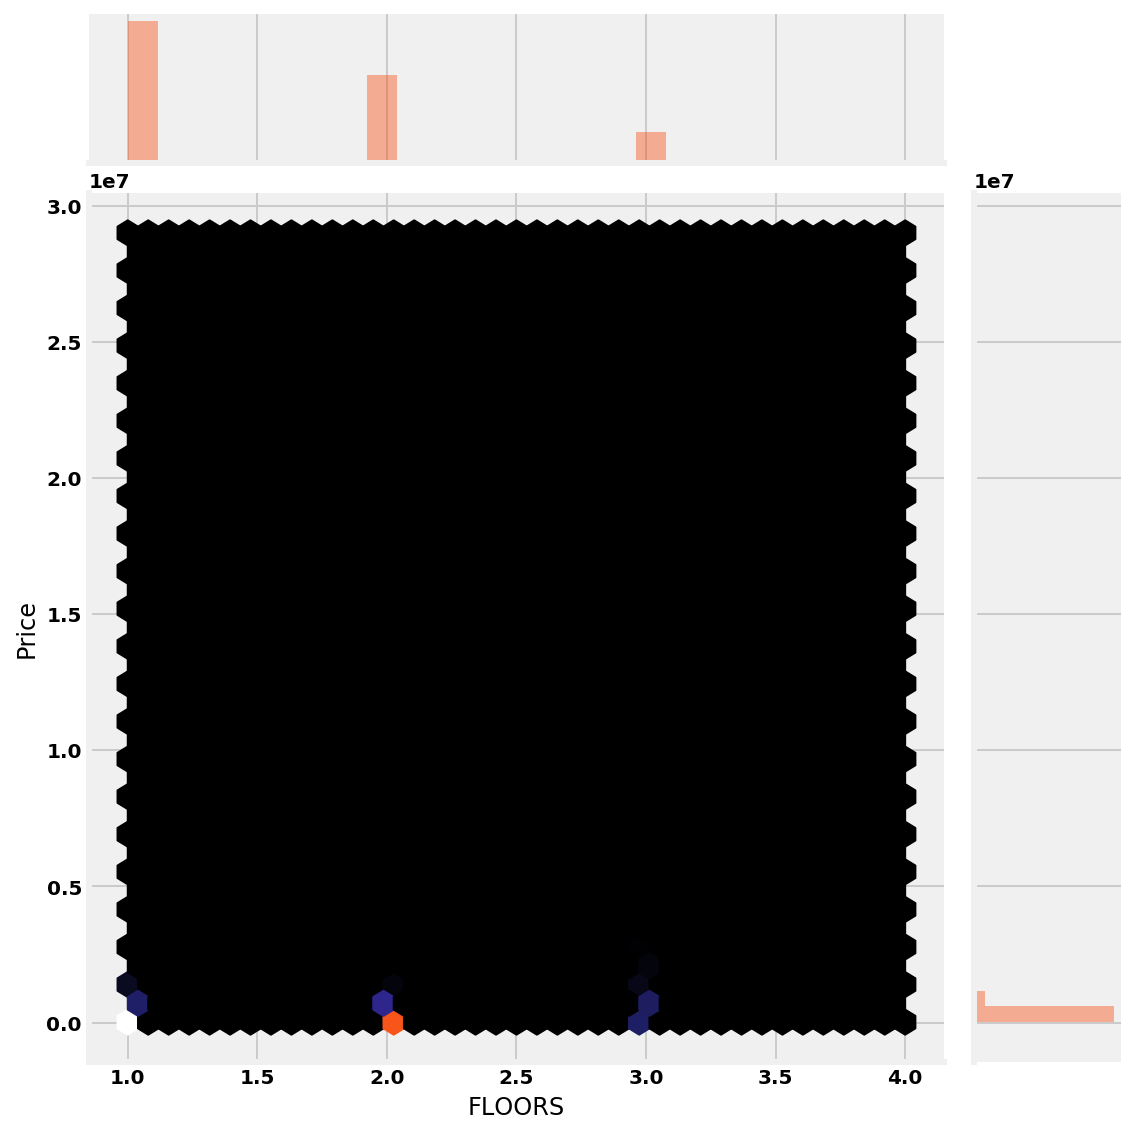

In [38]:
sns.jointplot(x='FLOORS',y='Price',data=df_housesNEW,
              kind='hex', cmap= 'CMRmap', size=8, color='#F84403')

plt.show()

In [ ]:
sns.lmplot(x='m2', y='Price', data=df_housesNEW)
plt.show()
sns.lmplot(x='FLOORS', y='Price', data=df_housesNEW)
plt.show()
sns.lmplot(x='Not_detached', y='Price', data=df_housesNEW)
plt.show()
sns.lmplot(x='Plot', y='Price', data=df_housesNEW)
plt.show()
sns.lmplot(x='Bedrooms', y='Price', data=df_housesNEW)
plt.show()
sns.lmplot(x='Bathrooms', y='Price', data=df_housesNEW)
plt.show()
sns.lmplot(x='Parking', y='Price', data=df_housesNEW)
plt.show()
sns.lmplot(x='Garden', y='Price', data=df_housesNEW)
plt.show()

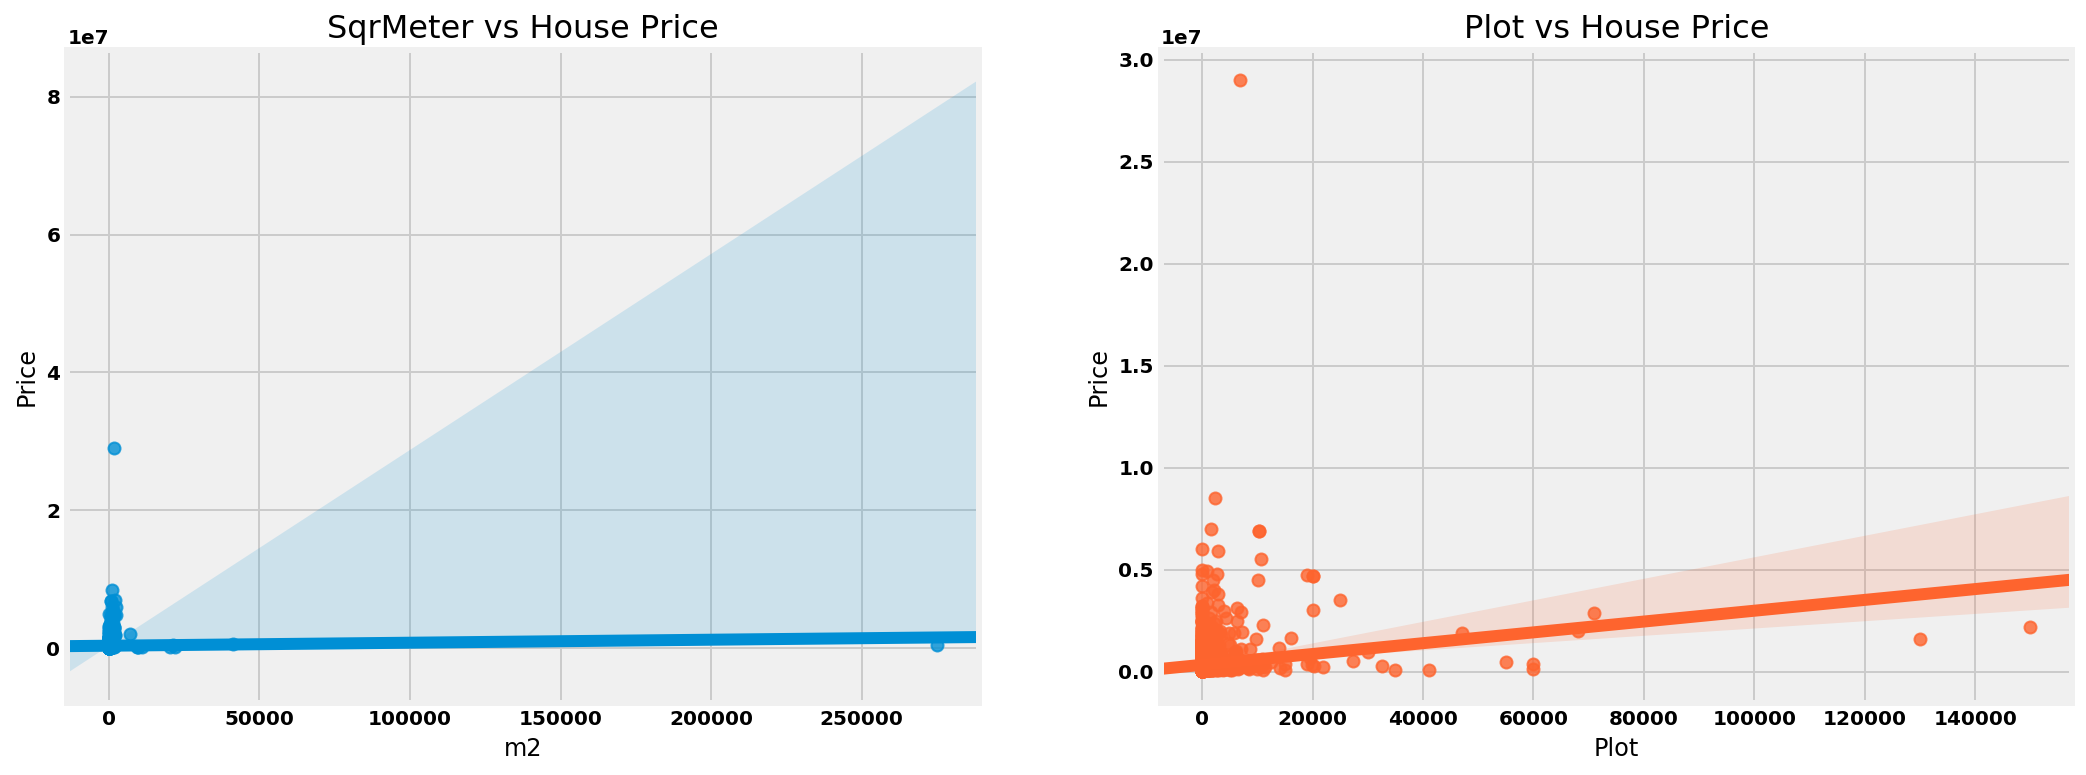

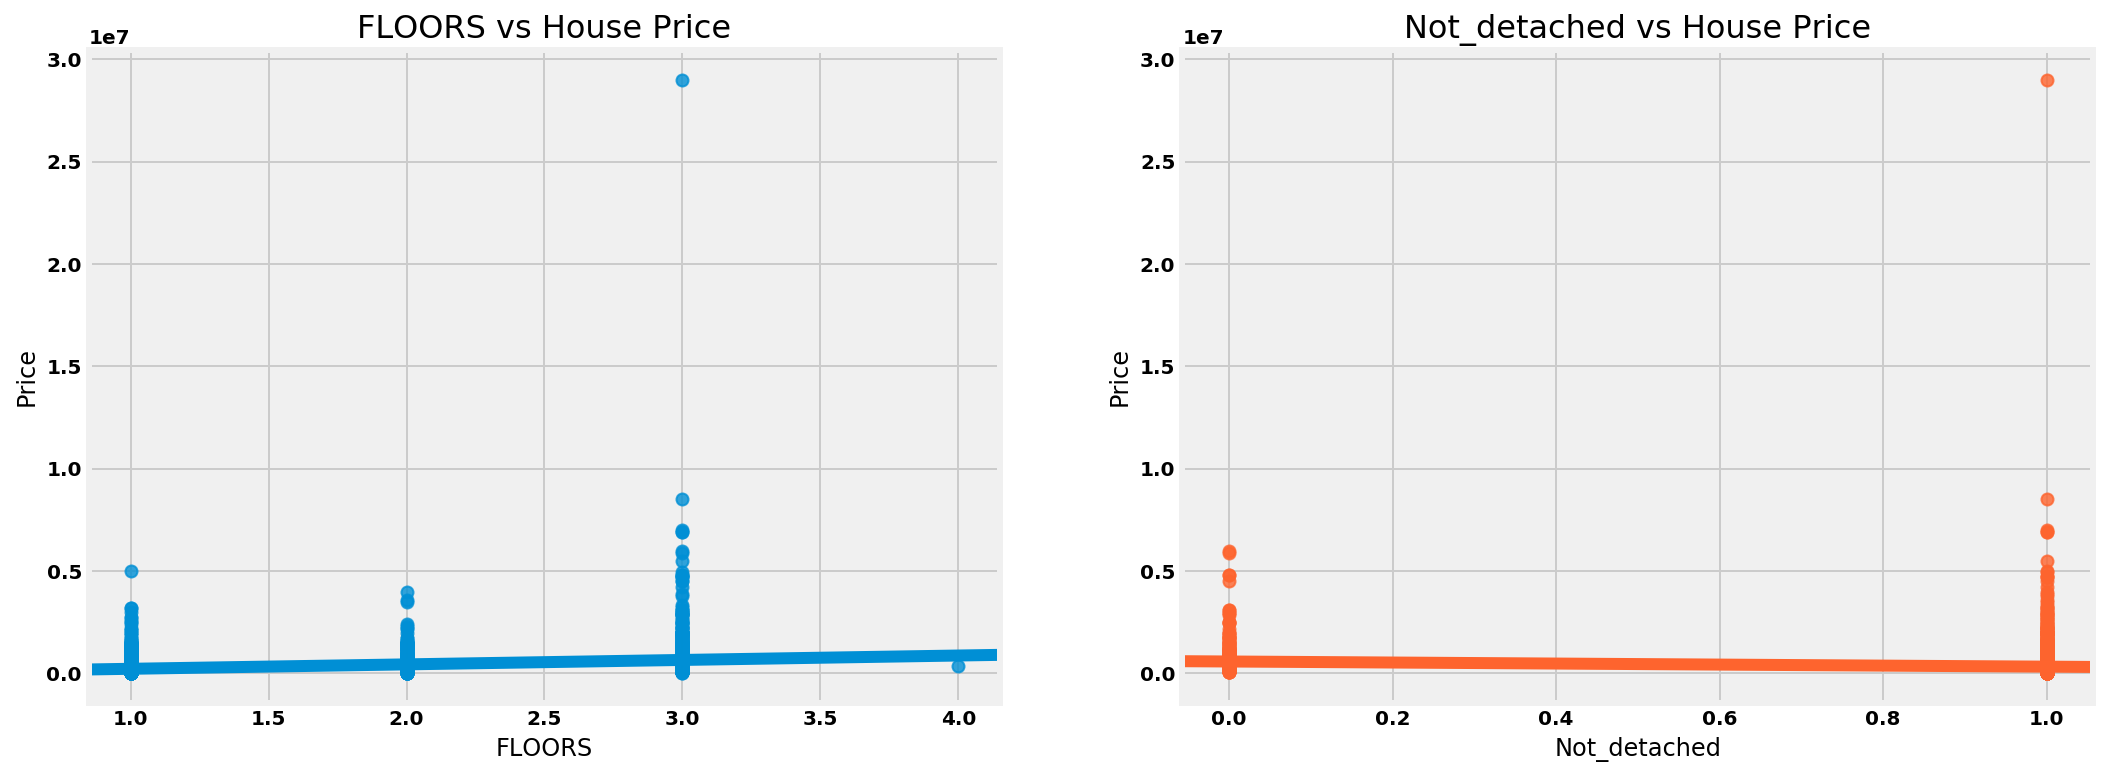

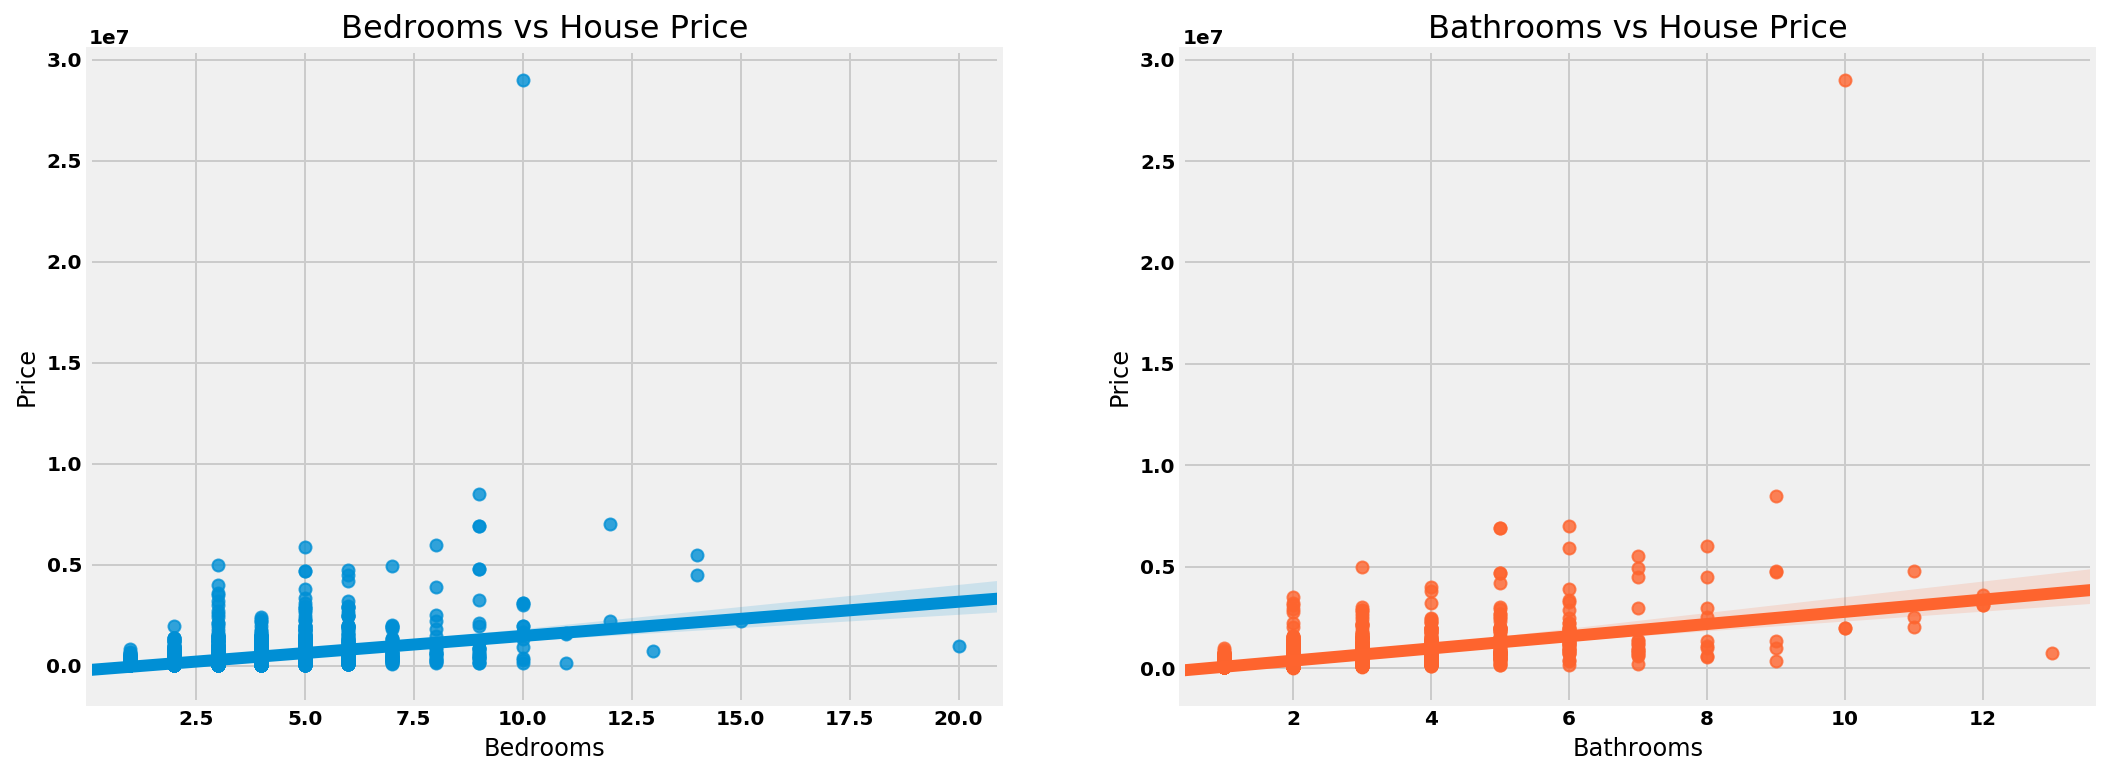

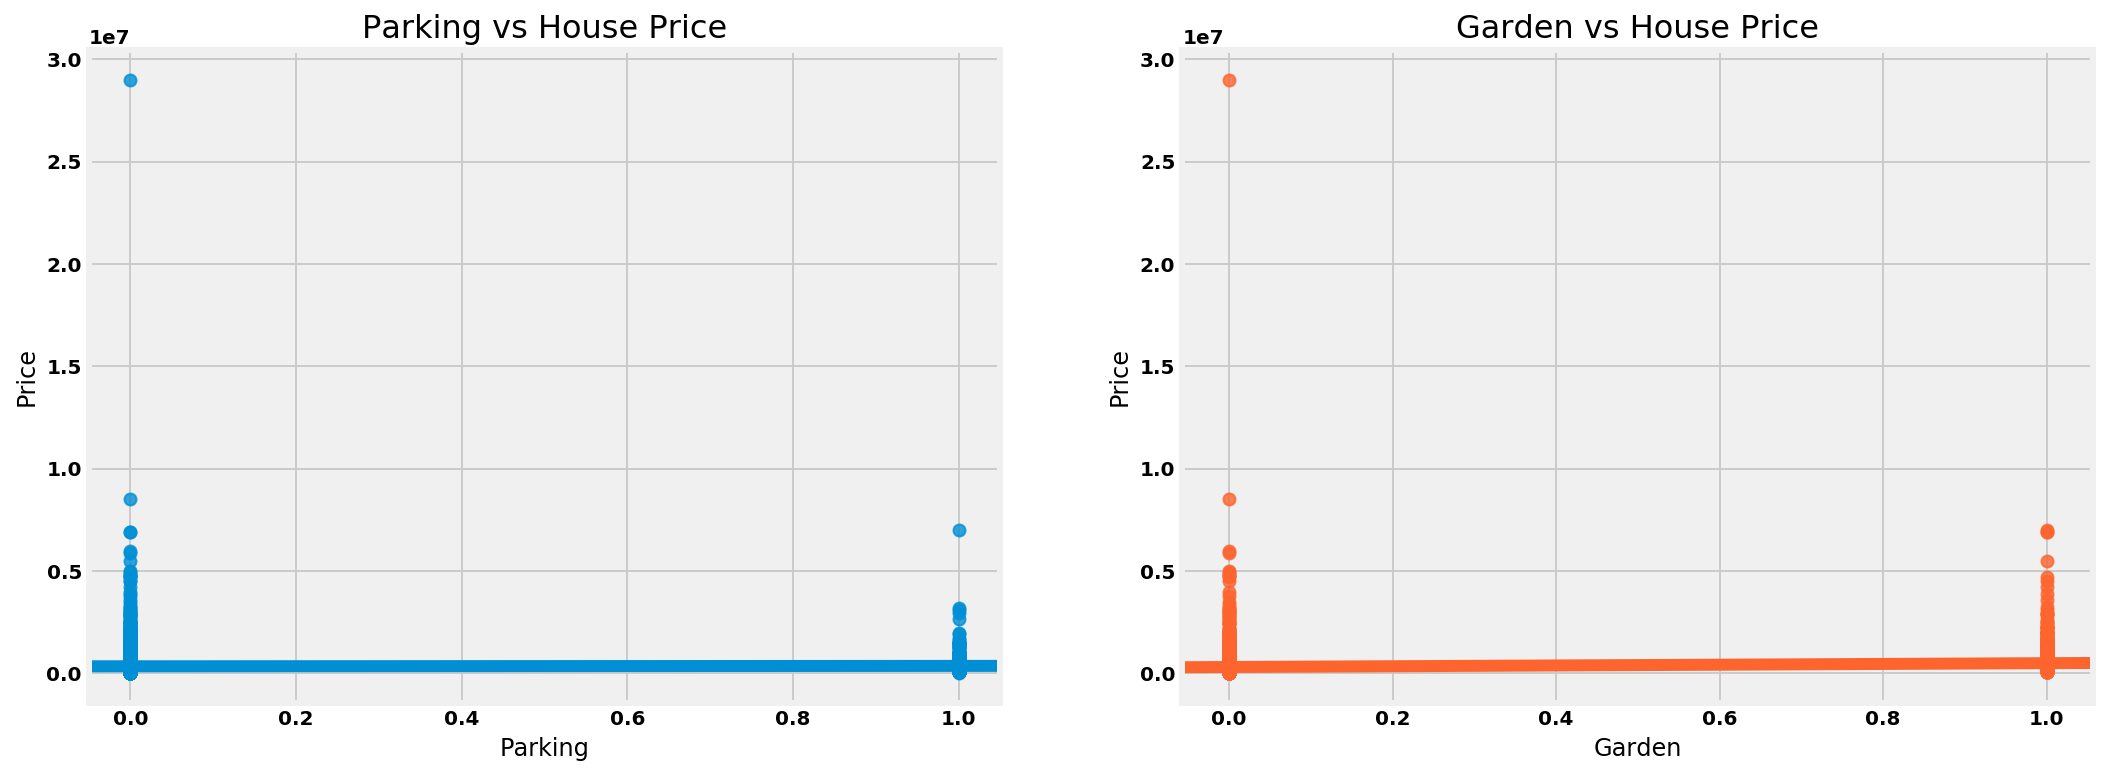

In [43]:
plt.figure(figsize=(16,6))
plt.subplot(121)
ax = sns.regplot(x="m2", y="Price", data=df_housesNEW)
ax.set_title("SqrMeter vs House Price", fontsize=16)

plt.subplot(122)
ax1 = sns.regplot(x="Plot", y="Price", data=df_housesNEW, color='#FE642E')
ax1.set_title("Plot vs House Price", fontsize=16)

plt.show()

plt.figure(figsize=(16,6))
plt.subplot(121)
ax = sns.regplot(x="FLOORS", y="Price", data=df_housesNEW)
ax.set_title("FLOORS vs House Price", fontsize=16)

plt.subplot(122)
ax1 = sns.regplot(x="Not_detached", y="Price", data=df_housesNEW, color='#FE642E')
ax1.set_title("Not_detached vs House Price", fontsize=16)

plt.show()

plt.figure(figsize=(16,6))
plt.subplot(121)
ax = sns.regplot(x="Bedrooms", y="Price", data=df_housesNEW)
ax.set_title("Bedrooms vs House Price", fontsize=16)

plt.subplot(122)
ax1 = sns.regplot(x="Bathrooms", y="Price", data=df_housesNEW, color='#FE642E')
ax1.set_title("Bathrooms vs House Price", fontsize=16)

plt.show()

plt.figure(figsize=(16,6))
plt.subplot(121)
ax = sns.regplot(x="Parking", y="Price", data=df_housesNEW)
ax.set_title("Parking vs House Price", fontsize=16)

plt.subplot(122)
ax1 = sns.regplot(x="Garden", y="Price", data=df_housesNEW, color='#FE642E')
ax1.set_title("Garden vs House Price", fontsize=16)

plt.show()

No handles with labels found to put in legend.


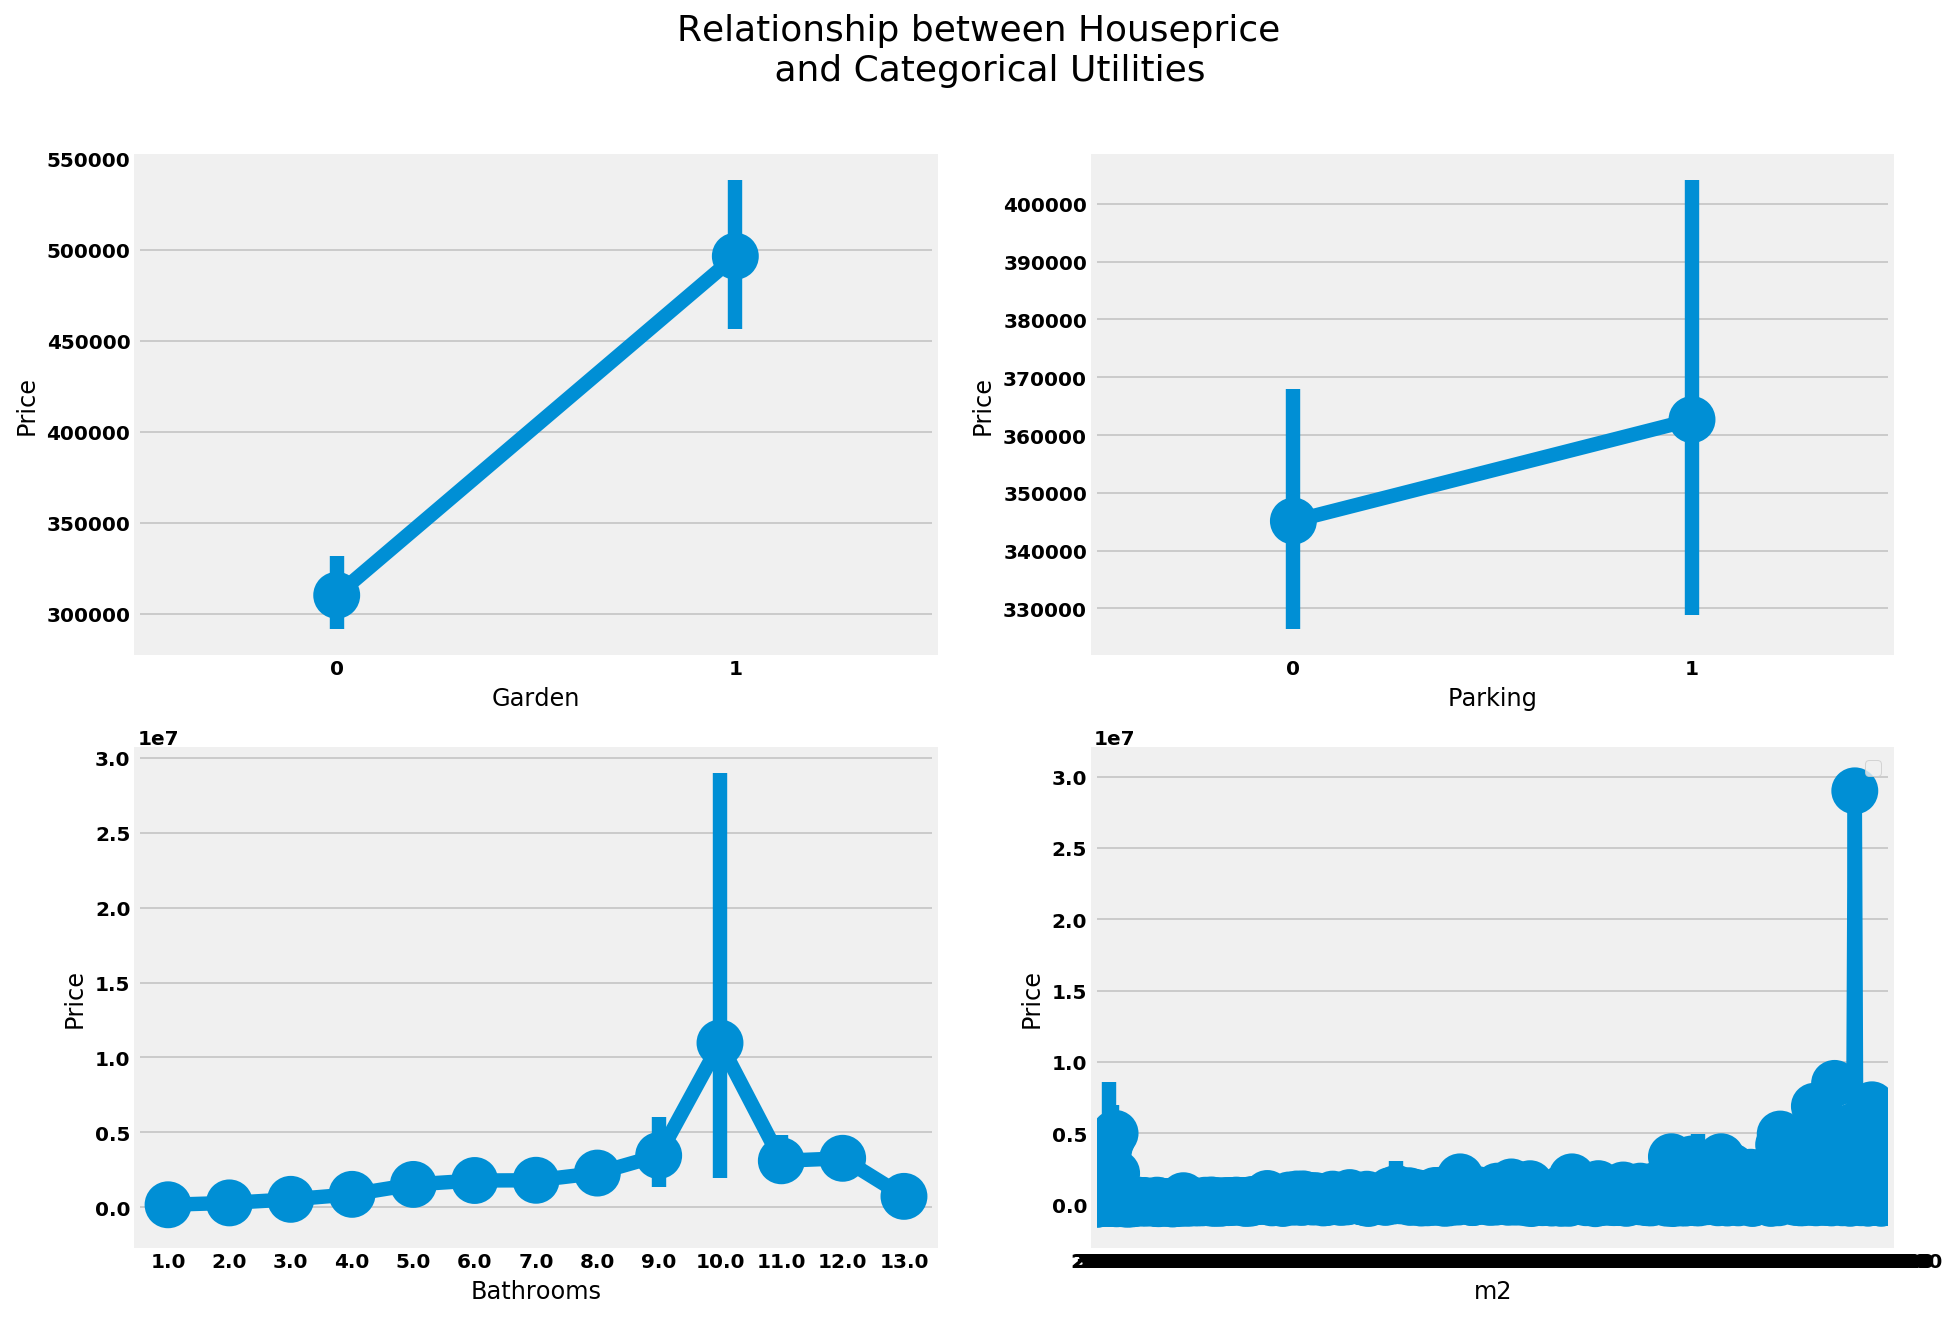

In [45]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
plt.suptitle('Relationship between Houseprice \n and Categorical Utilities', fontsize=18)
sns.pointplot(x='Garden', y='Price', data=df_housesNEW, ax=ax1)
sns.pointplot(x='Parking', y='Price', data=df_housesNEW, ax=ax2)
sns.pointplot(x='Bathrooms', y='Price',  data=df_housesNEW, ax=ax3)
sns.pointplot(x='Bedrooms', y='Price',  data=df_housesNEW, ax=ax4)
sns.pointplot(x='Not_detached', y='Price', data=df_housesNEW, ax=ax4)
sns.pointplot(x='FLOORS', y='Price',data=df_housesNEW, ax=ax4)
sns.pointplot(x='Plot', y='Price', data=df_housesNEW, ax=ax4)
sns.pointplot(x='m2', y='Price',  data=df_housesNEW, ax=ax4)

plt.legend(loc='best')
plt.show()

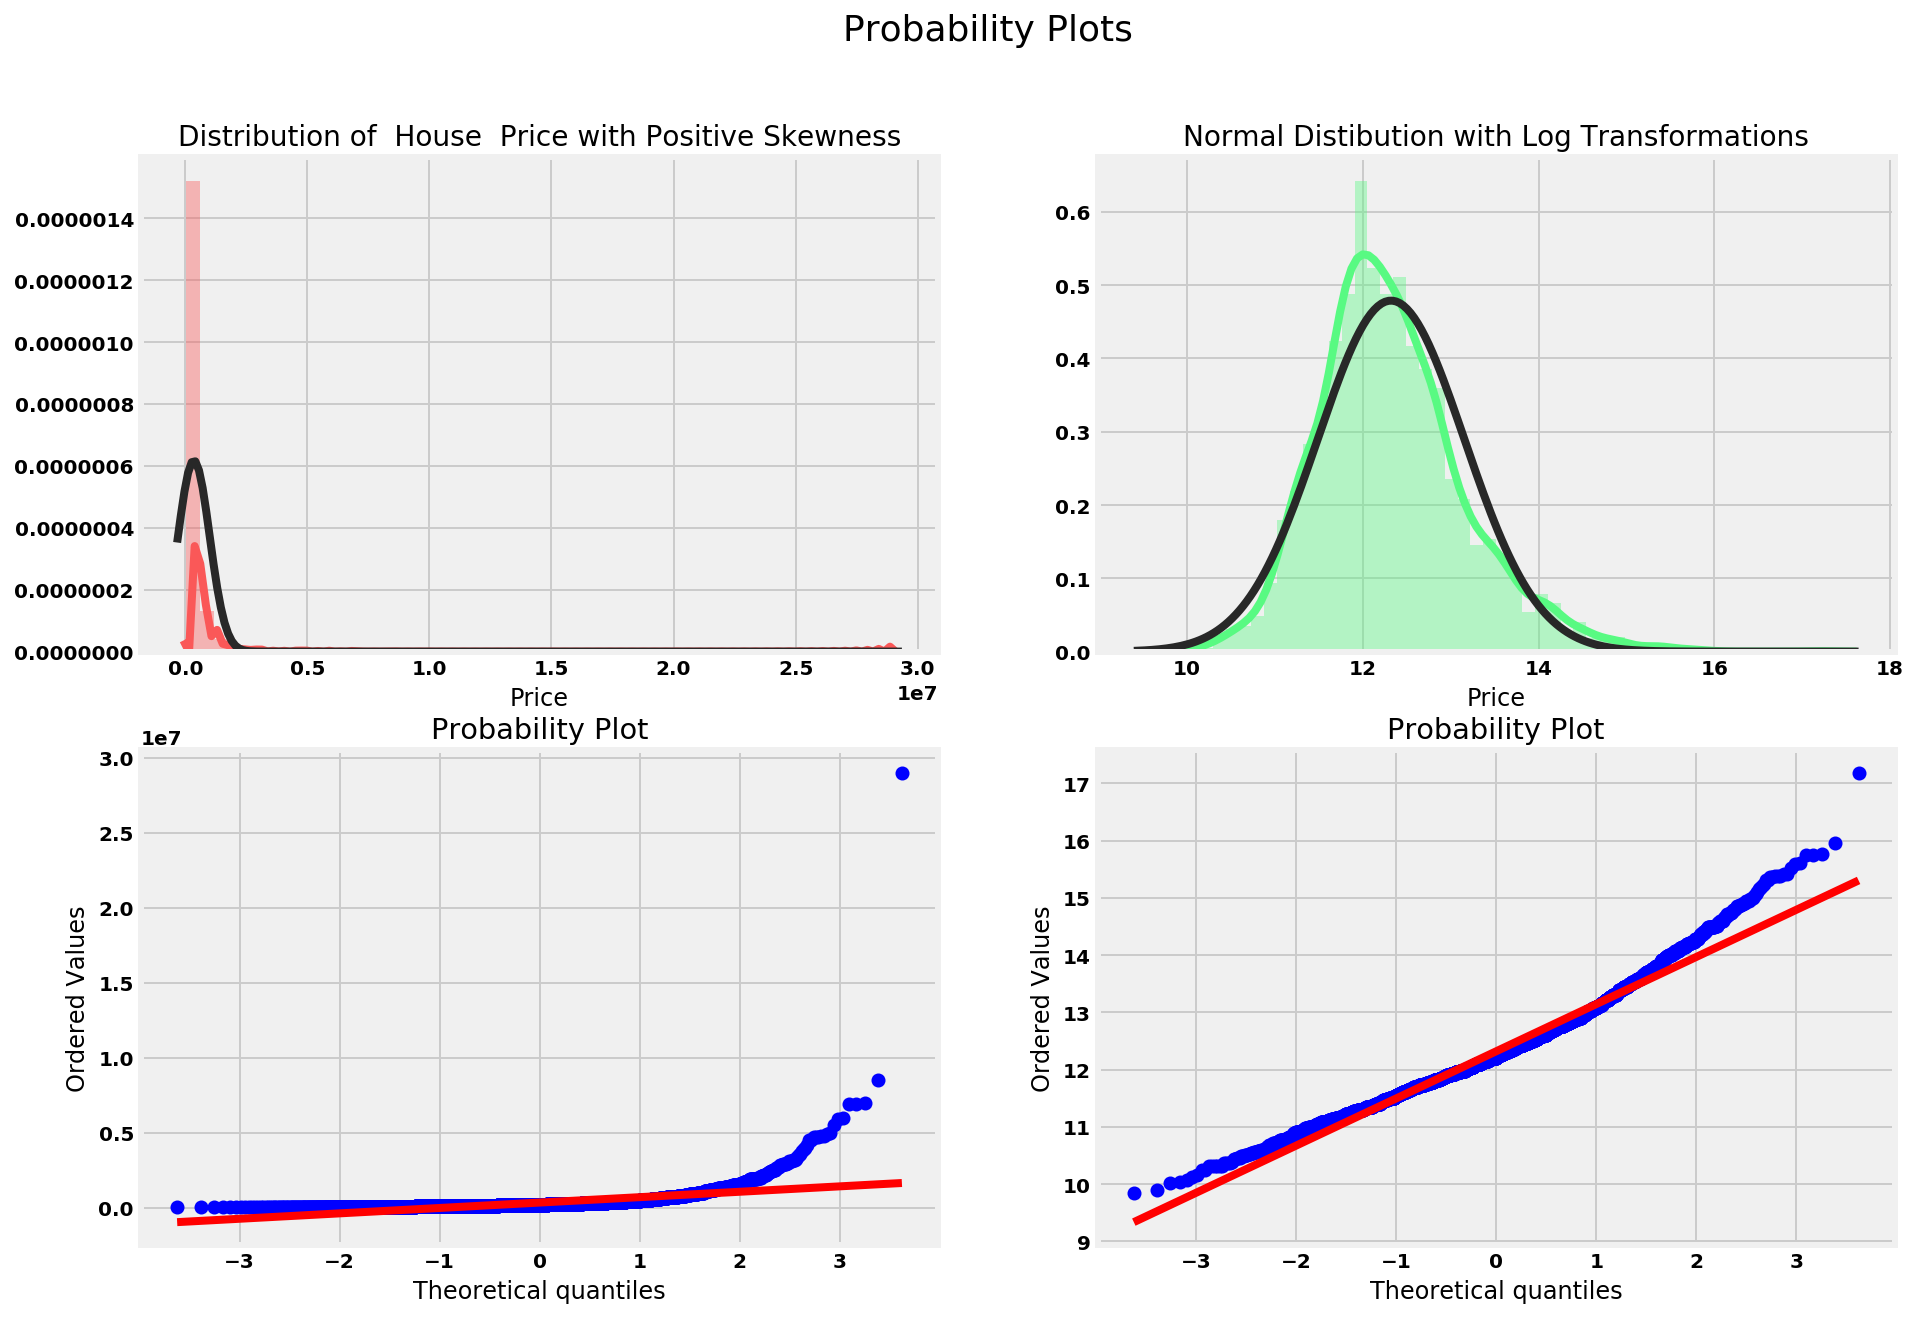

In [49]:
from scipy import stats
from scipy.stats import norm

# norm = a normal continous variable.

log_style = np.log(df_housesNEW['Price'])  # log of Houseprice

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
plt.suptitle('Probability Plots', fontsize=18)
ax1 = sns.distplot(df_housesNEW['Price'], color="#FA5858", ax=ax1, fit=norm)
ax1.set_title("Distribution of  House  Price with Positive Skewness", fontsize=14)
ax2 = sns.distplot(log_style, color="#58FA82",ax=ax2, fit=norm)
ax2.set_title("Normal Distibution with Log Transformations", fontsize=14)
ax3 = stats.probplot(df_housesNEW['Price'], plot=ax3)
ax4 = stats.probplot(log_style, plot=ax4)

plt.show()

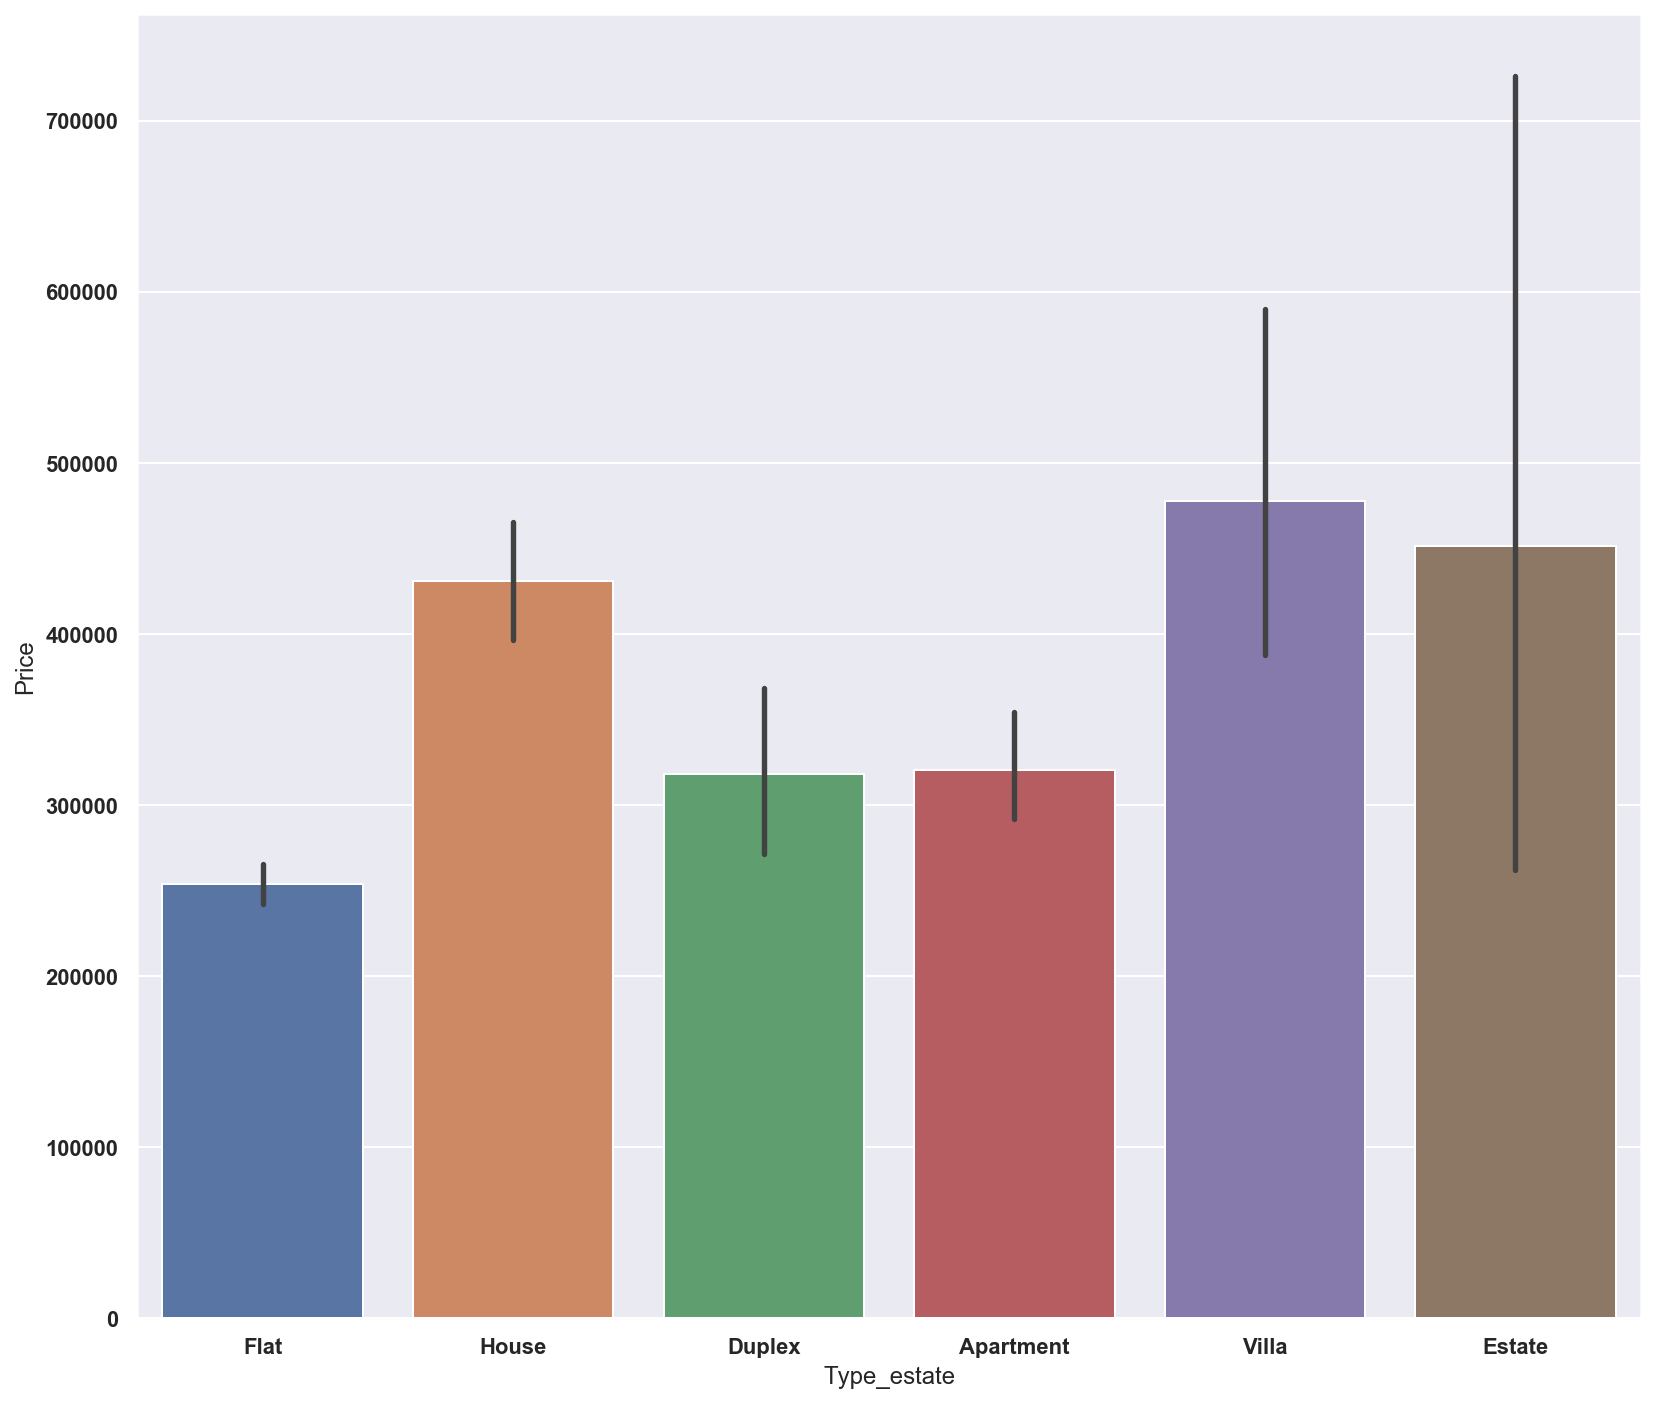

In [51]:
sns.set(rc={"figure.figsize": (12, 12)})
sns.barplot(x='Type_estate',y='Price',data=df_housesNEW,saturation=0.75)
#plt.figure(figsize=(20,15))
#plt.savefig("./img/pricebytype.png")
plt.show()

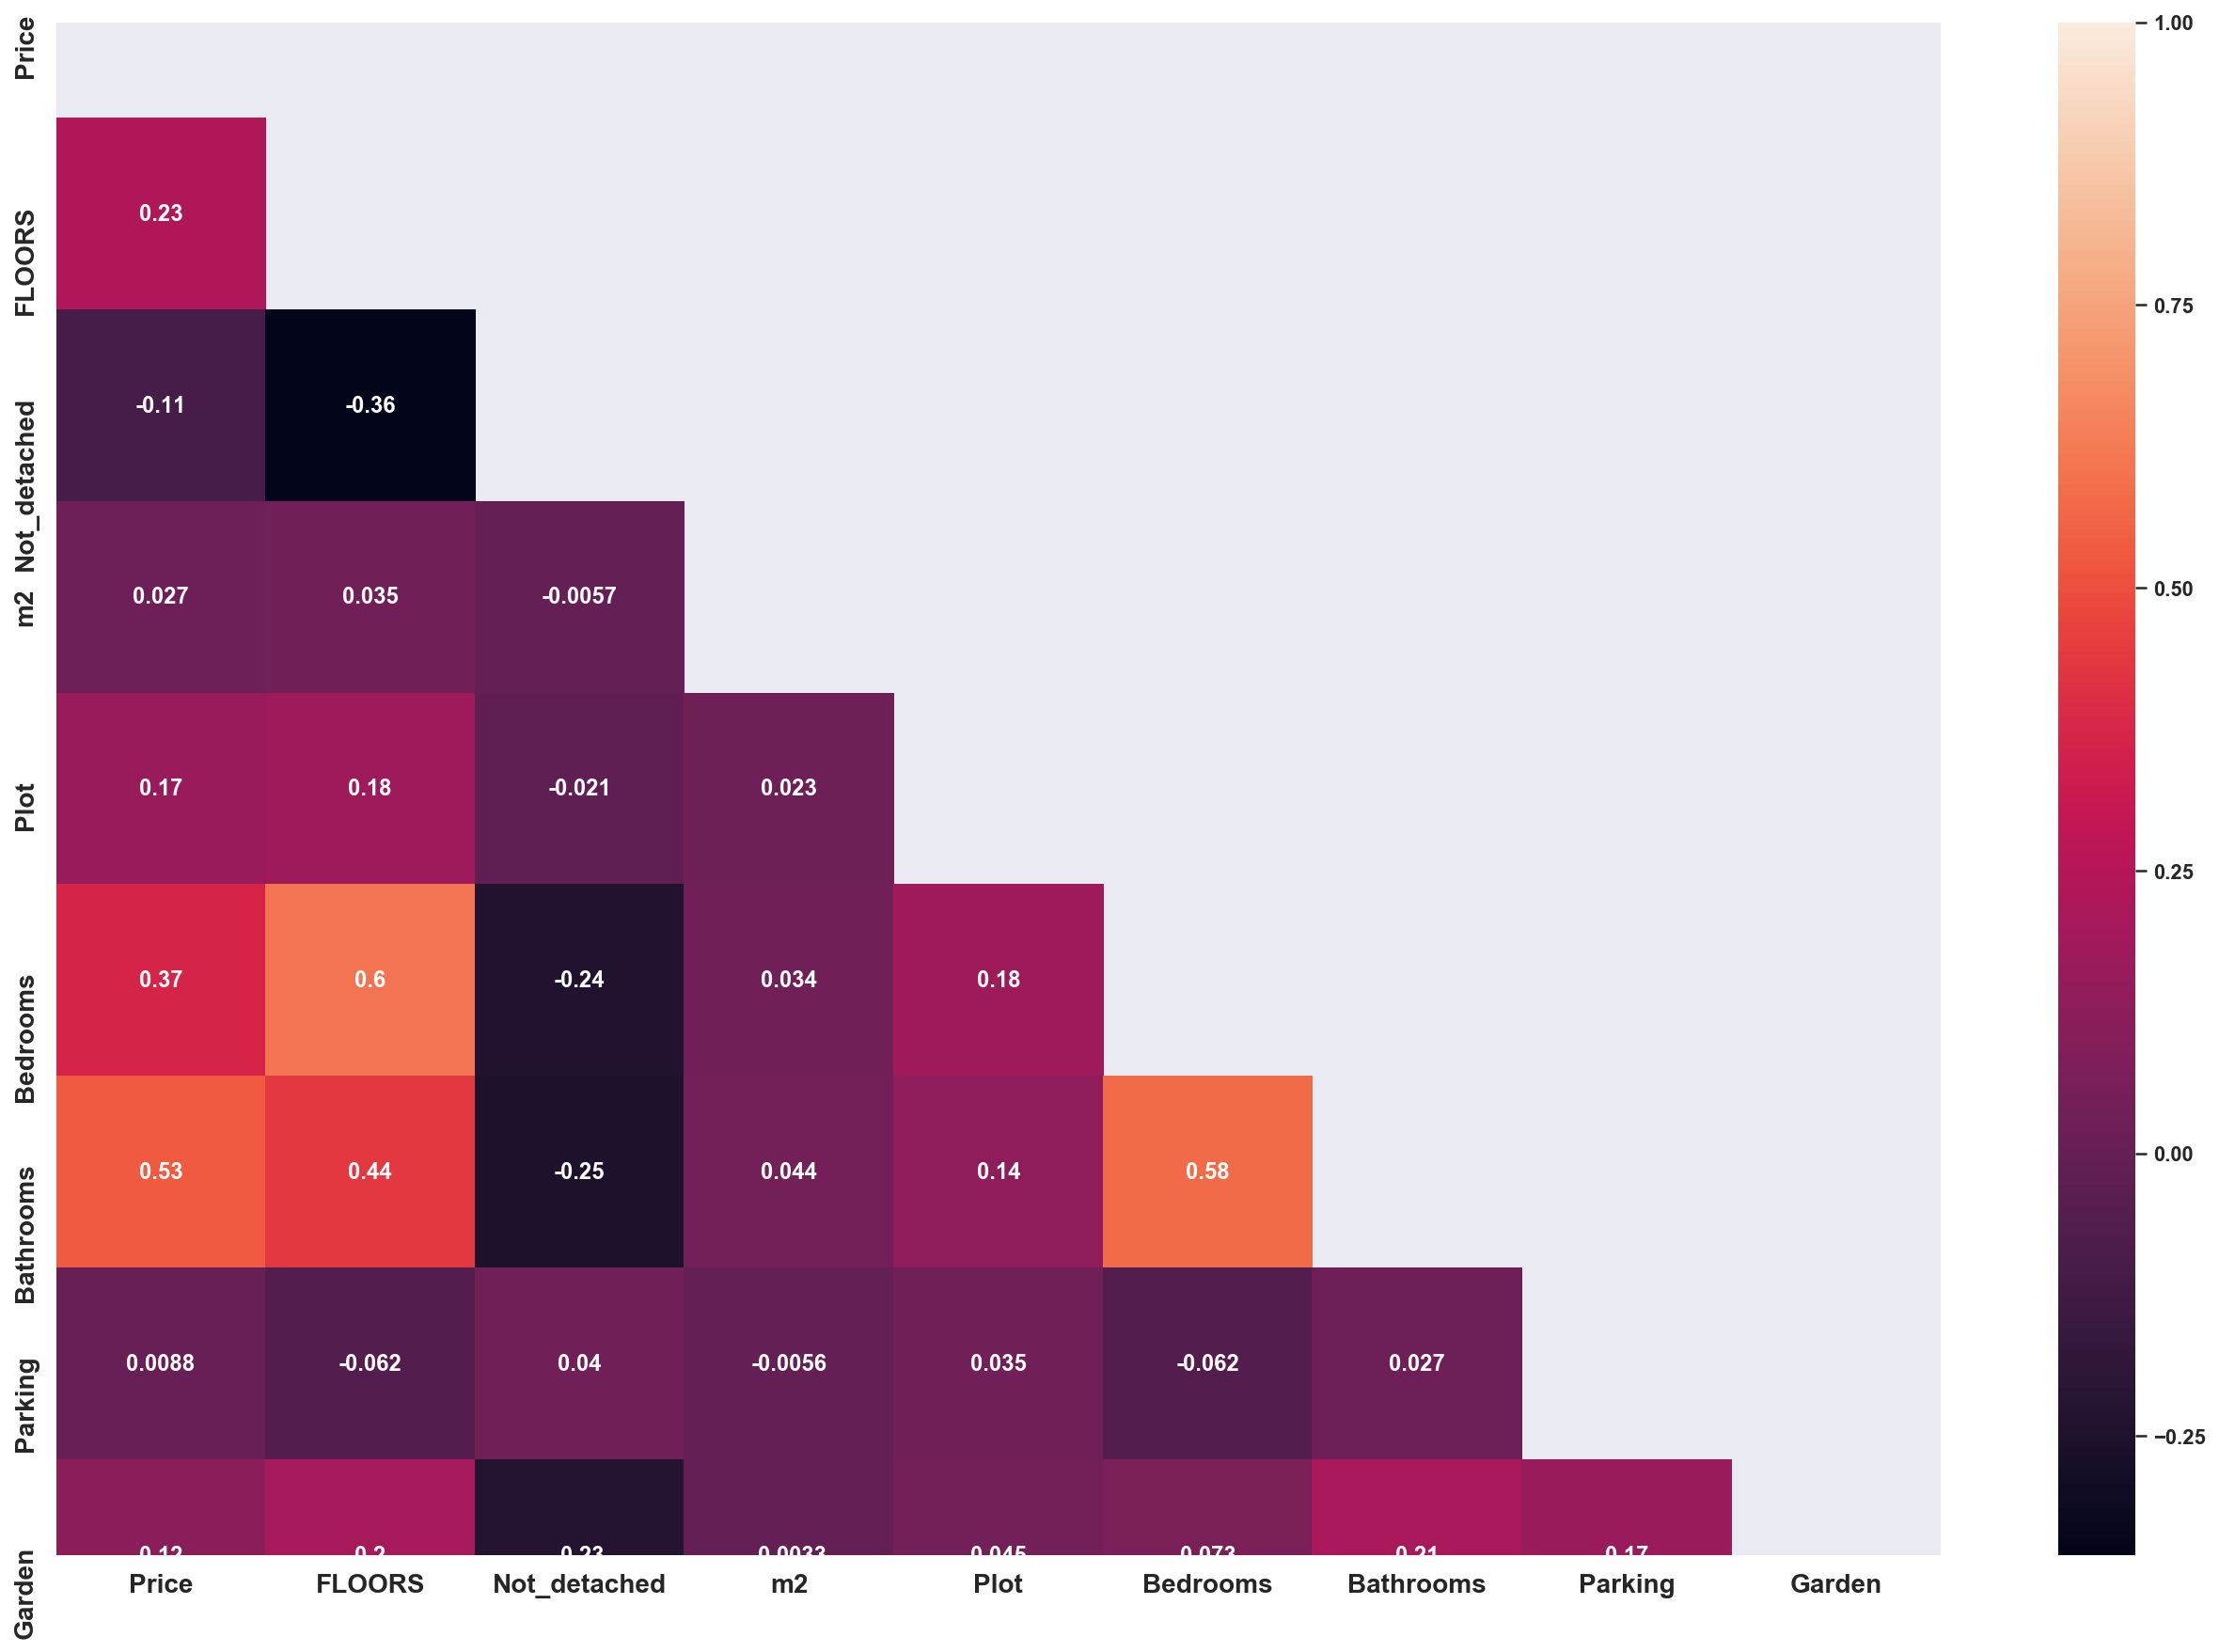

In [52]:
fix, ax = plt.subplots(figsize=(20,15))
mask = np.zeros_like(df_housesNEW.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df_housesNEW.corr(), annot=True, mask=mask, ax=ax)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
#plt.savefig("./img/HousingHeatMap.png")
plt.show()

In [53]:
df_housesNEW['Type_estate'].value_counts()

Flat         2005
House        1499
Villa         596
Apartment     581
Duplex         82
Estate         16
Name: Type_estate, dtype: int64

In [54]:
df_housesNEW['Type_estate']=df_housesNEW['Type_estate'].map(lambda x:  'Flat' if x == 'Apartment' else x)
df_housesNEW['Type_estate']=df_housesNEW['Type_estate'].map(lambda x:  'House' if x == 'Estate' else x)
df_housesNEW['Type_estate']=df_housesNEW['Type_estate'].map(lambda x:  'Flat' if x == 'Duplex' else x)

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [55]:
df_housesNEW['Type_estate'].value_counts()

Flat     2668
House    1515
Villa     596
Name: Type_estate, dtype: int64

In [56]:
df_housesNEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4779 entries, 0 to 5720
Data columns (total 10 columns):
Type_estate     4779 non-null object
Price           4779 non-null float64
FLOORS          4779 non-null int64
Not_detached    4779 non-null int64
m2              4779 non-null float64
Plot            4779 non-null float64
Bedrooms        4779 non-null int64
Bathrooms       4779 non-null float64
Parking         4779 non-null int64
Garden          4779 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 570.7+ KB


In [57]:
df_housesNEW['FLOORS'].value_counts()

1    2586
2    1614
3     578
4       1
Name: FLOORS, dtype: int64

In [58]:
df_housesNEW['FLOORS'].value_counts()

1    2586
2    1614
3     578
4       1
Name: FLOORS, dtype: int64

In [59]:
df_housesNEW['Not_detached'].value_counts()

1    4391
0     388
Name: Not_detached, dtype: int64

In [60]:
df_housesNEW['Plot'].value_counts()

0.0       3413
1000.0      23
600.0       17
3.0         16
200.0       15
          ... 
789.0        1
287.0        1
377.0        1
951.0        1
2190.0       1
Name: Plot, Length: 763, dtype: int64

In [61]:
df_housesNEW['Bedrooms'].value_counts()

3     1849
4     1060
2      969
5      383
1      236
6      165
7       50
9       25
8       20
10      12
11       3
14       2
12       2
15       1
13       1
20       1
Name: Bedrooms, dtype: int64

In [62]:
df_housesNEW['Bathrooms'].value_counts()

2.0     2146
1.0     1735
3.0      559
4.0      189
5.0       68
6.0       41
7.0       16
8.0        9
9.0        6
12.0       3
11.0       3
10.0       3
13.0       1
Name: Bathrooms, dtype: int64

In [63]:
df_housesNEW['Parking'].value_counts()

0    4212
1     567
Name: Parking, dtype: int64

In [64]:
df_housesNEW['Garden'].value_counts()

0    3826
1     953
Name: Garden, dtype: int64

In [65]:
df_housesNEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4779 entries, 0 to 5720
Data columns (total 10 columns):
Type_estate     4779 non-null object
Price           4779 non-null float64
FLOORS          4779 non-null int64
Not_detached    4779 non-null int64
m2              4779 non-null float64
Plot            4779 non-null float64
Bedrooms        4779 non-null int64
Bathrooms       4779 non-null float64
Parking         4779 non-null int64
Garden          4779 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 570.7+ KB


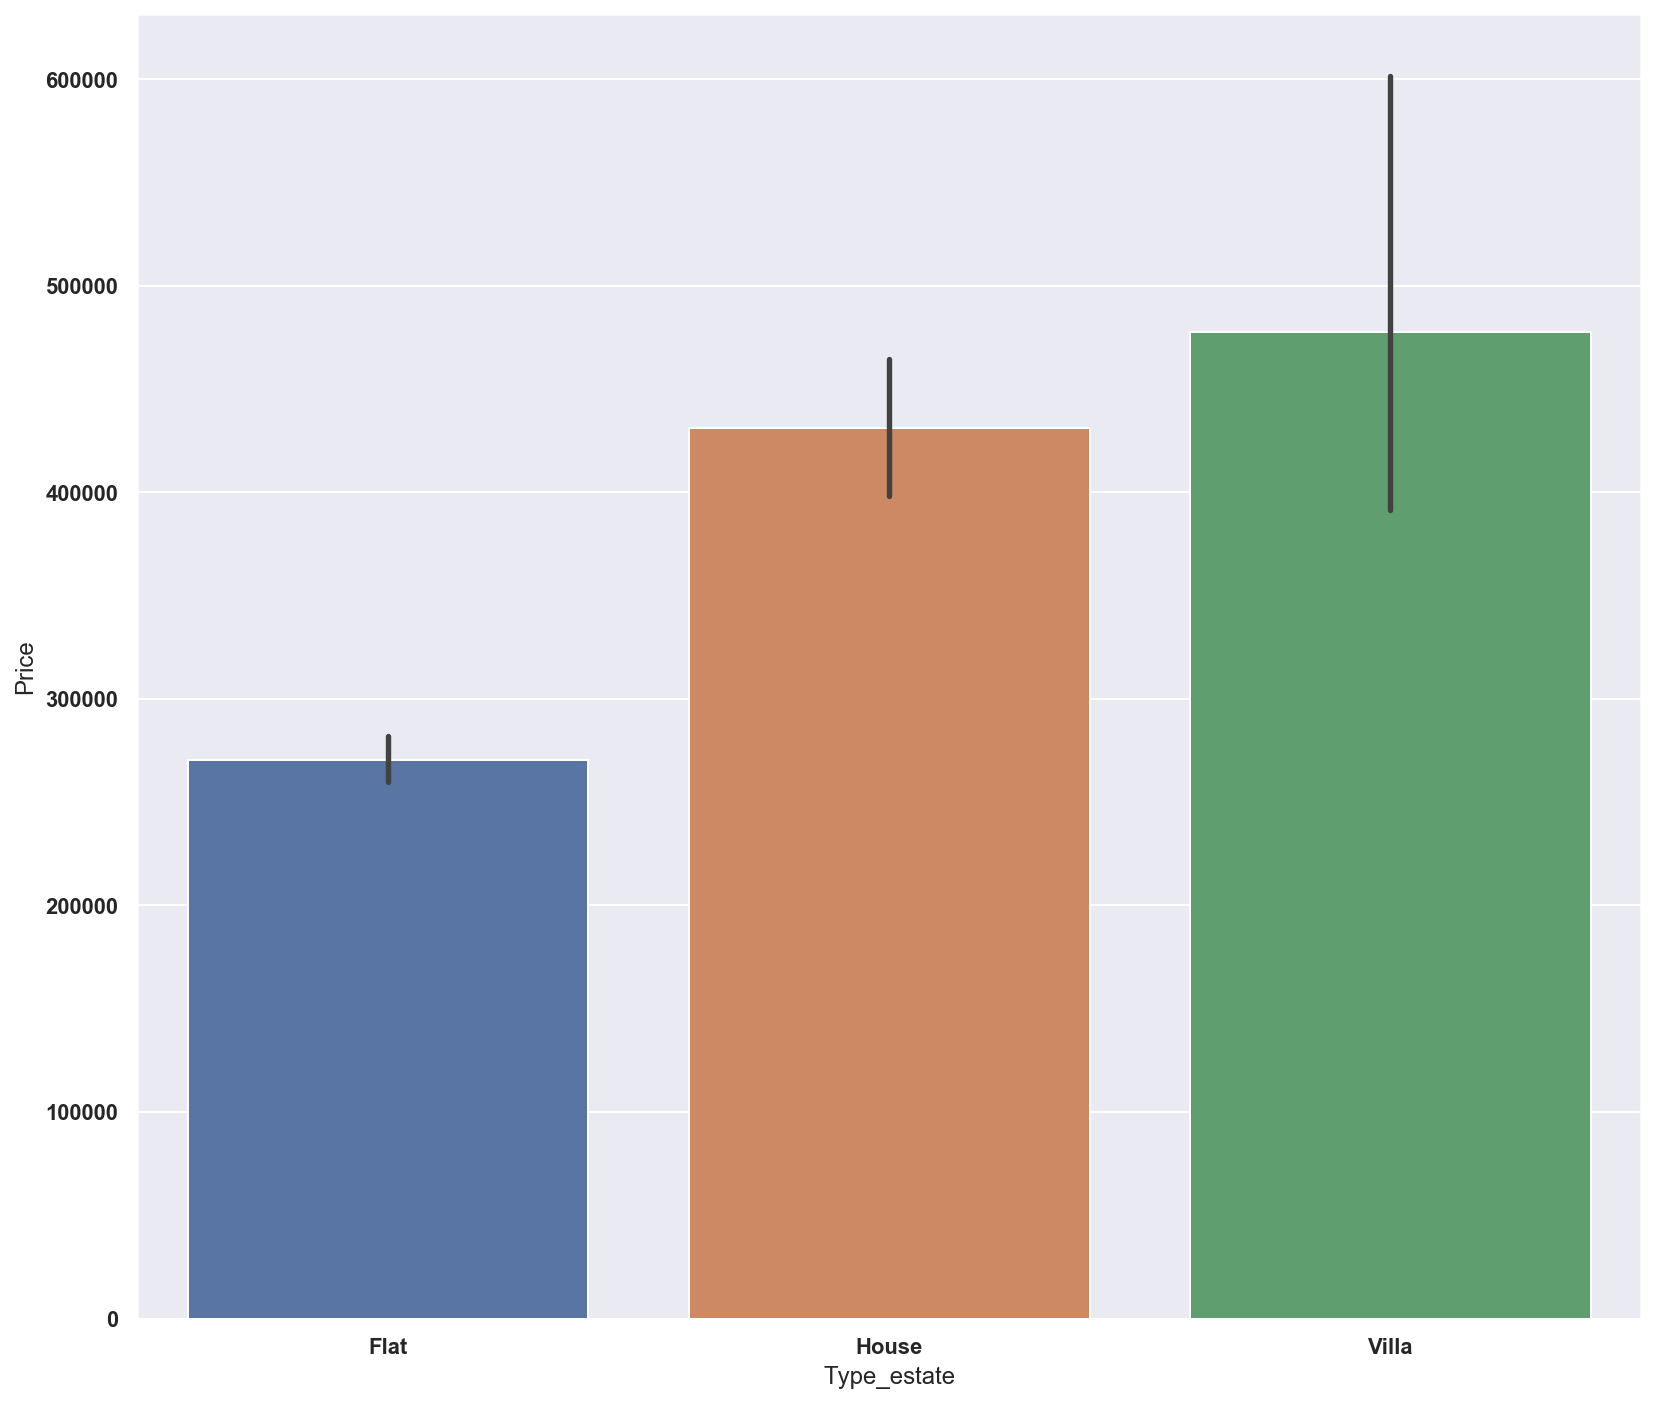

In [66]:
sns.set(rc={"figure.figsize": (12, 12)})
sns.barplot(x='Type_estate',y='Price',data=df_housesNEW,saturation=0.75)
#plt.figure(figsize=(20,15))
#plt.savefig("./img/pricebytype.png")
plt.show()

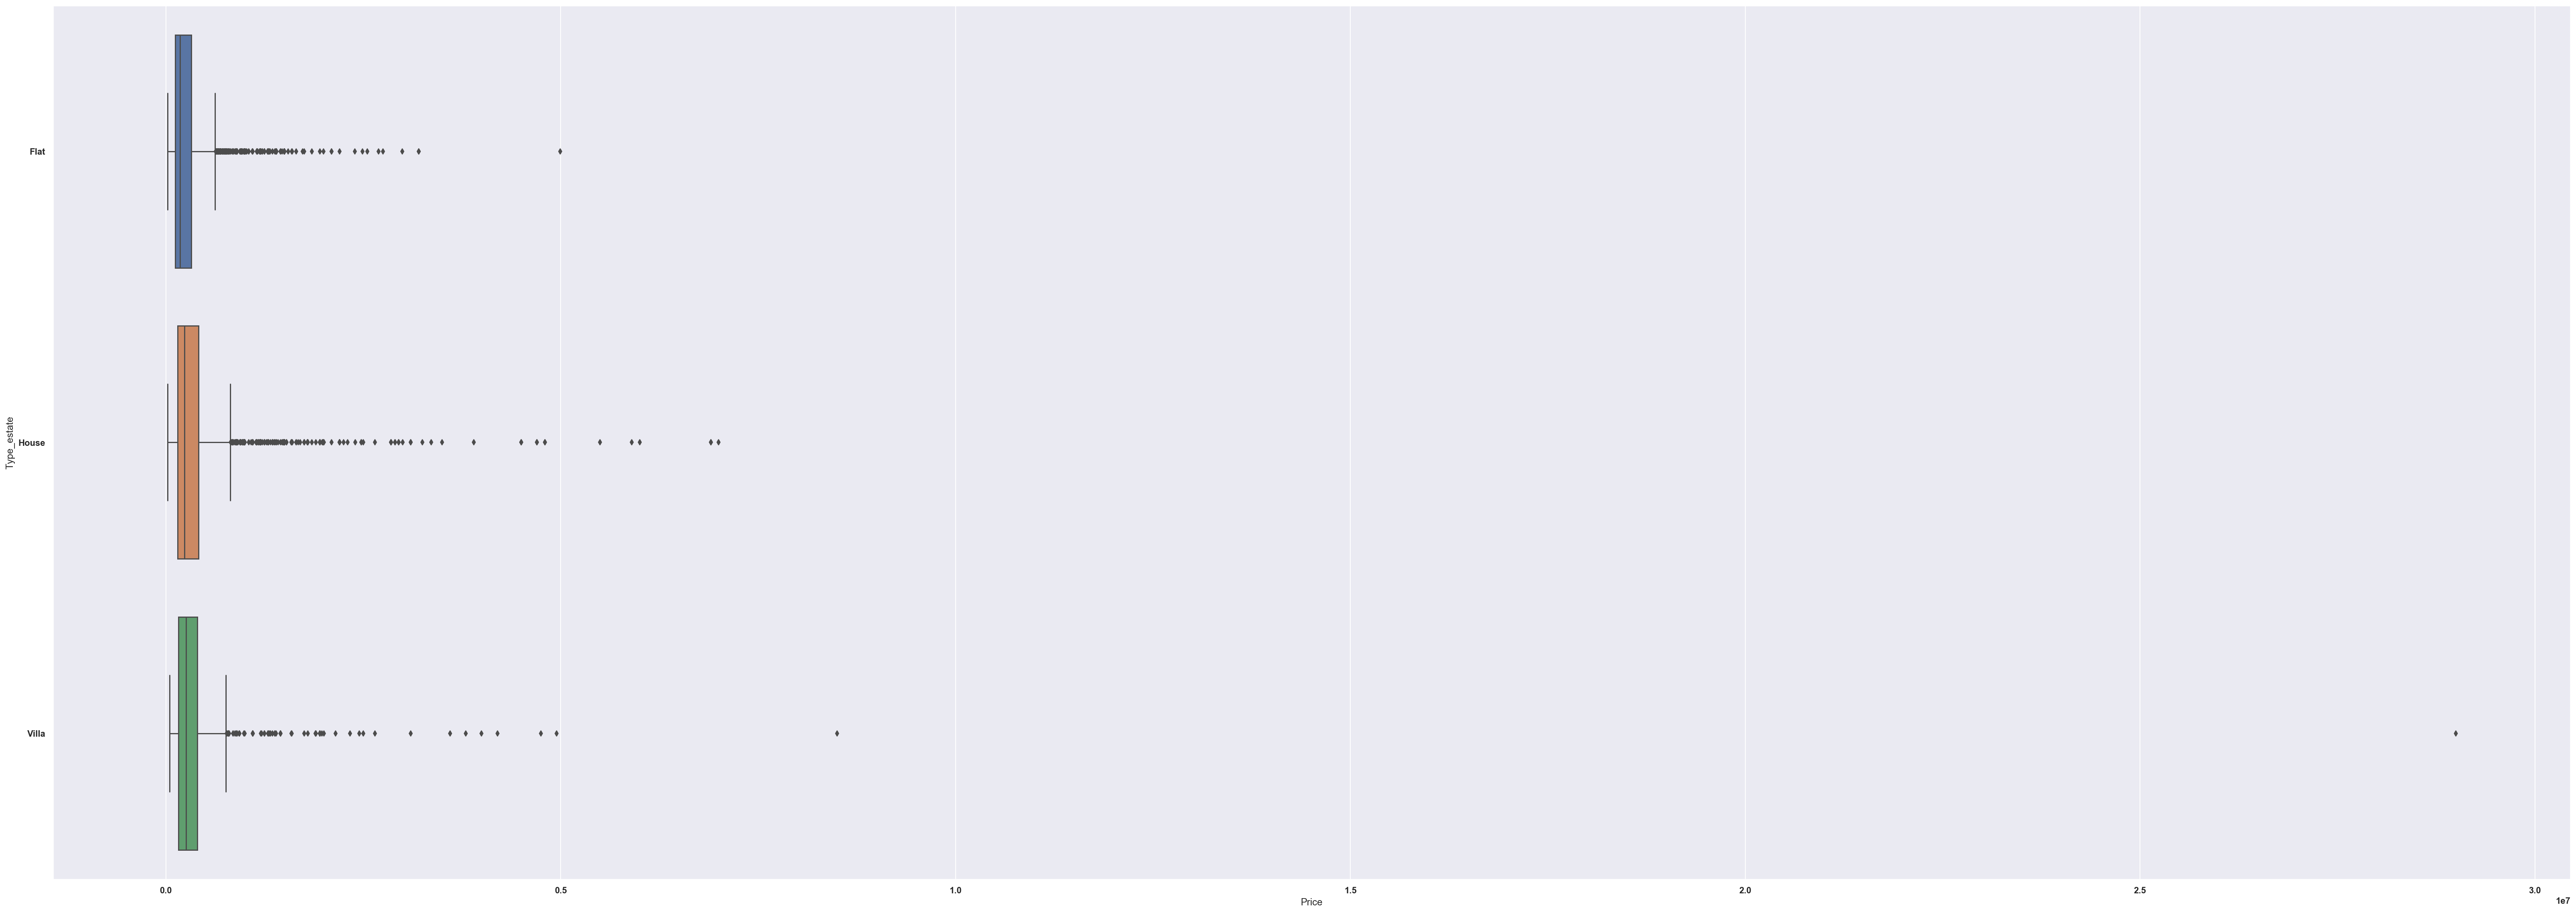

In [67]:
# Boxplot for the price per Type_estate
fig, ax = plt.subplots(figsize=(50,20))
sns.boxplot(x='Price', y='Type_estate', data=df_housesNEW, orient='h', ax=ax)
plt.show()

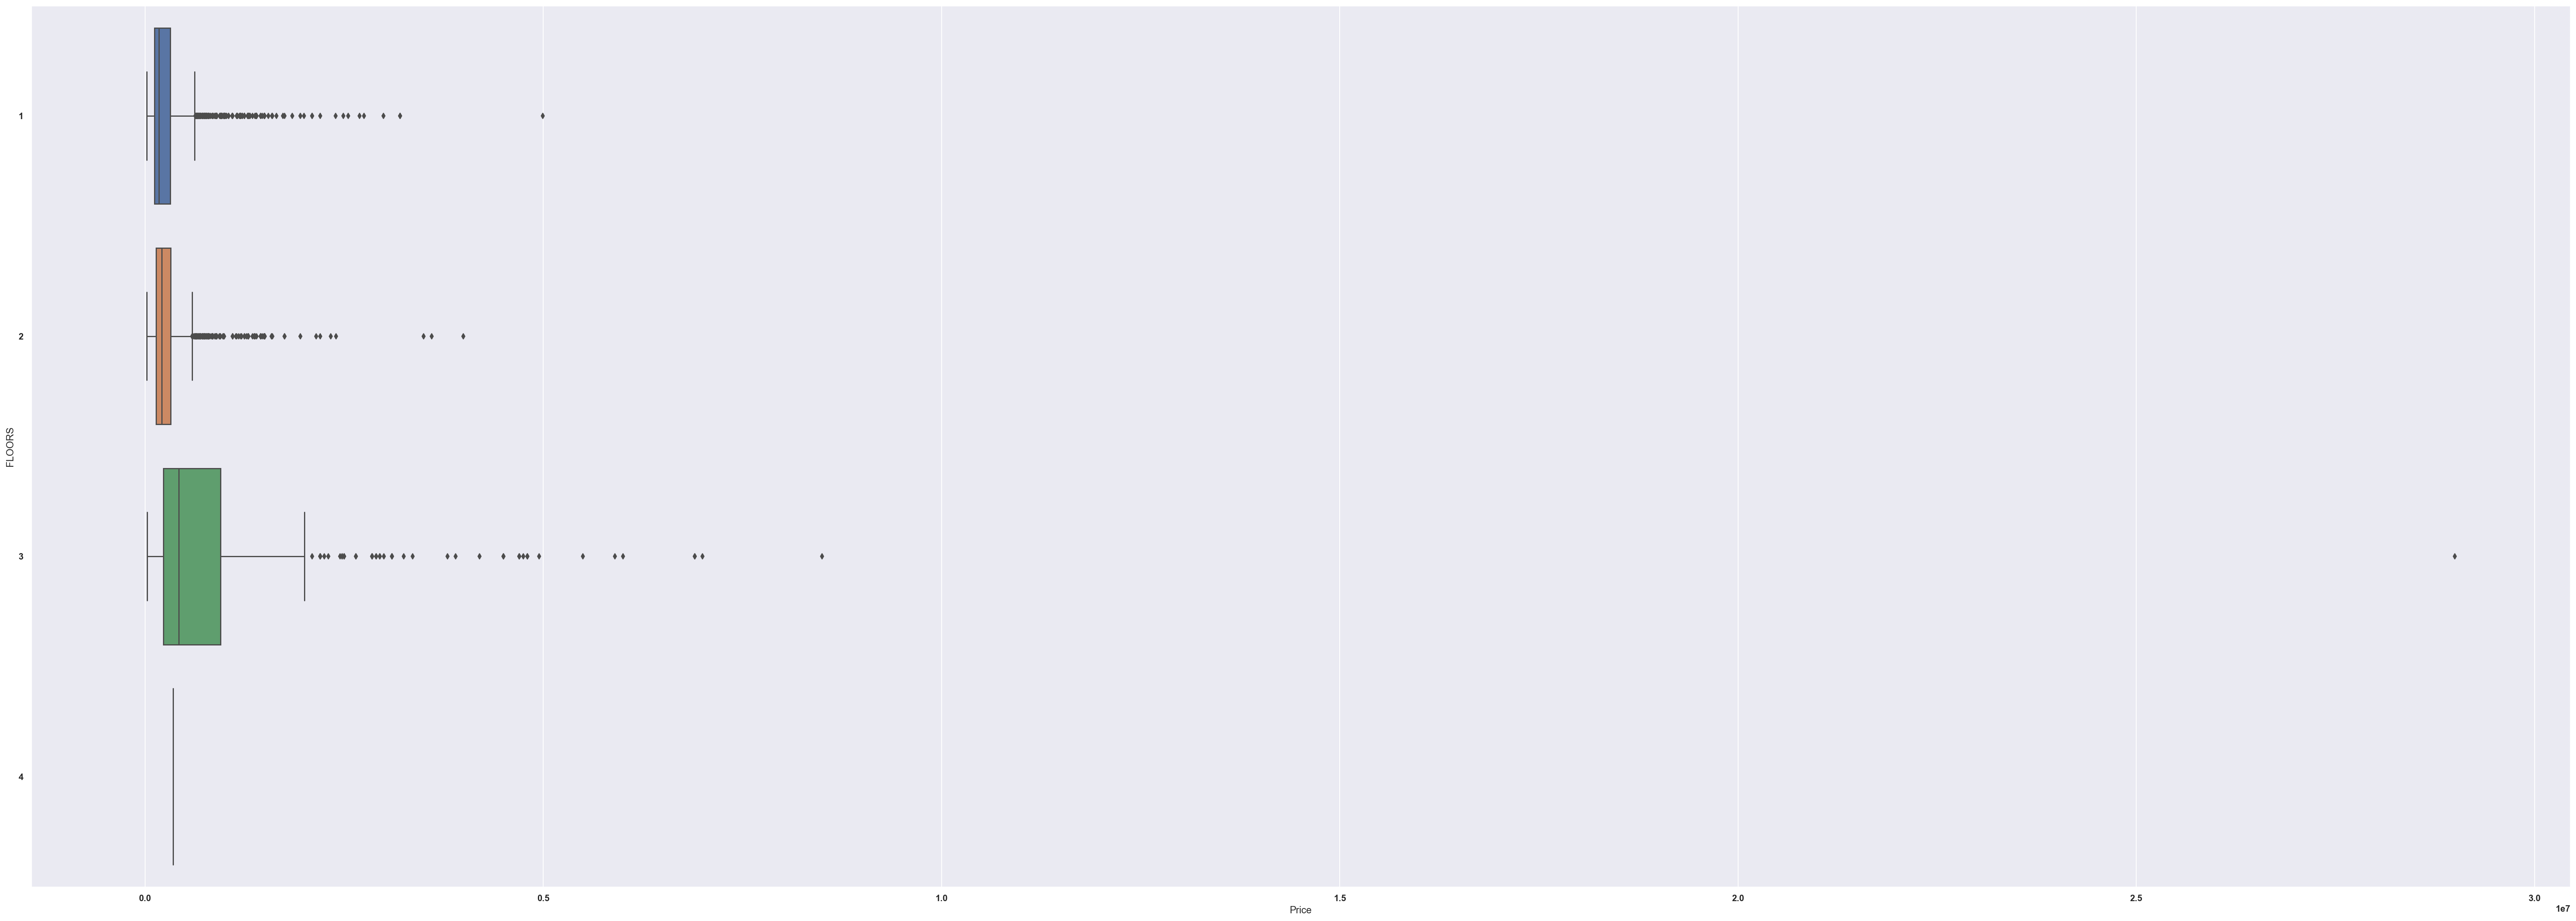

In [68]:
# Boxplot for the price per floors
fig, ax = plt.subplots(figsize=(50,20))
sns.boxplot(x='Price', y='FLOORS', data=df_housesNEW, orient='h', ax=ax)
plt.show()

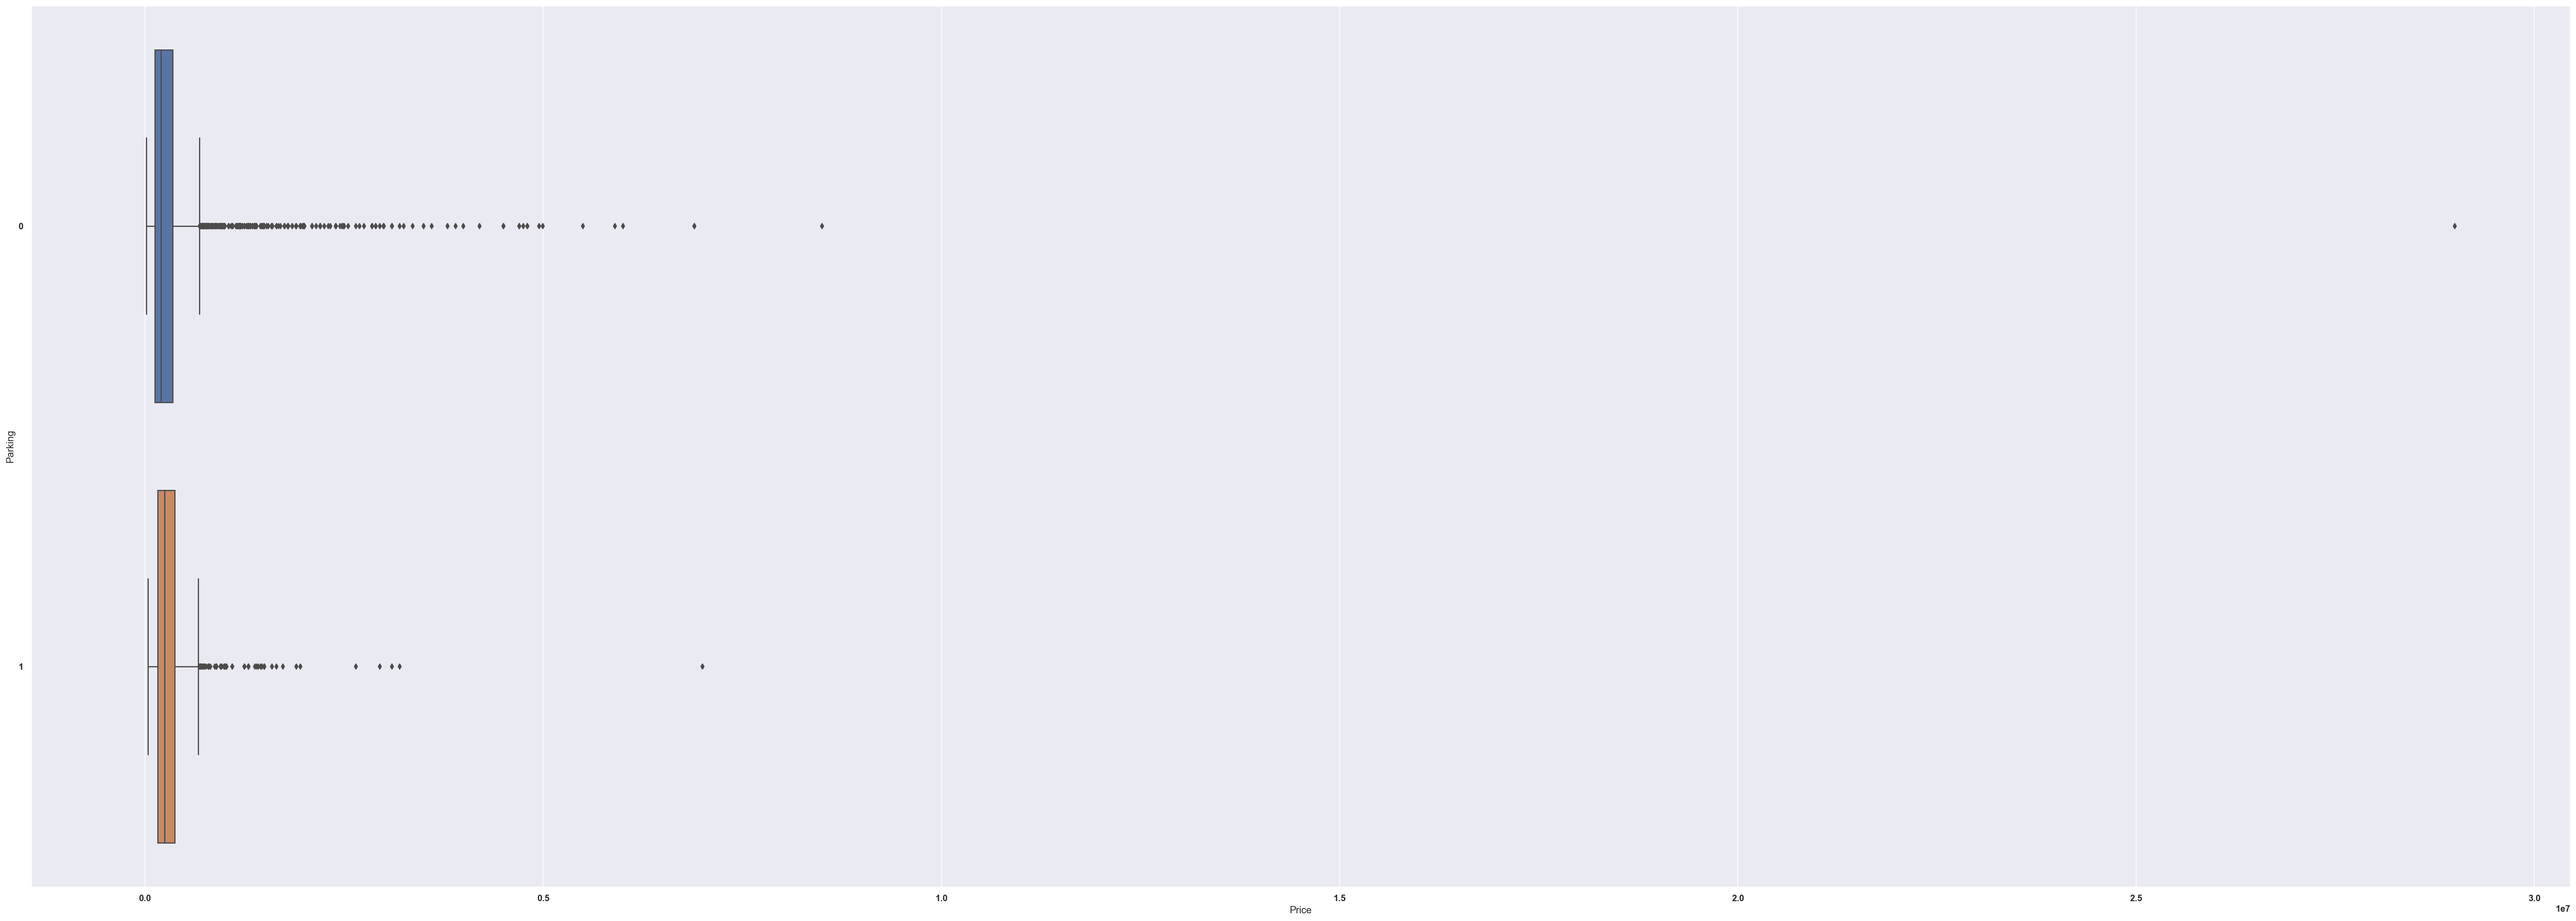

In [69]:
# Boxplot for the price per Parking
fig, ax = plt.subplots(figsize=(50,20))
sns.boxplot(x='Price', y='Parking', data=df_housesNEW, orient='h', ax=ax)
plt.show()

In [131]:
np.mean(df_housesNEW['Price'])

347209.67231638415

In [132]:
y=df_housesNEW['Price']

In [133]:
X=df_housesNEW.drop('Price', axis=1)

In [134]:
X=pd.get_dummies(X,drop_first=True)

In [135]:
X[:]

,FLOORS,Not_detached,m2,Plot,Bedrooms,Bathrooms,Parking,Garden,Type_estate_House,Type_estate_Villa
0,1,1,77.0,0.0,2,1.0,0,0,0,0
1,1,1,78.0,0.0,2,1.0,0,0,0,0
2,1,1,89.0,0.0,1,1.0,0,0,0,0
3,1,1,75.0,0.0,2,1.0,0,0,0,0
4,3,0,739.0,2000.0,5,7.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
5716,1,1,75.0,0.0,2,1.0,1,0,0,0
5717,1,1,109.0,0.0,3,2.0,1,1,0,0
5718,2,1,150.0,0.0,3,3.0,0,0,0,1
5719,1,1,153.0,0.0,3,2.0,1,1,0,0


In [136]:
col_mask=df_housesNEW.isnull().any(axis=0) 

In [137]:
row_mask=df_housesNEW.isnull().any(axis=1)

In [138]:
df_housesNEW.loc[row_mask,col_mask]

""


In [139]:
#df_housesNEW[df_housesNEW==np.inf]=np.nan
#df_housesNEW.fillna(df_housesNEW.mean(), inplace=True)

In [140]:
#df_housesNEW.fillna(df_housesNEW.mean(), inplace=True)

In [141]:
df_housesNEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4779 entries, 0 to 5720
Data columns (total 10 columns):
Type_estate     4779 non-null object
Price           4779 non-null float64
FLOORS          4779 non-null int64
Not_detached    4779 non-null int64
m2              4779 non-null float64
Plot            4779 non-null float64
Bedrooms        4779 non-null int64
Bathrooms       4779 non-null float64
Parking         4779 non-null int64
Garden          4779 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 570.7+ KB


In [142]:
#predictors = ['Type_estate','FLOORS', 'Not_detached', 'm2', 'Plot','Bathrooms','Parking','Bedrooms']

#X_train, X_test, y_train, y_test = train_test_split(X[predictors], y, 
#                                            test_size=0.5, random_state=8)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.5, random_state=8)

lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

lr.score(X_test, y_test)

0.27979958309907993

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                    y, test_size=0.2, random_state=8)

lr1 = linear_model.LinearRegression()

lr1.fit(X_train,y_train)

lr1.score(X_test, y_test)

0.3605741935824168

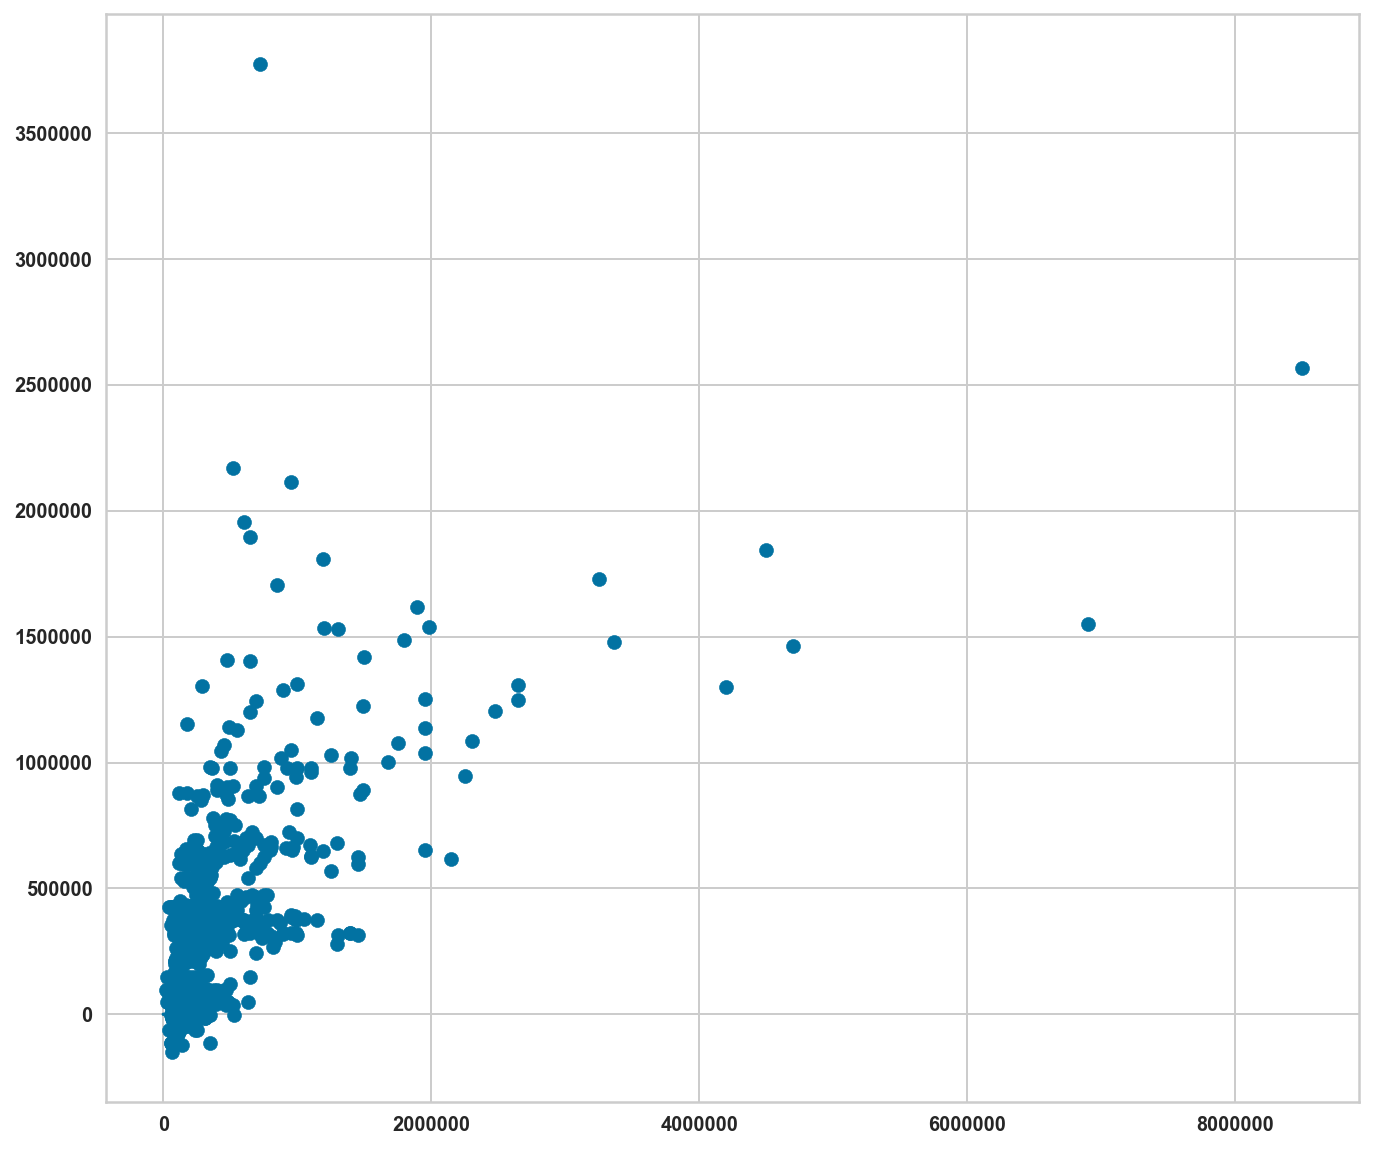

In [144]:
yhat = lr1.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat)
plt.plot([0,20],[0,20])
plt.show()

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                    y, test_size=0.1, random_state=8)

lr2 = linear_model.LinearRegression()

lr2.fit(X_train,y_train)

lr2.score(X_test, y_test)

0.27573711820121216

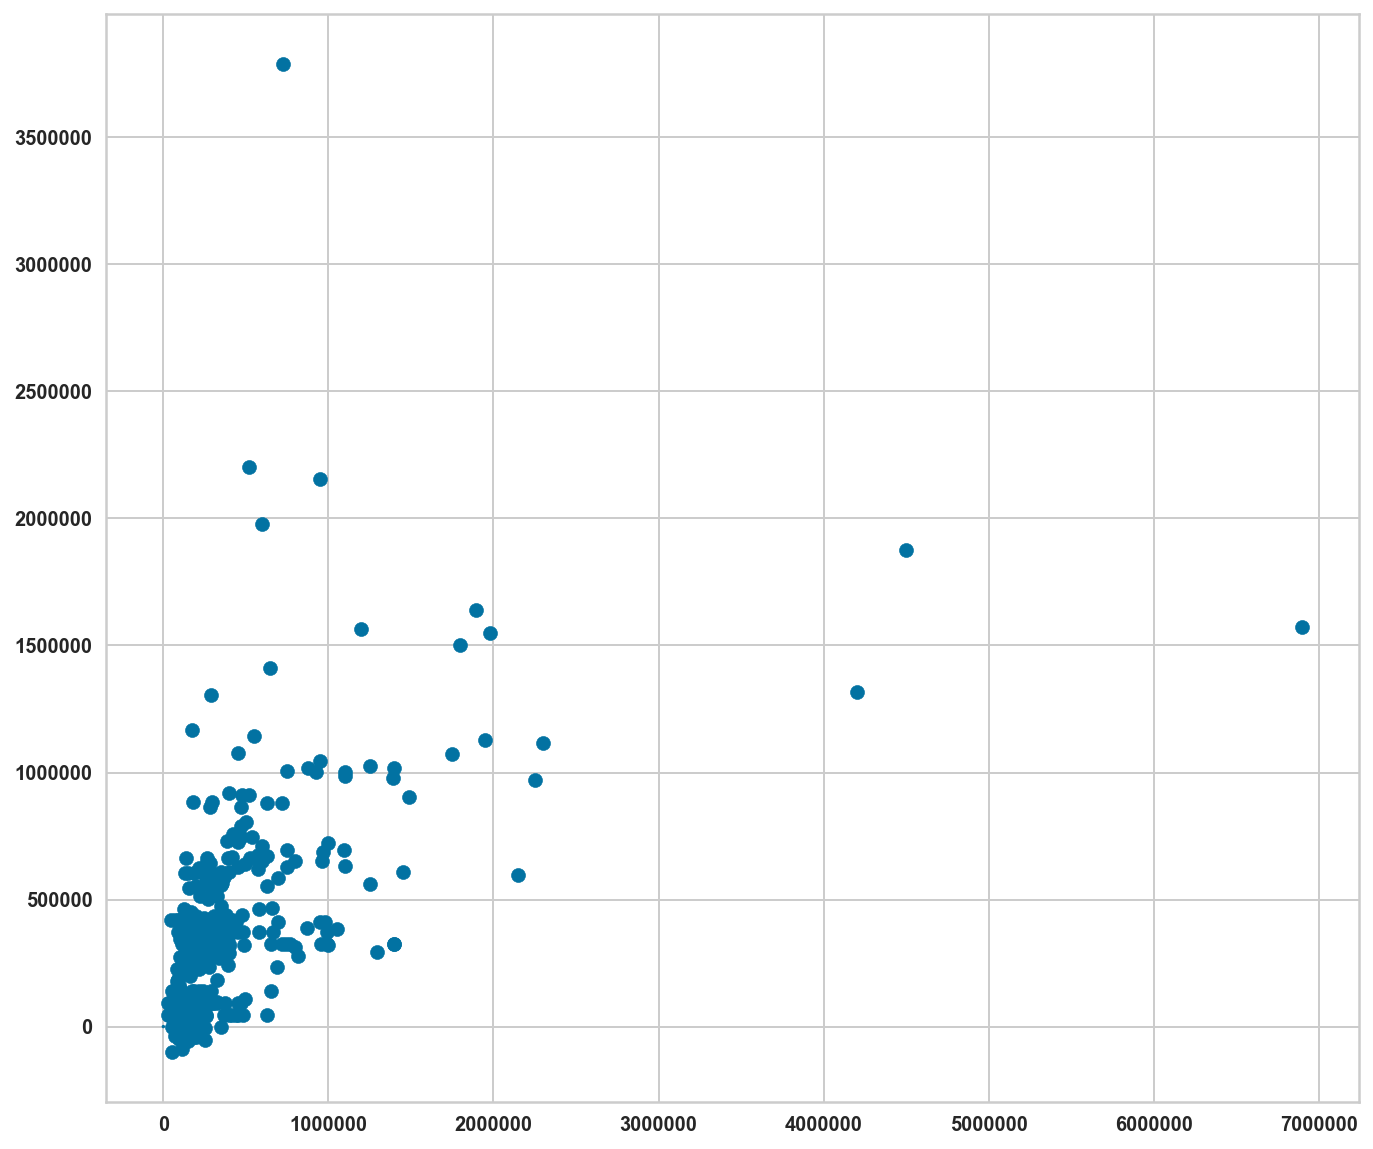

In [146]:
yhat = lr2.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat)
plt.plot([0,20],[0,20])
plt.show()

In [147]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics

In [148]:
# iterate through folds 5-10
for folds in range(5,11):
    
    kf = KFold(n_splits=folds,shuffle=True,random_state=1)
    
    print('------------------------------------\n')
    print('K:', folds)
    model = linear_model.LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

------------------------------------

K: 5
Cross-validated scores: [0.27795703 0.43952858 0.32614194 0.16823148 0.34771019]
Mean CV R2: 0.3119138440762799
Std CV R2: 0.08895732092034796
------------------------------------

K: 6
Cross-validated scores: [0.28416556 0.44112477 0.35796926 0.40253393 0.12699174 0.38092134]
Mean CV R2: 0.3322844354440084
Std CV R2: 0.10349475467641336
------------------------------------

K: 7
Cross-validated scores: [ 0.23843425  0.39306121  0.41351901  0.35127433  0.19531032 -0.40271933
  0.36595269]
Mean CV R2: 0.22211892553840243
Std CV R2: 0.2658227820316299
------------------------------------

K: 8
Cross-validated scores: [0.23585511 0.36052534 0.44187896 0.36013815 0.38253286 0.16310911
 0.23251168 0.38295432]
Mean CV R2: 0.3199381911994154
Std CV R2: 0.09036782378634955
------------------------------------

K: 9
Cross-validated scores: [0.18415612 0.33429173 0.49003357 0.3406555  0.37593022 0.41371258
 0.11600302 0.32669774 0.35578358]
Mean CV R2: 

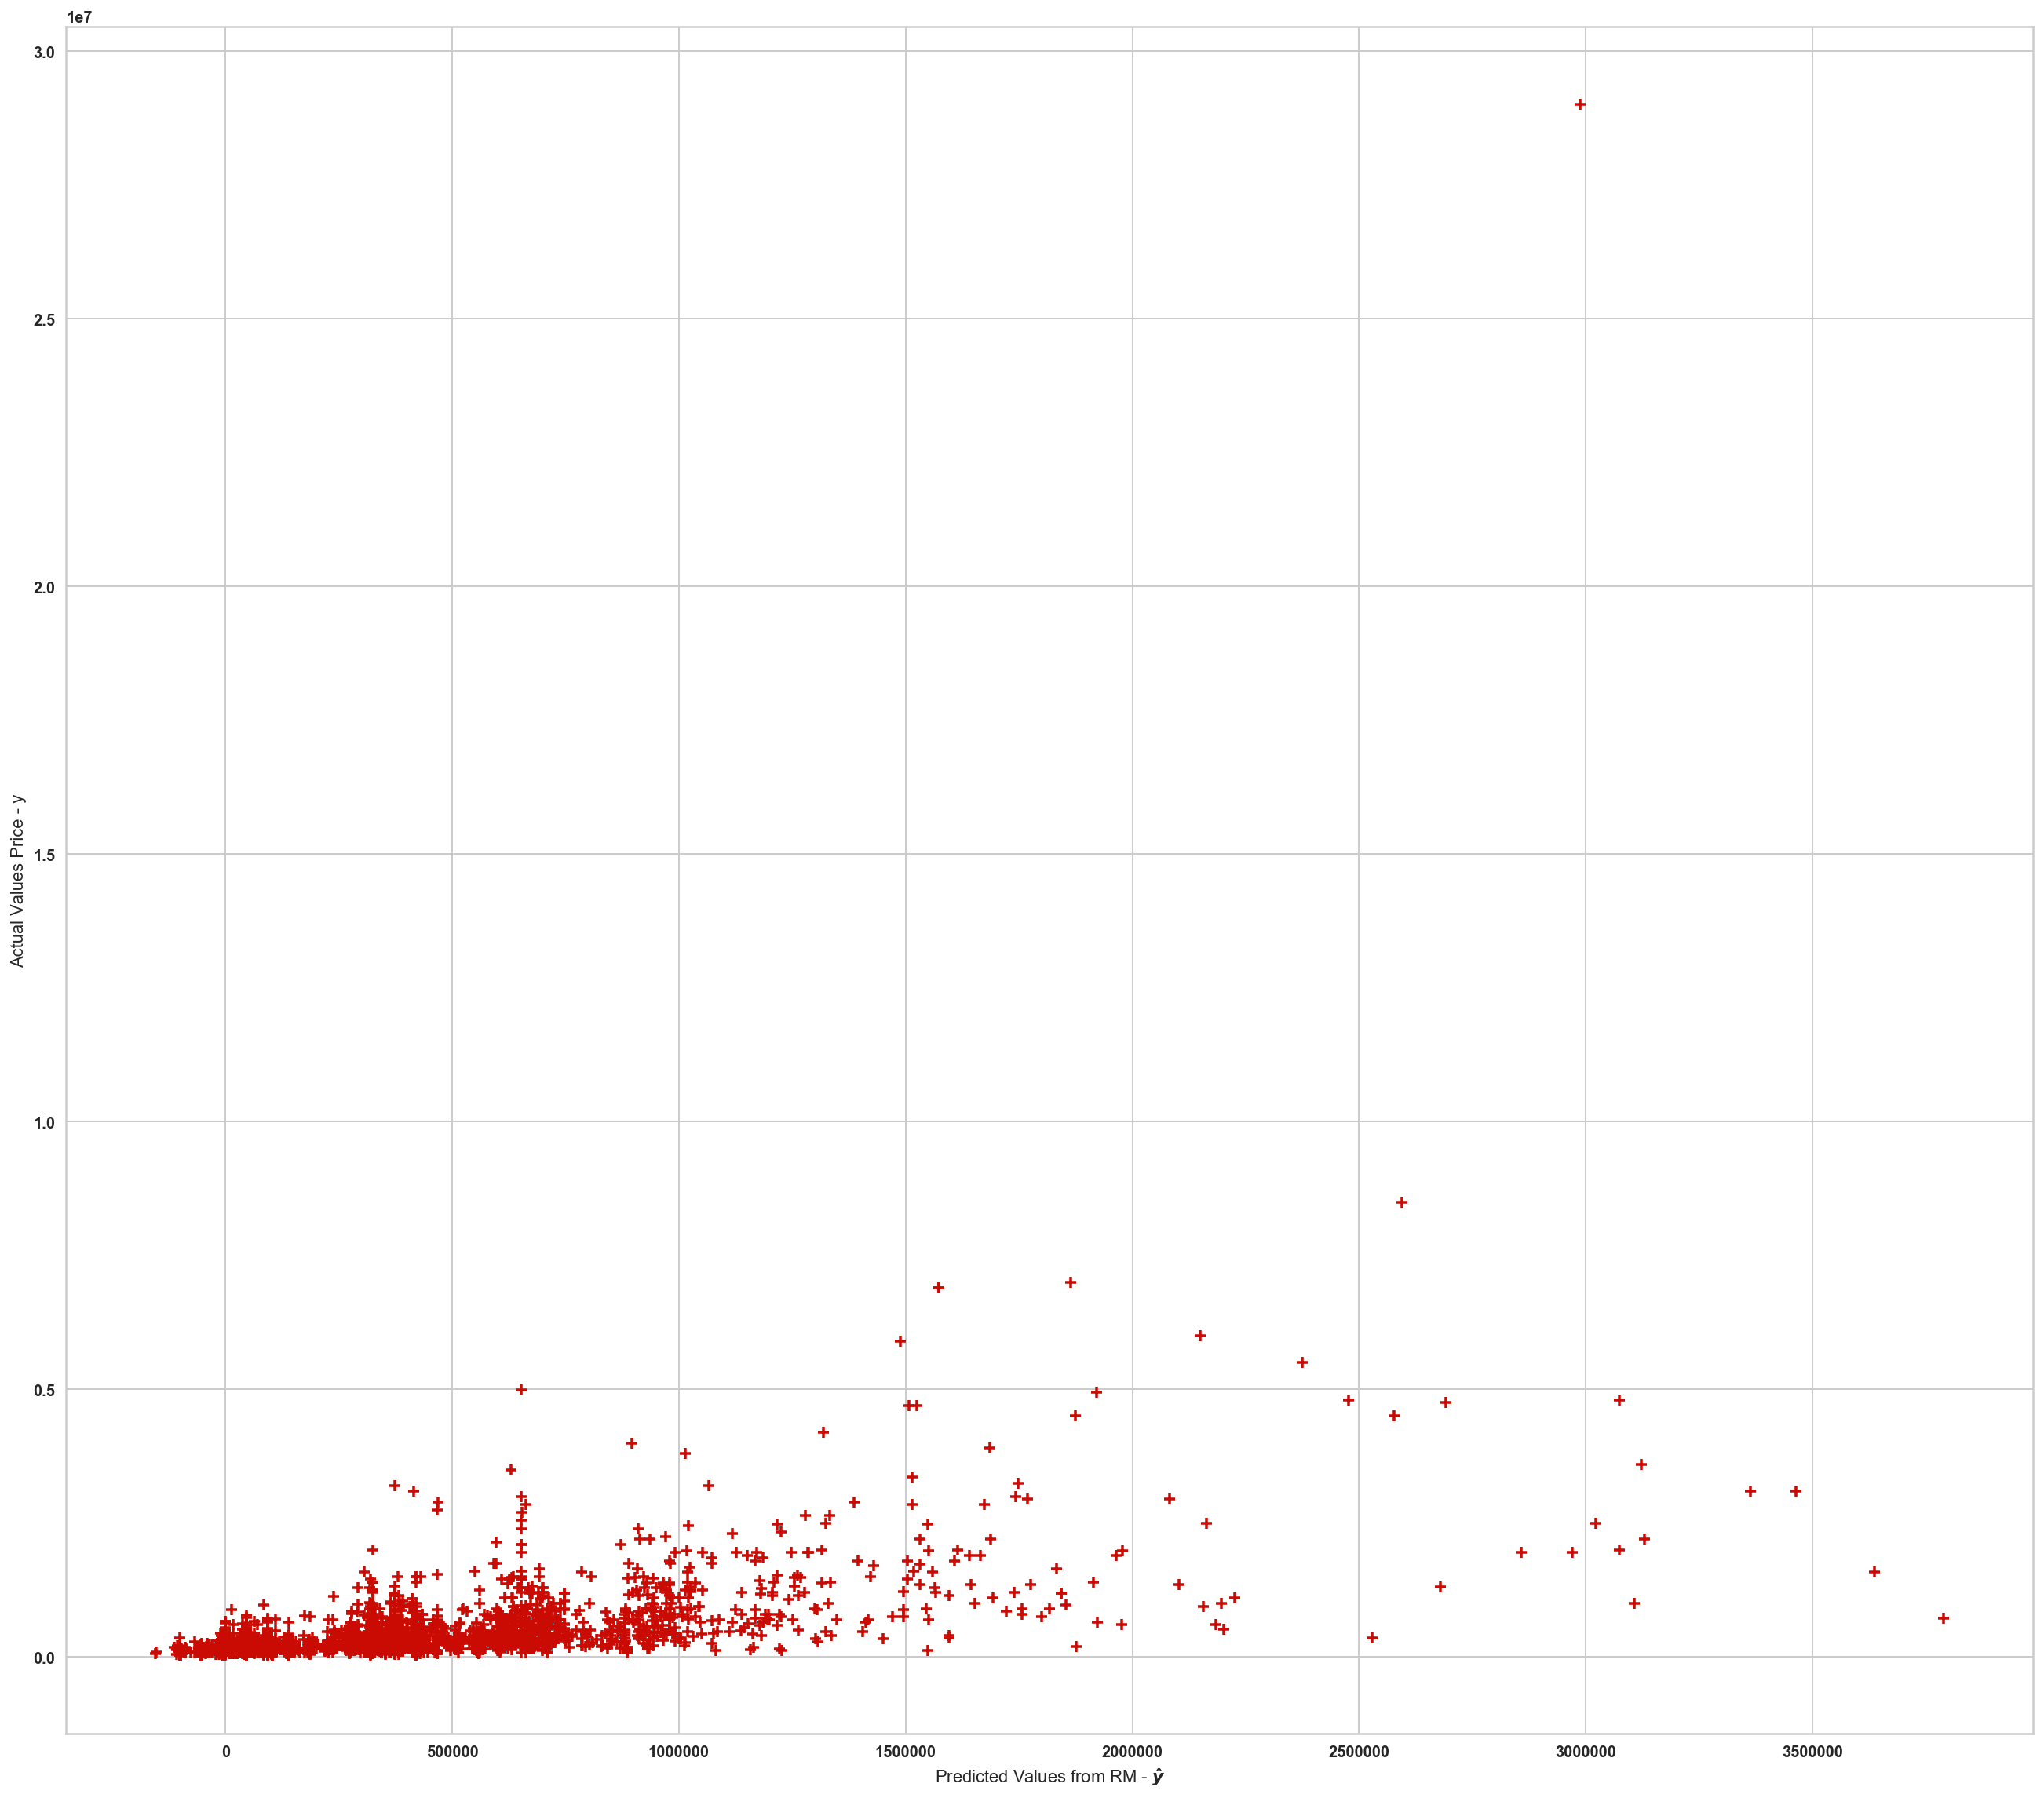

score:  0.29837045518377203


In [149]:
predictions  =  lr2.predict(X)
score        =  lr2.score(X, y)

# Plot the model
plt.figure(figsize=(20,20))
plt.scatter(predictions, y, s=50, c='r', marker='+', zorder=20)
plt.xlabel("Predicted Values from RM - $\hat{y}$")
plt.ylabel("Actual Values Price - y")
plt.show()

print ("score: ", score)

In [150]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = scaler.fit_transform(X)

# Standardization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are different sizes just because of the scale of predictor variables
# the regularization term can't determine which betas are more/less 
# important based on their size.

In [151]:
linreg = linear_model.LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[ 0.28739666  0.27433813  0.29092607  0.21972688 -1.0370035  -3.88097648
 -0.60054379 -0.04390244  0.18190375 -3.14486798]
-0.7453002699373985


In [152]:
predictions = cross_val_predict(linreg, Xs, y)
r2_score(y,predictions)

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.23629941535455712

In [153]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=2)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

91.15888299750823


In [154]:
optimal_ridge.score(Xs,y)

0.29871610053165887

In [155]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=2)

print(ridge_scores)
print(np.mean(ridge_scores))
predictions = cross_val_predict(ridge, Xs, y, cv=2)
print(r2_score(y,predictions))

[0.34942305 0.16439465]
0.25690884855182117
0.2543854492474099


In [156]:
# It's vastly better than the Linear Regression. 
# There is likely so much multicollinearity in the data that "vanilla" regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

In [157]:
# compare to ridge with optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(Xs,y)
print(ridge.score(Xs,y))

0.29871610053165887


In [158]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

24326.62800201641


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished


In [159]:
print(optimal_lasso.score(Xs,y))

0.2911732988447725


In [160]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))
predictions = cross_val_predict(lasso, Xs, y, cv=10)
print(r2_score(y,predictions))

[ 0.461516    0.35608842  0.26194461  0.28107045 -0.74501539 -3.49809445
 -0.49827976  0.05231993  0.17728753 -2.45486541]
-0.5606028075474703
0.2579218947744133


In [161]:
# The lasso performs slightly better than the Ridge, but similarly.
# Lasso deals primarily with the feature selection of valuable variables,
# eliminating ones that are not useful. This also takes care of multicollinearity,
# but in a different way: it will choose the "best" of the correlated variables
# and zero-out the other redundant ones.
# There may also be useless variables in the data which it is simply getting rid
# of entirely.

In [162]:
# compare to Lasso with optimal alpha
lasso.fit(Xs,y)
print(lasso.score(Xs,y))

0.2911732988447725


In [163]:
lasso.fit(Xs, y)

Lasso(alpha=24326.62800201641, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [164]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
5,Bathrooms,290194.582281,290194.582281
4,Bedrooms,39845.211896,39845.211896
3,Plot,35945.239081,35945.239081
8,Type_estate_House,-609.704117,609.704117
0,FLOORS,-0.000000,0.000000
1,Not_detached,0.000000,0.000000
2,m2,0.000000,0.000000
6,Parking,-0.000000,0.000000
7,Garden,0.000000,0.000000
9,Type_estate_Villa,0.000000,0.000000


In [165]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.0012554927809165098


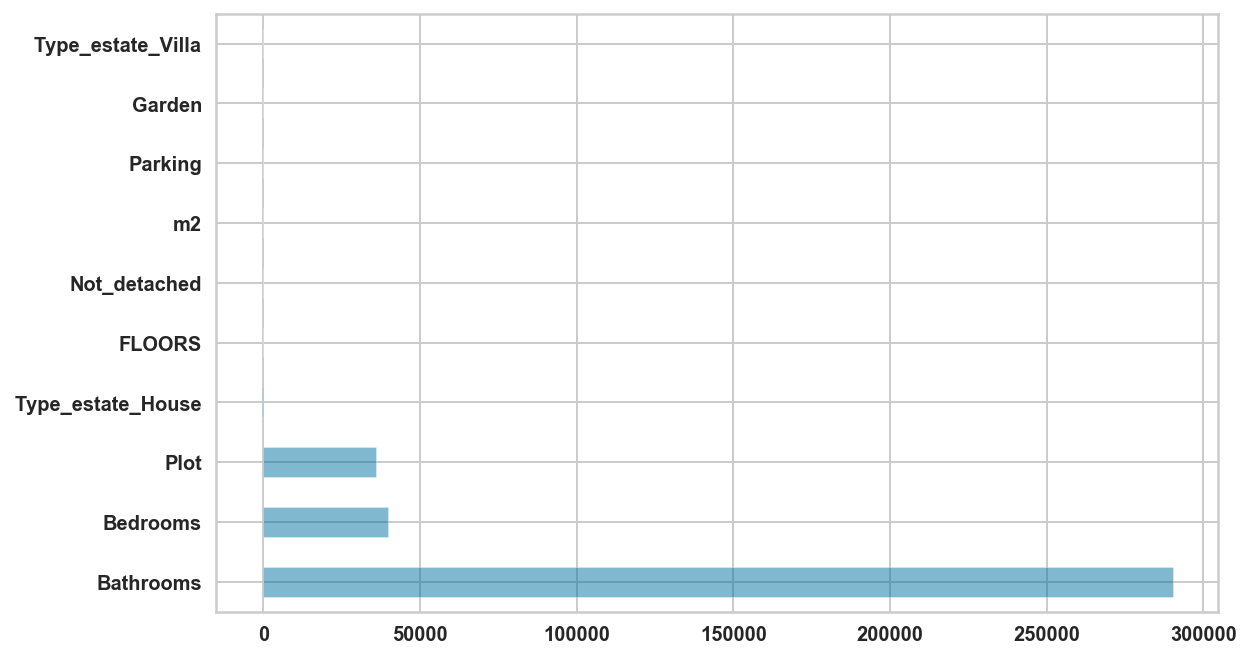

In [166]:
fig, ax = plt.subplots()
lasso_coefs.coef[:10].plot(kind='barh',ax=ax,alpha=0.5)
ax.set_yticklabels(lasso_coefs.variable[:10].values)
plt.show()

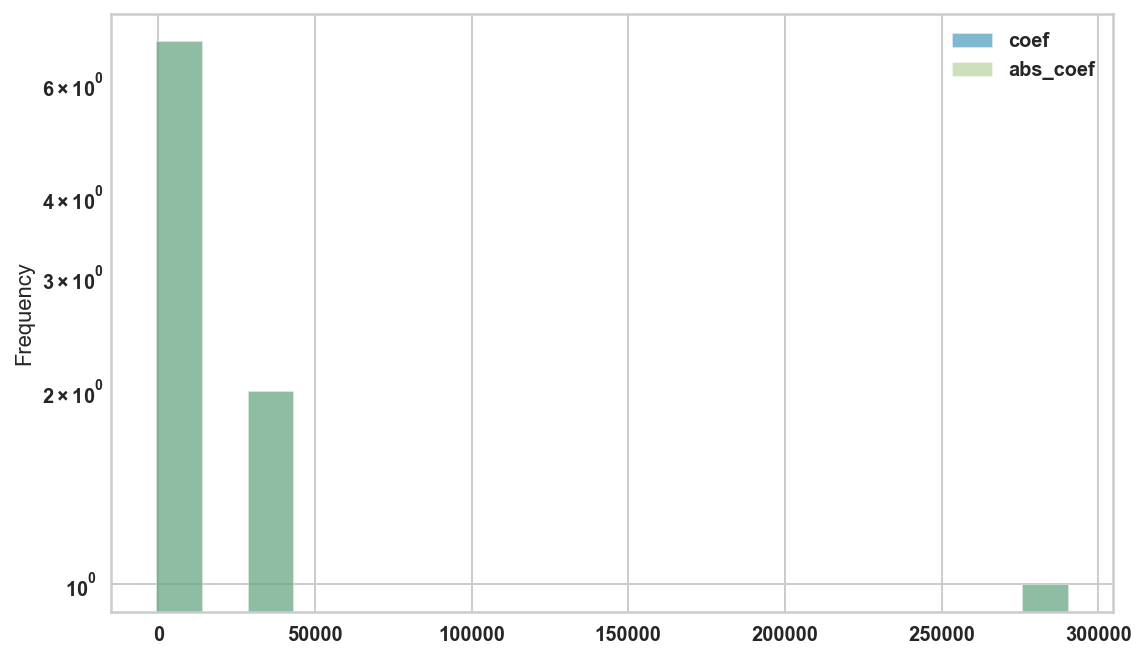

In [167]:
fig, ax = plt.subplots()
lasso_coefs.plot(kind='hist',bins=20,ax=ax,alpha=0.5)
ax.set_yscale('log')
plt.show()

In [168]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs, y)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

24147.00965244556
1.0


.........................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    7.8s finished


In [169]:
optimal_enet.score(Xs,y)

0.29125775528439124

In [170]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y, cv=10)

print(enet_scores)
print(np.mean(enet_scores))
predictions = cross_val_predict(enet,Xs,y,cv=10)
print(r2_score(y,predictions))

[ 0.46156522  0.35587913  0.26218167  0.28081336 -0.74674767 -3.5011938
 -0.4989098   0.05167585  0.17729757 -2.45727685]
-0.5614715318963842
0.25791408735673893


In [110]:
# compare to elastic net with optimal alpha and l1_ratio
enet.fit(Xs,y)
print(enet.score(Xs,y))

0.29125775528439124


In [111]:
# Need to fit the ElasticNet and Ridge outside of cross_val_score like done with the ridge
ridge.fit(Xs, y)
lasso.fit(Xs, y)

Lasso(alpha=24326.62800201641, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [112]:
# model residuals:

ridge_resid = y - ridge.predict(Xs)
lasso_resid = y - lasso.predict(Xs)


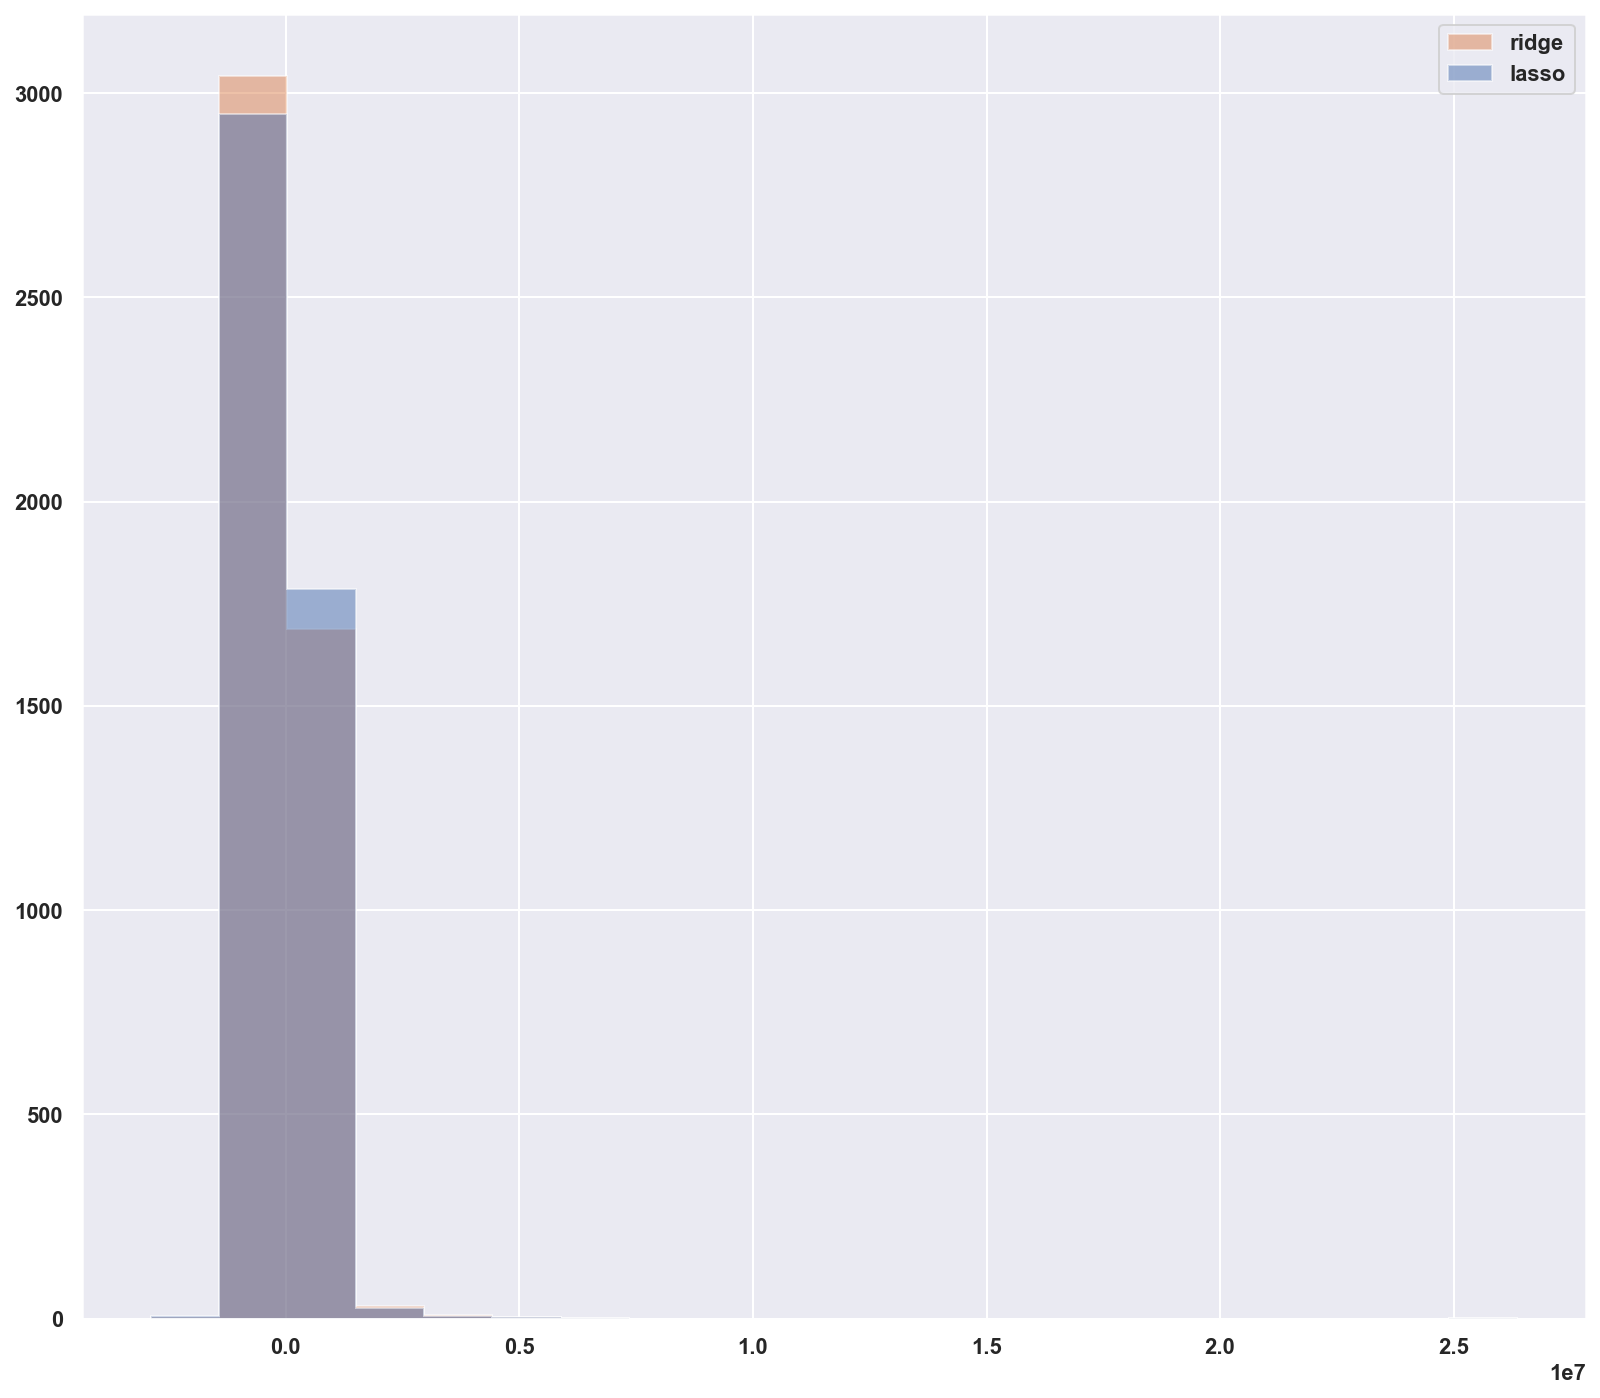

In [113]:
plt.hist([ridge_resid,lasso_resid],bins=20,histtype='stepfilled',alpha=0.5)
plt.legend(['ridge','lasso']);

In [121]:
### Second round
!pip install xgboost
!pip install yellowbrick

     |████████████████████████████████| 389kB 439kB/s eta 0:00:01


In [171]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import Ridge
from yellowbrick.regressor import PredictionError, ResidualsPlot

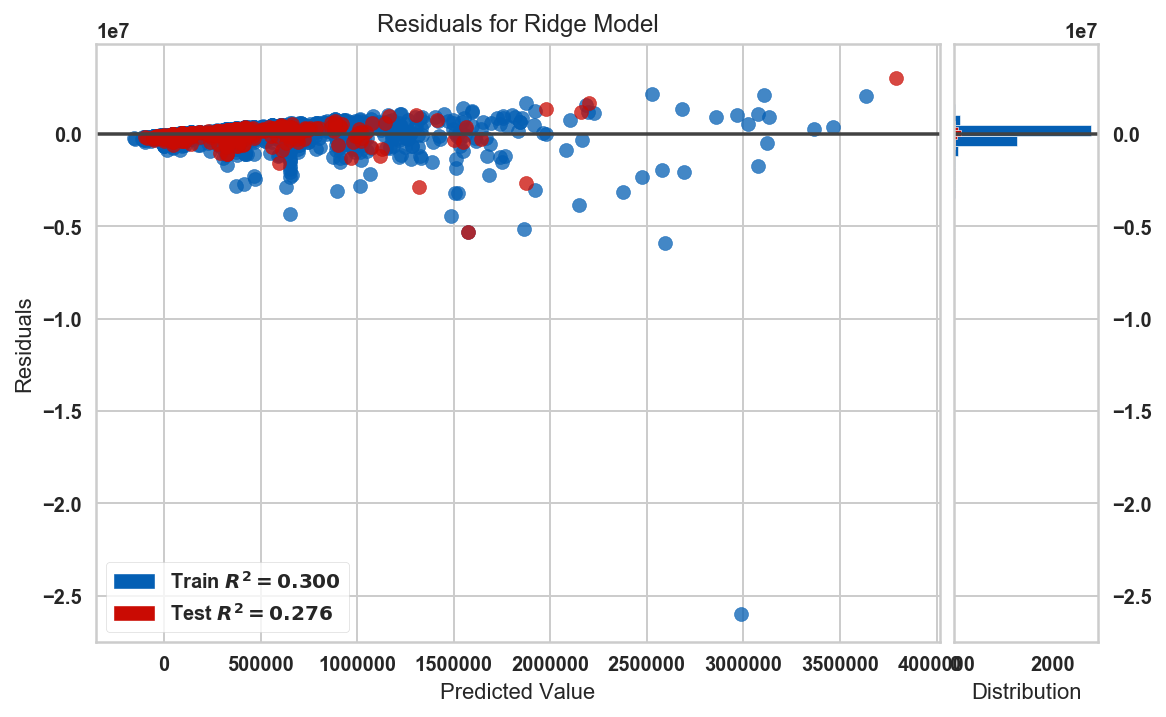

In [172]:
ridge = Ridge()
visualizer = ResidualsPlot(ridge, train_color='#045FB4', test_color='r', line_color='#424242')
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
g = visualizer.poof(outpath="residual_plot")

In [177]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [178]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[22:32:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [179]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 432454.421202


In [198]:
print(xg_reg.feature_importances_)

[0.13545294 0.0042644  0.22598974 0.18306813 0.07511662 0.229278
 0.03238082 0.01673653 0.01997994 0.07773286]


In [183]:
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  

In [187]:
from sklearn.model_selection import RandomizedSearchCV


In [188]:

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)  

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:43:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:43:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:43:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:44:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None, nthreads=-1,
                                          objective='reg:...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25613510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen 

In [189]:
gs

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None, nthreads=-1,
                                          objective='reg:...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25613510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen 

In [192]:
print(gs.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8557145863285183,
             gamma=6.297276340470472, importance_type='gain',
             learning_rate=0.21040491054785926, max_delta_step=0, max_depth=39,
             min_child_weight=22.492544219379525, missing=None, n_estimators=28,
             n_jobs=1, nthread=None, nthreads=-1, objective='reg:linear',
             random_state=0, reg_alpha=202.08163533745426, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.9500189478992453, verbosity=1)


In [193]:
print(gs.best_score_)

0.4380341466329577


# Let's do the whole cycle again using only few features


In [199]:
df_housesNEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4779 entries, 0 to 5720
Data columns (total 10 columns):
Type_estate     4779 non-null object
Price           4779 non-null float64
FLOORS          4779 non-null int64
Not_detached    4779 non-null int64
m2              4779 non-null float64
Plot            4779 non-null float64
Bedrooms        4779 non-null int64
Bathrooms       4779 non-null float64
Parking         4779 non-null int64
Garden          4779 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 570.7+ KB


In [200]:
y=df_housesNEW['Price']

X=df_housesNEW.drop('Price', axis=1)

X=pd.get_dummies(X,drop_first=True)

In [202]:
X.head()

,FLOORS,Not_detached,m2,Plot,Bedrooms,Bathrooms,Parking,Garden,Type_estate_House,Type_estate_Villa
0,1,1,77.0,0.0,2,1.0,0,0,0,0
1,1,1,78.0,0.0,2,1.0,0,0,0,0
2,1,1,89.0,0.0,1,1.0,0,0,0,0
3,1,1,75.0,0.0,2,1.0,0,0,0,0
4,3,0,739.0,2000.0,5,7.0,0,0,1,0


In [338]:
predictors = ['Type_estate_House','Plot', 'Bedrooms', 'Bathrooms']
#predictors = ['Plot', 'Bedrooms', 'Bathrooms']

X_train, X_test, y_train, y_test = train_test_split(X[predictors], y, 
                                            test_size=0.5, random_state=8)
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                            test_size=0.5, random_state=8)

lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

lr.score(X_test, y_test)

0.38649483166693255

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                    y, test_size=0.2, random_state=8)

lr1 = linear_model.LinearRegression()

lr1.fit(X_train,y_train)

lr1.score(X_test, y_test)

0.3605741935824168

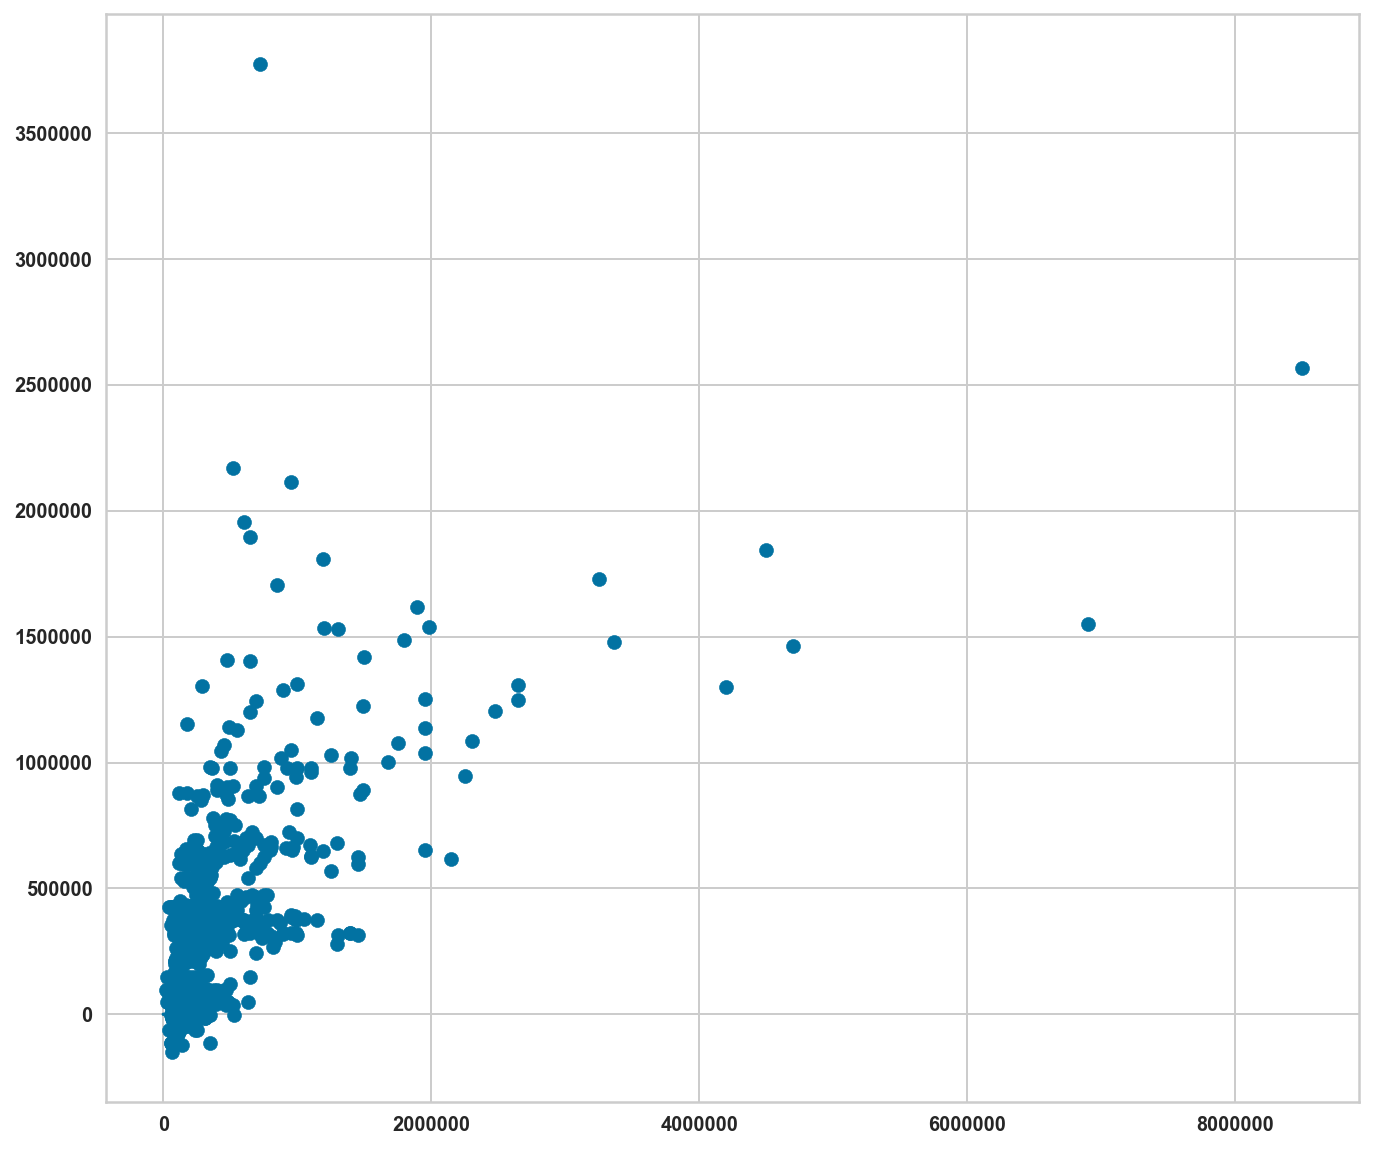

In [340]:
yhat = lr1.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat)
plt.plot([0,20],[0,20])
plt.show()

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                    y, test_size=0.1, random_state=8)

lr2 = linear_model.LinearRegression()

lr2.fit(X_train,y_train)

lr2.score(X_test, y_test)

0.27573711820121216

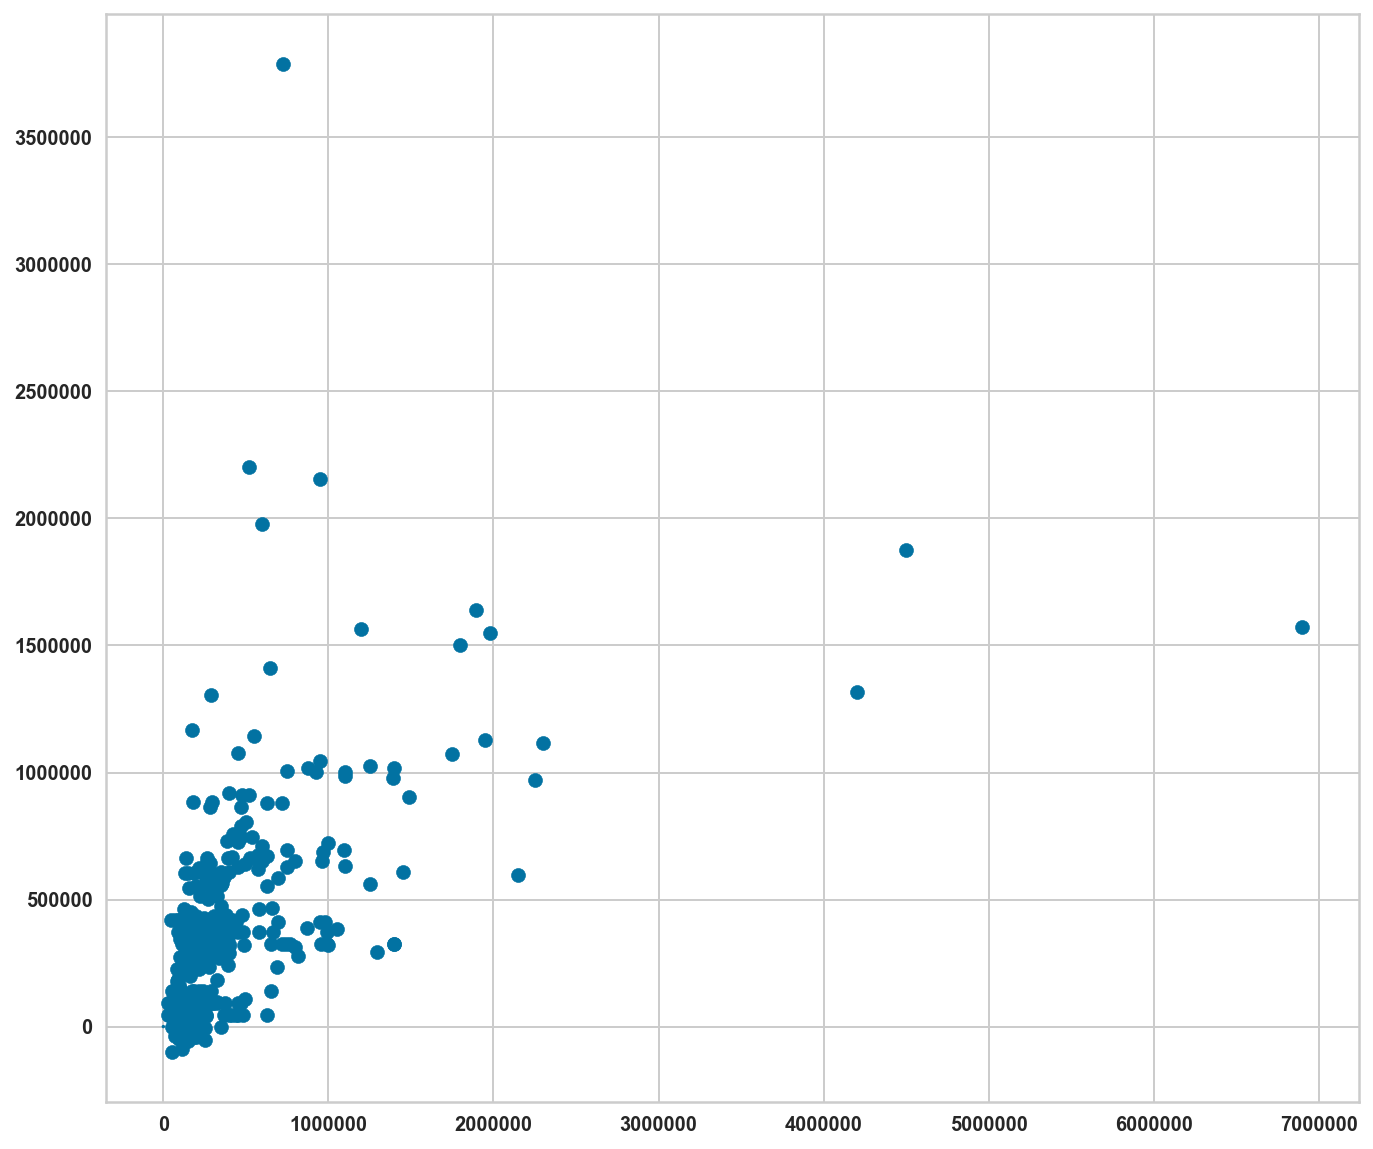

In [342]:
yhat = lr2.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat)
plt.plot([0,20],[0,20])
plt.show()

In [343]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics

In [344]:
# iterate through folds 5-10
for folds in range(5,11):
    
    kf = KFold(n_splits=folds,shuffle=True,random_state=1)
    
    print('------------------------------------\n')
    print('K:', folds)
    model = linear_model.LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

------------------------------------

K: 5
Cross-validated scores: [0.27795703 0.43952858 0.32614194 0.16823148 0.34771019]
Mean CV R2: 0.3119138440762799
Std CV R2: 0.08895732092034796
------------------------------------

K: 6
Cross-validated scores: [0.28416556 0.44112477 0.35796926 0.40253393 0.12699174 0.38092134]
Mean CV R2: 0.3322844354440084
Std CV R2: 0.10349475467641336
------------------------------------

K: 7
Cross-validated scores: [ 0.23843425  0.39306121  0.41351901  0.35127433  0.19531032 -0.40271933
  0.36595269]
Mean CV R2: 0.22211892553840243
Std CV R2: 0.2658227820316299
------------------------------------

K: 8
Cross-validated scores: [0.23585511 0.36052534 0.44187896 0.36013815 0.38253286 0.16310911
 0.23251168 0.38295432]
Mean CV R2: 0.3199381911994154
Std CV R2: 0.09036782378634955
------------------------------------

K: 9
Cross-validated scores: [0.18415612 0.33429173 0.49003357 0.3406555  0.37593022 0.41371258
 0.11600302 0.32669774 0.35578358]
Mean CV R2: 

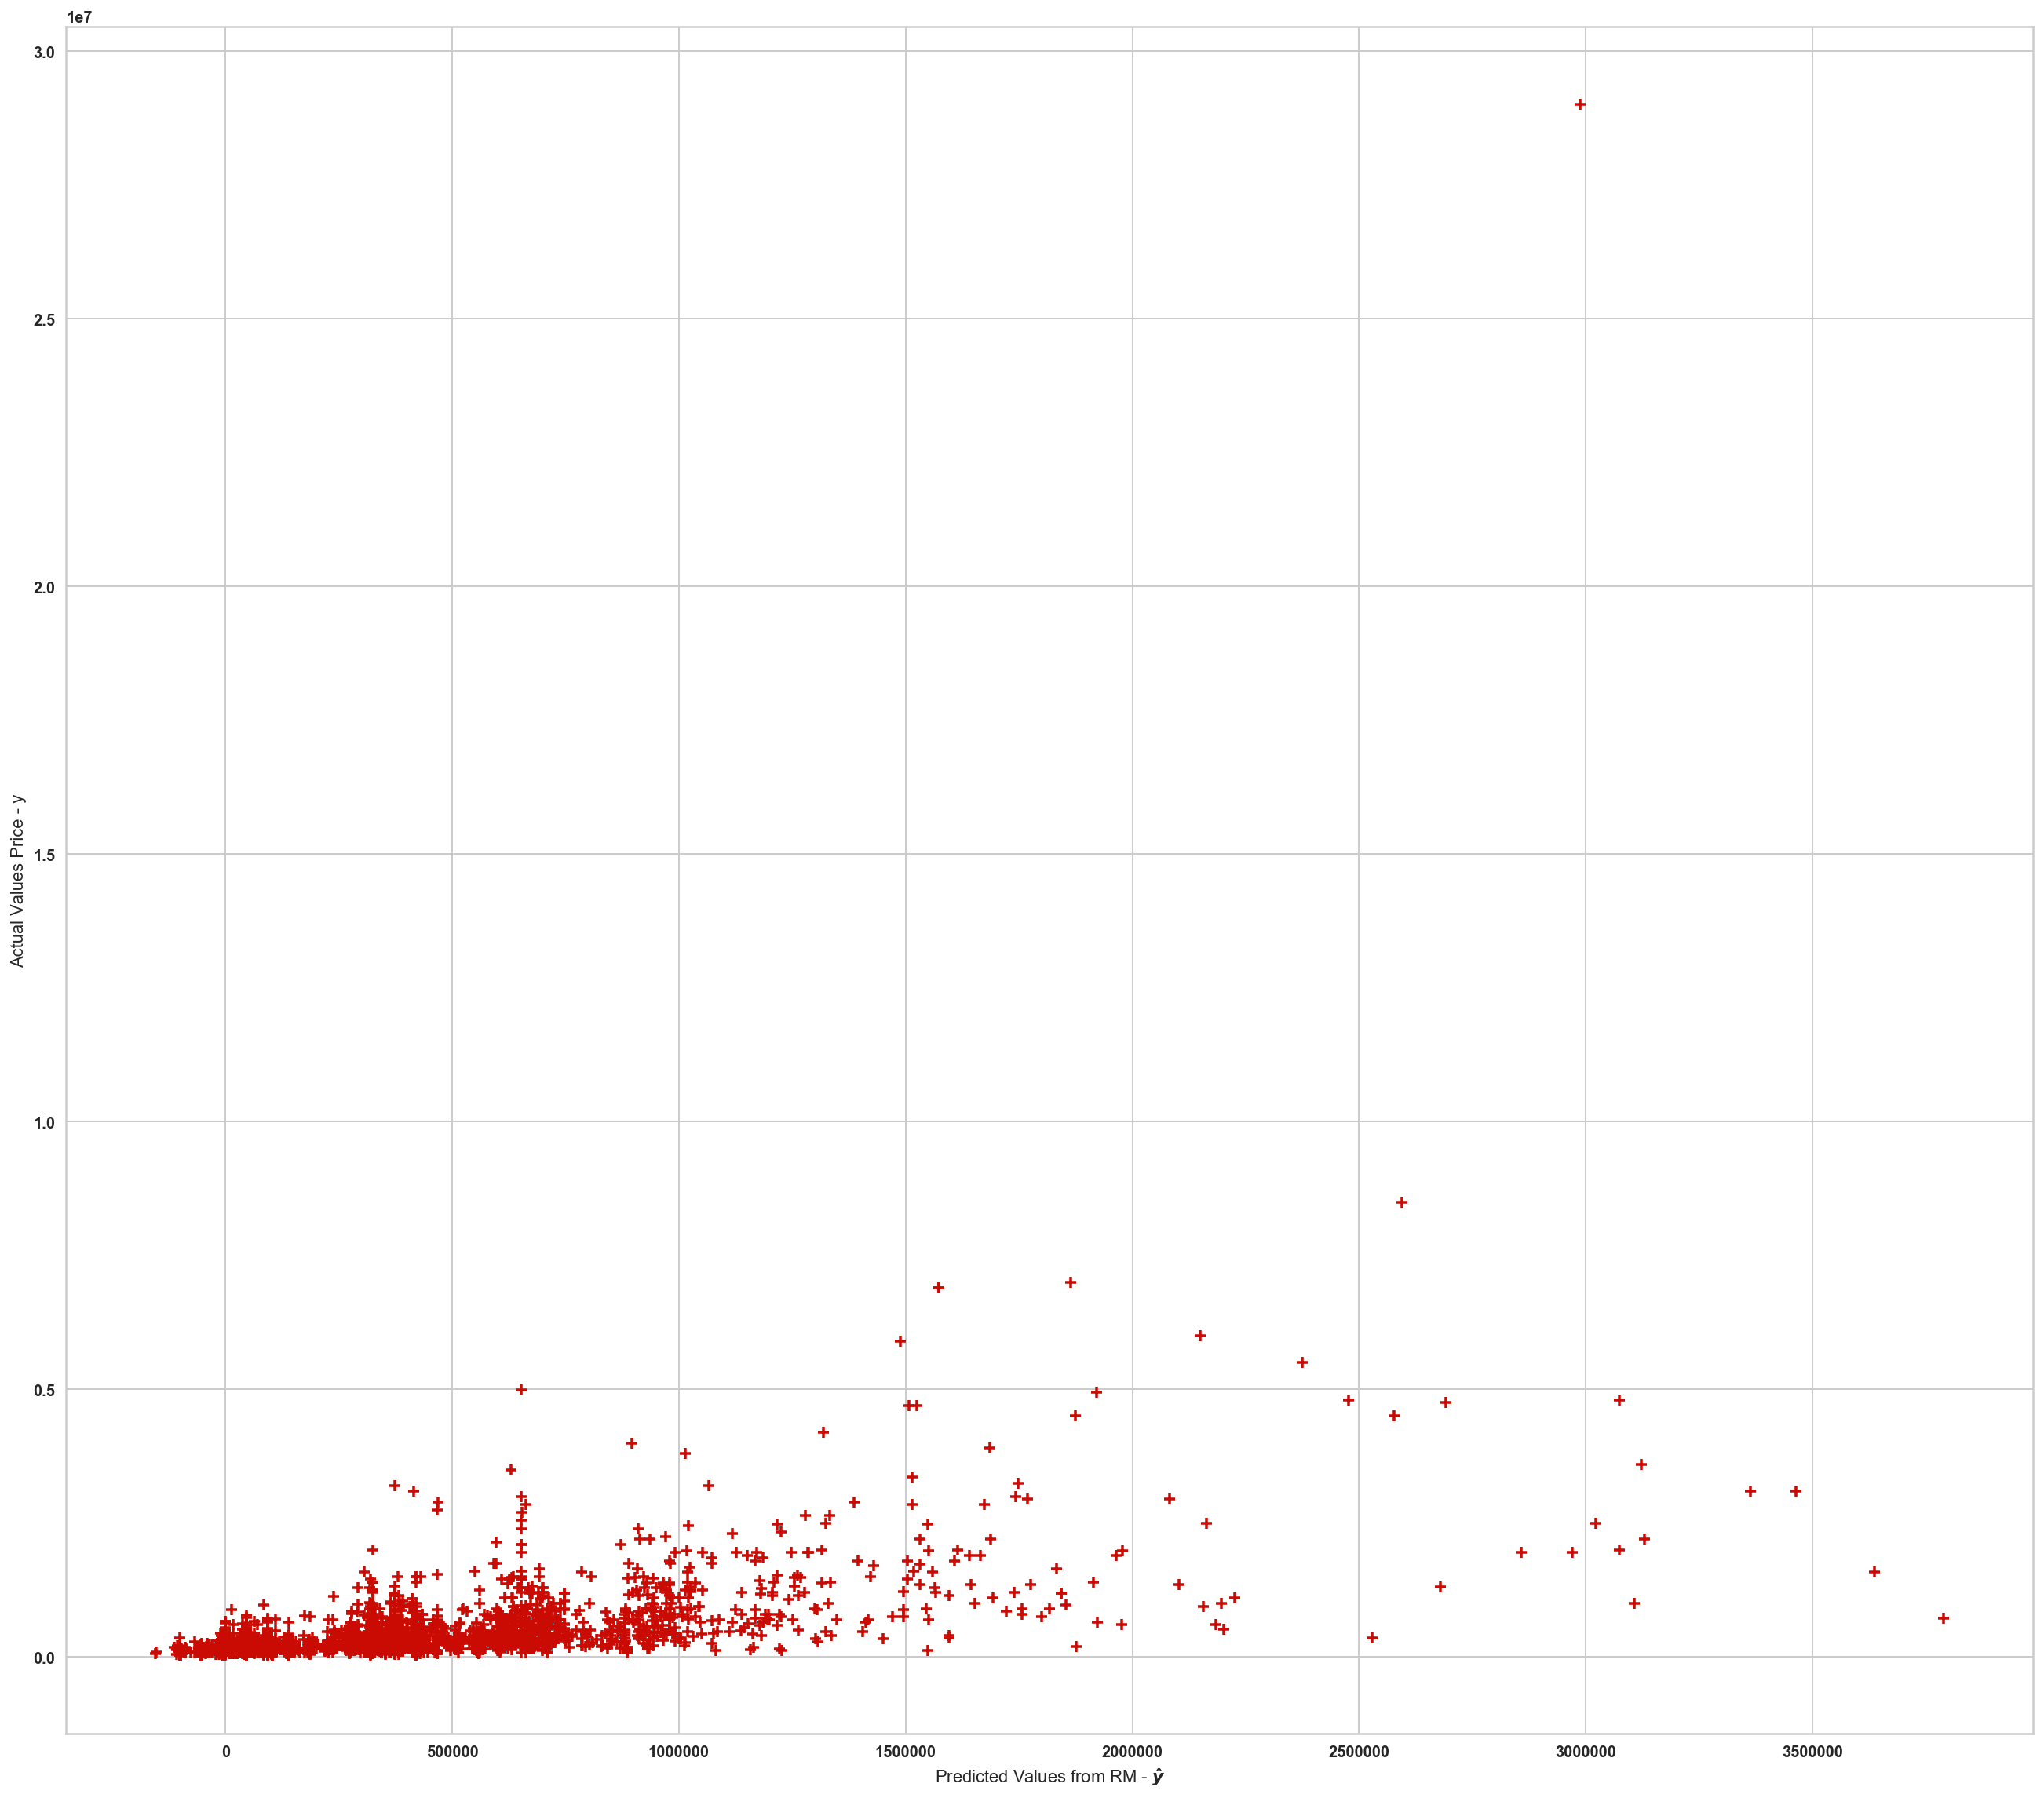

score:  0.29837045518377203


In [345]:
predictions  =  lr2.predict(X)
score        =  lr2.score(X, y)

# Plot the model
plt.figure(figsize=(20,20))
plt.scatter(predictions, y, s=50, c='r', marker='+', zorder=20)
plt.xlabel("Predicted Values from RM - $\hat{y}$")
plt.ylabel("Actual Values Price - y")
plt.show()

print ("score: ", score)

In [346]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = scaler.fit_transform(X)

# Standardization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are different sizes just because of the scale of predictor variables
# the regularization term can't determine which betas are more/less 
# important based on their size.

In [347]:
linreg = linear_model.LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[ 0.28739666  0.27433813  0.29092607  0.21972688 -1.0370035  -3.88097648
 -0.60054379 -0.04390244  0.18190375 -3.14486798]
-0.7453002699373985


In [348]:
predictions = cross_val_predict(linreg, Xs, y)
r2_score(y,predictions)

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.23629941535455712

In [349]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=2)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

91.15888299750823


In [350]:
optimal_ridge.score(Xs,y)

0.29871610053165887

In [351]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=2)

print(ridge_scores)
print(np.mean(ridge_scores))
predictions = cross_val_predict(ridge, Xs, y, cv=2)
print(r2_score(y,predictions))

[0.34942305 0.16439465]
0.25690884855182117
0.2543854492474099


In [352]:
# It's vastly better than the Linear Regression. 
# There is likely so much multicollinearity in the data that "vanilla" regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

In [353]:
# compare to ridge with optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(Xs,y)
print(ridge.score(Xs,y))

0.29871610053165887


In [354]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

24326.62800201641


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished


In [355]:
print(optimal_lasso.score(Xs,y))

0.2911732988447725


In [356]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))
predictions = cross_val_predict(lasso, Xs, y, cv=10)
print(r2_score(y,predictions))

[ 0.461516    0.35608842  0.26194461  0.28107045 -0.74501539 -3.49809445
 -0.49827976  0.05231993  0.17728753 -2.45486541]
-0.5606028075474703
0.2579218947744133


In [357]:
# The lasso performs slightly better than the Ridge, but similarly.
# Lasso deals primarily with the feature selection of valuable variables,
# eliminating ones that are not useful. This also takes care of multicollinearity,
# but in a different way: it will choose the "best" of the correlated variables
# and zero-out the other redundant ones.
# There may also be useless variables in the data which it is simply getting rid
# of entirely.

In [358]:
# compare to Lasso with optimal alpha
lasso.fit(Xs,y)
print(lasso.score(Xs,y))

0.2911732988447725


In [359]:
lasso.fit(Xs, y)

Lasso(alpha=24326.62800201641, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [360]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
5,Bathrooms,290194.582281,290194.582281
4,Bedrooms,39845.211896,39845.211896
3,Plot,35945.239081,35945.239081
8,Type_estate_House,-609.704117,609.704117
0,FLOORS,-0.000000,0.000000
1,Not_detached,0.000000,0.000000
2,m2,0.000000,0.000000
6,Parking,-0.000000,0.000000
7,Garden,0.000000,0.000000
9,Type_estate_Villa,0.000000,0.000000


In [361]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.0012554927809165098


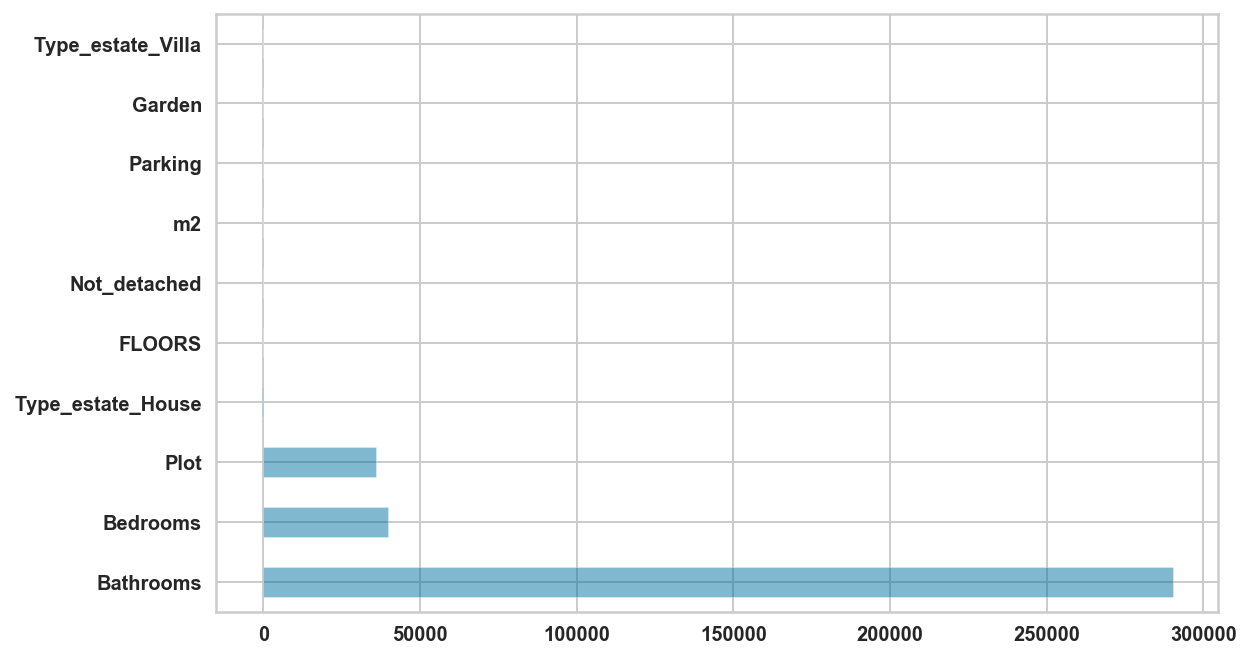

In [362]:
fig, ax = plt.subplots()
lasso_coefs.coef[:10].plot(kind='barh',ax=ax,alpha=0.5)
ax.set_yticklabels(lasso_coefs.variable[:10].values)
plt.show()

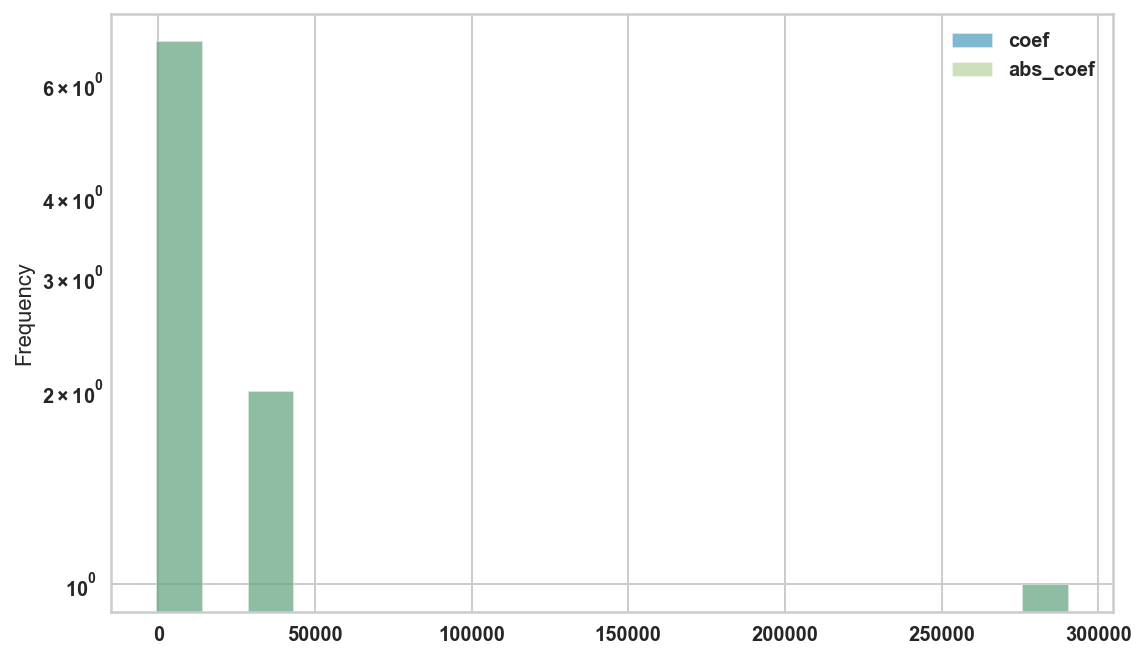

In [363]:
fig, ax = plt.subplots()
lasso_coefs.plot(kind='hist',bins=20,ax=ax,alpha=0.5)
ax.set_yscale('log')
plt.show()

In [364]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs, y)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

24147.00965244556
1.0


......................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    8.3s finished


In [365]:
optimal_enet.score(Xs,y)

0.29125775528439124

In [366]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y, cv=10)

print(enet_scores)
print(np.mean(enet_scores))
predictions = cross_val_predict(enet,Xs,y,cv=10)
print(r2_score(y,predictions))

[ 0.46156522  0.35587913  0.26218167  0.28081336 -0.74674767 -3.5011938
 -0.4989098   0.05167585  0.17729757 -2.45727685]
-0.5614715318963842
0.25791408735673893


In [367]:
# compare to elastic net with optimal alpha and l1_ratio
enet.fit(Xs,y)
print(enet.score(Xs,y))

0.29125775528439124


In [368]:
# Need to fit the ElasticNet and Ridge outside of cross_val_score like done with the ridge
ridge.fit(Xs, y)
lasso.fit(Xs, y)

Lasso(alpha=24326.62800201641, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [369]:
# model residuals:

ridge_resid = y - ridge.predict(Xs)
lasso_resid = y - lasso.predict(Xs)


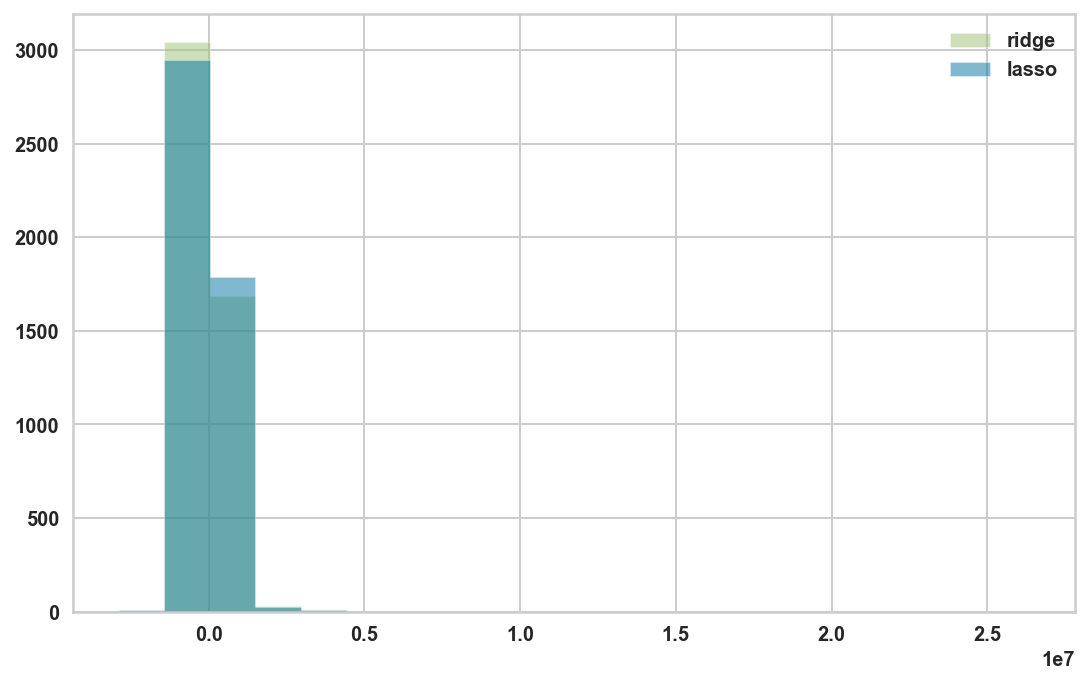

In [370]:
plt.hist([ridge_resid,lasso_resid],bins=20,histtype='stepfilled',alpha=0.5)
plt.legend(['ridge','lasso']);

In [371]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import Ridge
from yellowbrick.regressor import PredictionError, ResidualsPlot

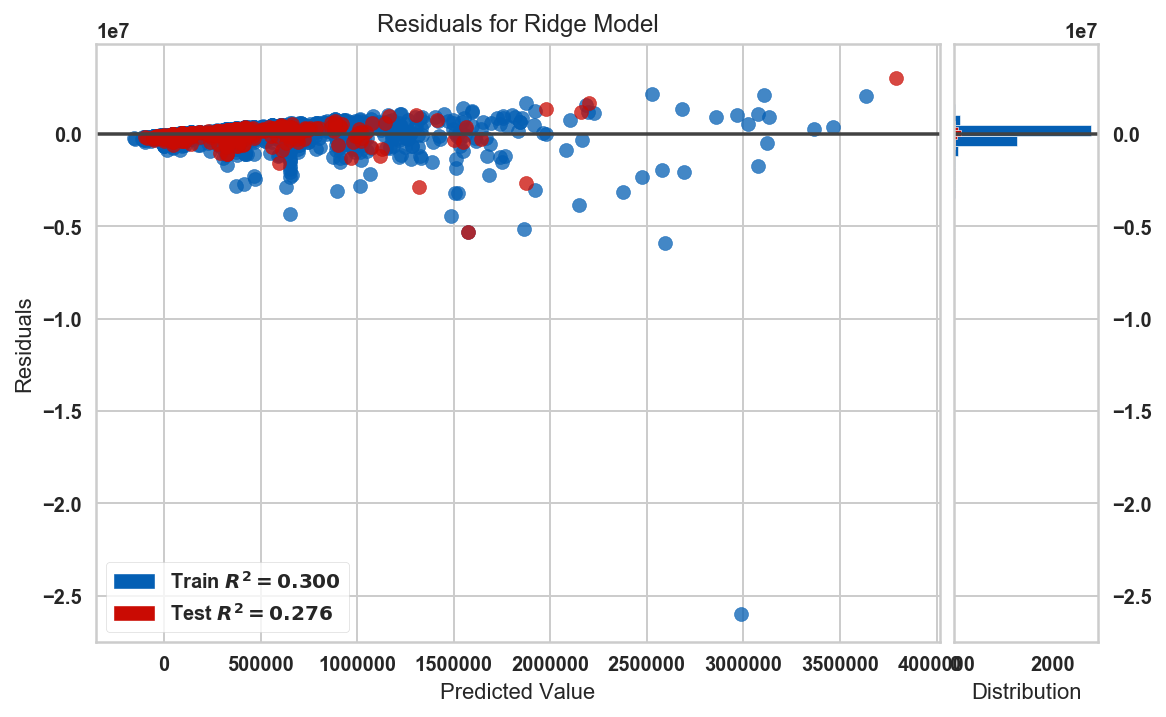

In [372]:
ridge = Ridge()
visualizer = ResidualsPlot(ridge, train_color='#045FB4', test_color='r', line_color='#424242')
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
g = visualizer.poof(outpath="residual_plot")

In [373]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [374]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[23:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [375]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 432454.421202


In [376]:
print(xg_reg.feature_importances_)

[0.13545294 0.0042644  0.22598974 0.18306813 0.07511662 0.229278
 0.03238082 0.01673653 0.01997994 0.07773286]


In [377]:
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  

In [378]:
from sklearn.model_selection import RandomizedSearchCV


In [379]:

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)  

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None, nthreads=-1,
                                          objective='reg:...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2da06e50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen 

In [384]:
predictions = gs.predict(X_test)

In [381]:
print(gs.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9569524610487814,
             gamma=7.6574117536778274, importance_type='gain',
             learning_rate=0.29655294080818545, max_delta_step=0, max_depth=5,
             min_child_weight=32.545838378982815, missing=None, n_estimators=13,
             n_jobs=1, nthread=None, nthreads=-1, objective='reg:linear',
             random_state=0, reg_alpha=84.52698691741695, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.9197263558032286, verbosity=1)


In [382]:
print(gs.best_score_)

0.4437402465950335


##### we can see here the score has been enhanced by using only the four features as predictors 'Type_estate_House','Plot', 'Bedrooms', 'Bathrooms'

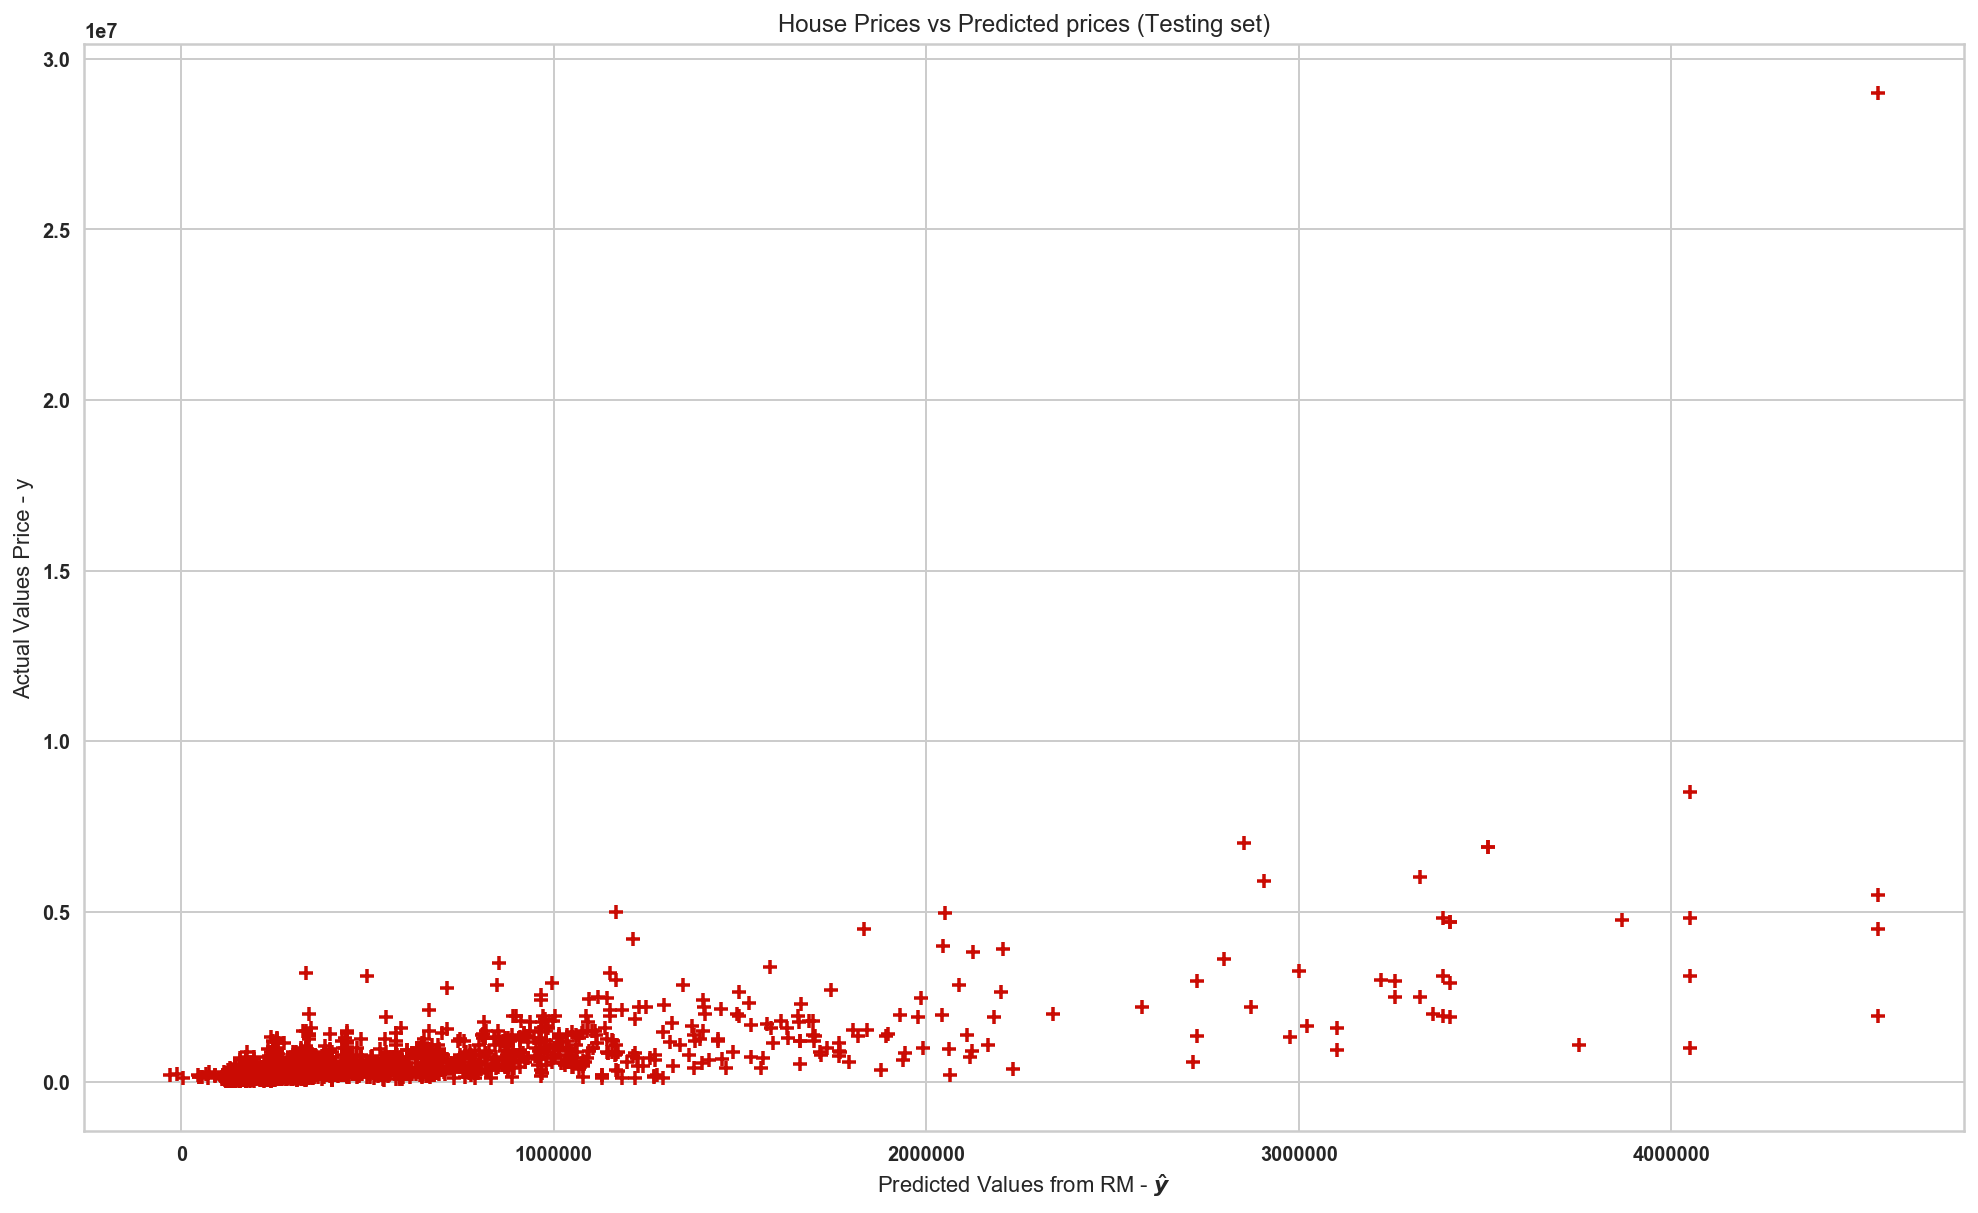

score:  0.46309849533488434


In [416]:
predictions  =  gs.predict(X)
score        =  gs.score(X, y)

# Plot the model
plt.figure(figsize=(15,10))
plt.scatter(predictions, y, s=50, c='r', marker='+', zorder=20)
plt.title("House Prices vs Predicted prices (Testing set)")
plt.xlabel("Predicted Values from RM - $\hat{y}$")
plt.ylabel("Actual Values Price - y")
plt.show()

print ("score: ", score)


In [400]:
print(gs.cv_results_)

{'mean_fit_time': array([0.20852574, 0.0518117 , 0.09168903, 0.01982935, 0.12462799,
       0.12417825, 0.16816465, 0.03148111, 0.09999053, 0.03490305]), 'std_fit_time': array([0.03797803, 0.00180308, 0.00427913, 0.00159966, 0.01797001,
       0.0126663 , 0.01124211, 0.00137533, 0.01467637, 0.00281933]), 'mean_score_time': array([0.00525856, 0.0022223 , 0.00399041, 0.00208529, 0.00478204,
       0.00398238, 0.00499272, 0.00223978, 0.00403428, 0.00221539]), 'std_score_time': array([1.14299767e-04, 1.24307951e-04, 6.10763099e-04, 1.24700641e-04,
       5.66631581e-04, 1.05561798e-04, 3.19454028e-04, 4.29331484e-05,
       5.57796796e-04, 1.85694965e-04]), 'param_colsample_bytree': masked_array(data=[0.969637401801236, 0.9868917379521758,
                   0.8997225460485935, 0.8666407608146213,
                   0.8270054678325114, 0.9968885585187652,
                   0.9895465787624744, 0.9264953091833678,
                   0.9902021413728689, 0.9569524610487814],
             mask

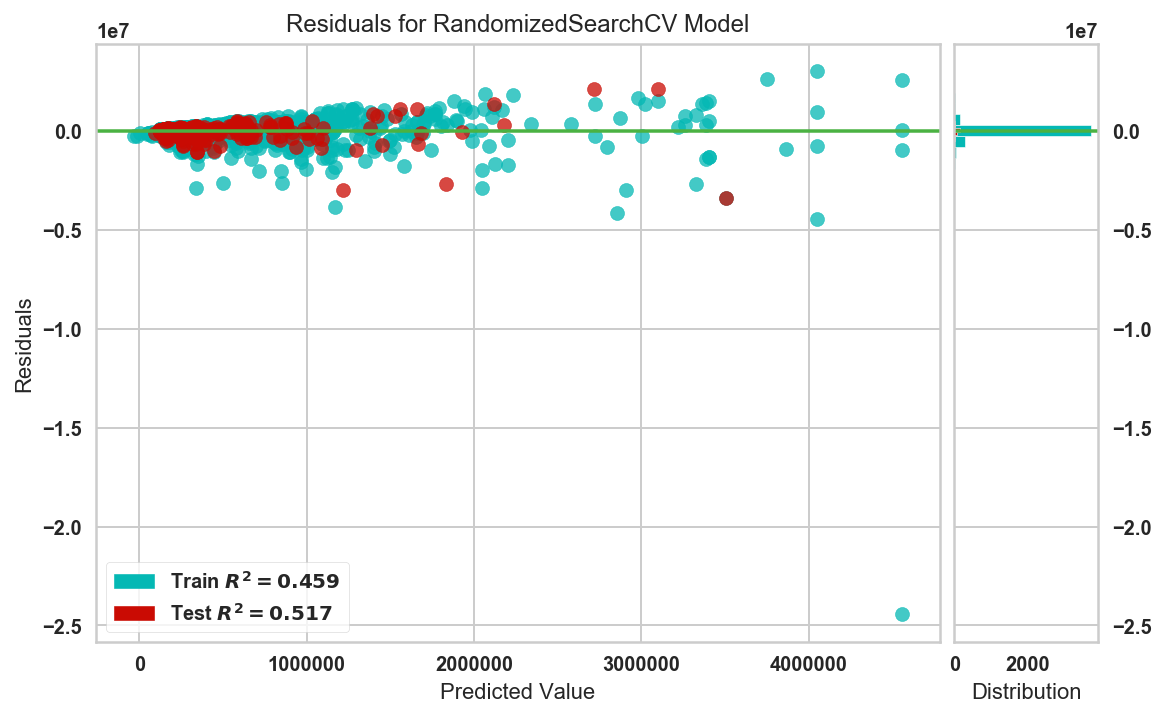

In [410]:

visualizer = ResidualsPlot(gs, train_color='#04B8B4', test_color='r', line_color='#4BB242')
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
g = visualizer.poof(outpath="residual_plot")

# Finally let's do the whole cycle again using only few features and with log(prices)


In [199]:
df_housesNEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4779 entries, 0 to 5720
Data columns (total 10 columns):
Type_estate     4779 non-null object
Price           4779 non-null float64
FLOORS          4779 non-null int64
Not_detached    4779 non-null int64
m2              4779 non-null float64
Plot            4779 non-null float64
Bedrooms        4779 non-null int64
Bathrooms       4779 non-null float64
Parking         4779 non-null int64
Garden          4779 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 570.7+ KB


In [417]:
y=np.log(df_housesNEW['Price'])

X=df_housesNEW.drop('Price', axis=1)

X=pd.get_dummies(X,drop_first=True)

In [418]:
X.head()

,FLOORS,Not_detached,m2,Plot,Bedrooms,Bathrooms,Parking,Garden,Type_estate_House,Type_estate_Villa
0,1,1,77.0,0.0,2,1.0,0,0,0,0
1,1,1,78.0,0.0,2,1.0,0,0,0,0
2,1,1,89.0,0.0,1,1.0,0,0,0,0
3,1,1,75.0,0.0,2,1.0,0,0,0,0
4,3,0,739.0,2000.0,5,7.0,0,0,1,0


In [420]:
y.head()

0    12.487485
1    12.762827
2    12.703813
3    12.899220
4    13.591116
Name: Price, dtype: float64

In [421]:
predictors = ['Type_estate_House','Plot', 'Bedrooms', 'Bathrooms']
#predictors = ['Plot', 'Bedrooms', 'Bathrooms']

X_train, X_test, y_train, y_test = train_test_split(X[predictors], y, 
                                            test_size=0.5, random_state=8)
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                            test_size=0.5, random_state=8)

lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

lr.score(X_test, y_test)

0.38699396485533166

In [422]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                    y, test_size=0.2, random_state=8)

lr1 = linear_model.LinearRegression()

lr1.fit(X_train,y_train)

lr1.score(X_test, y_test)

0.41540990684488144

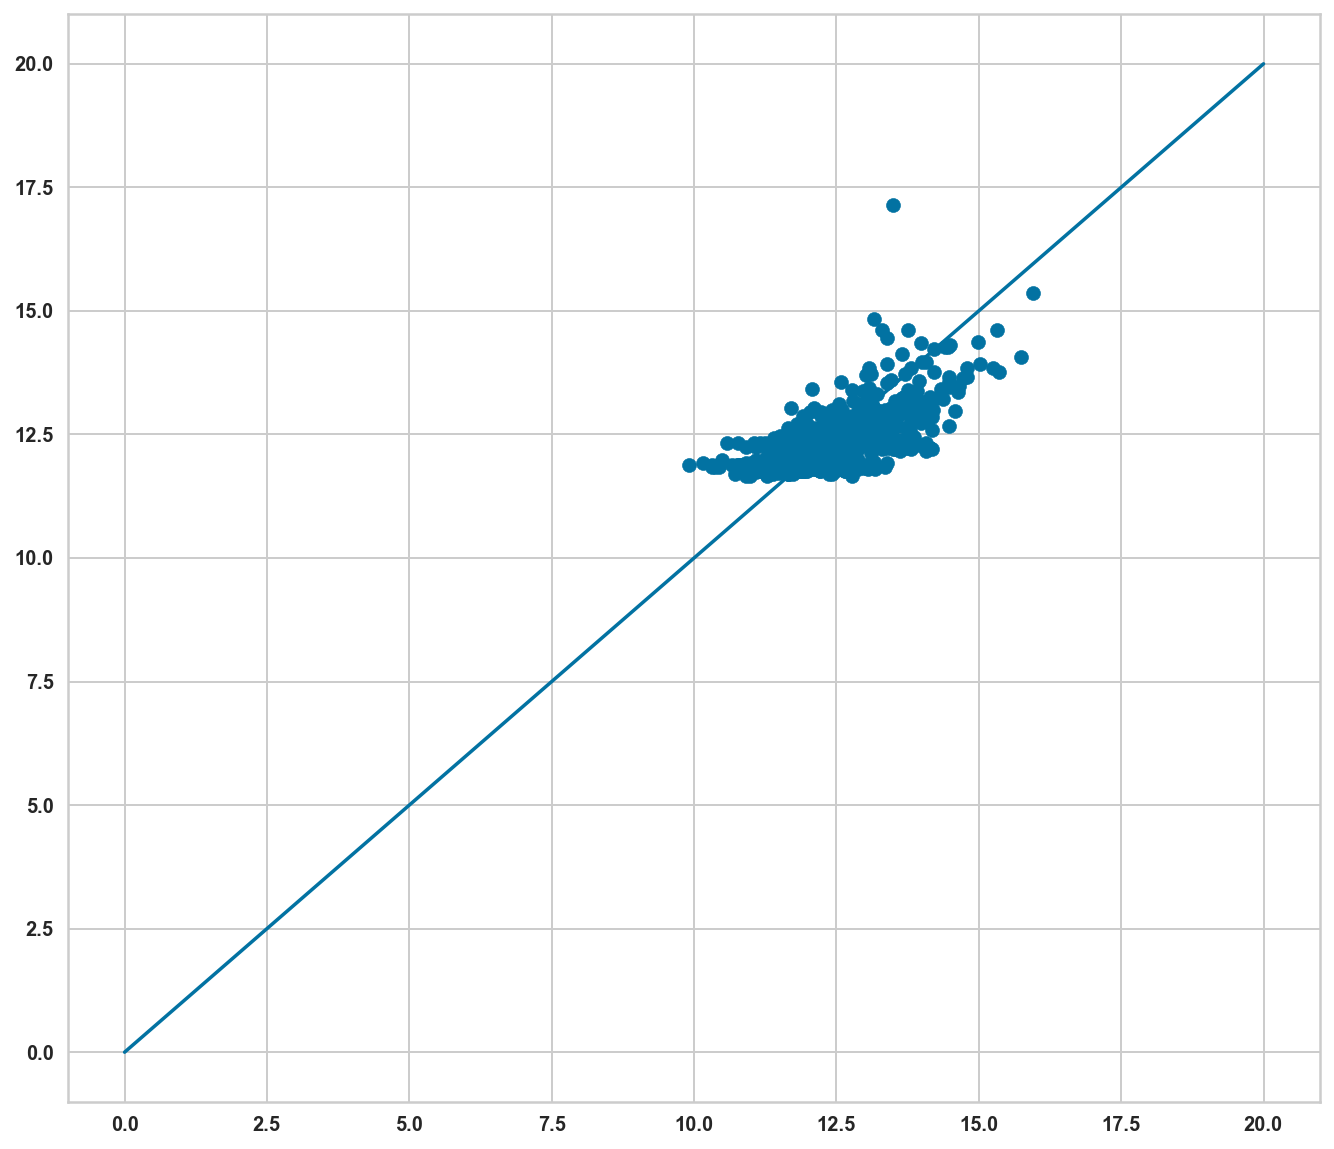

In [423]:
yhat = lr1.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat)
plt.plot([0,20],[0,20])
plt.show()

In [424]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                    y, test_size=0.1, random_state=8)

lr2 = linear_model.LinearRegression()

lr2.fit(X_train,y_train)

lr2.score(X_test, y_test)

0.3899340154433984

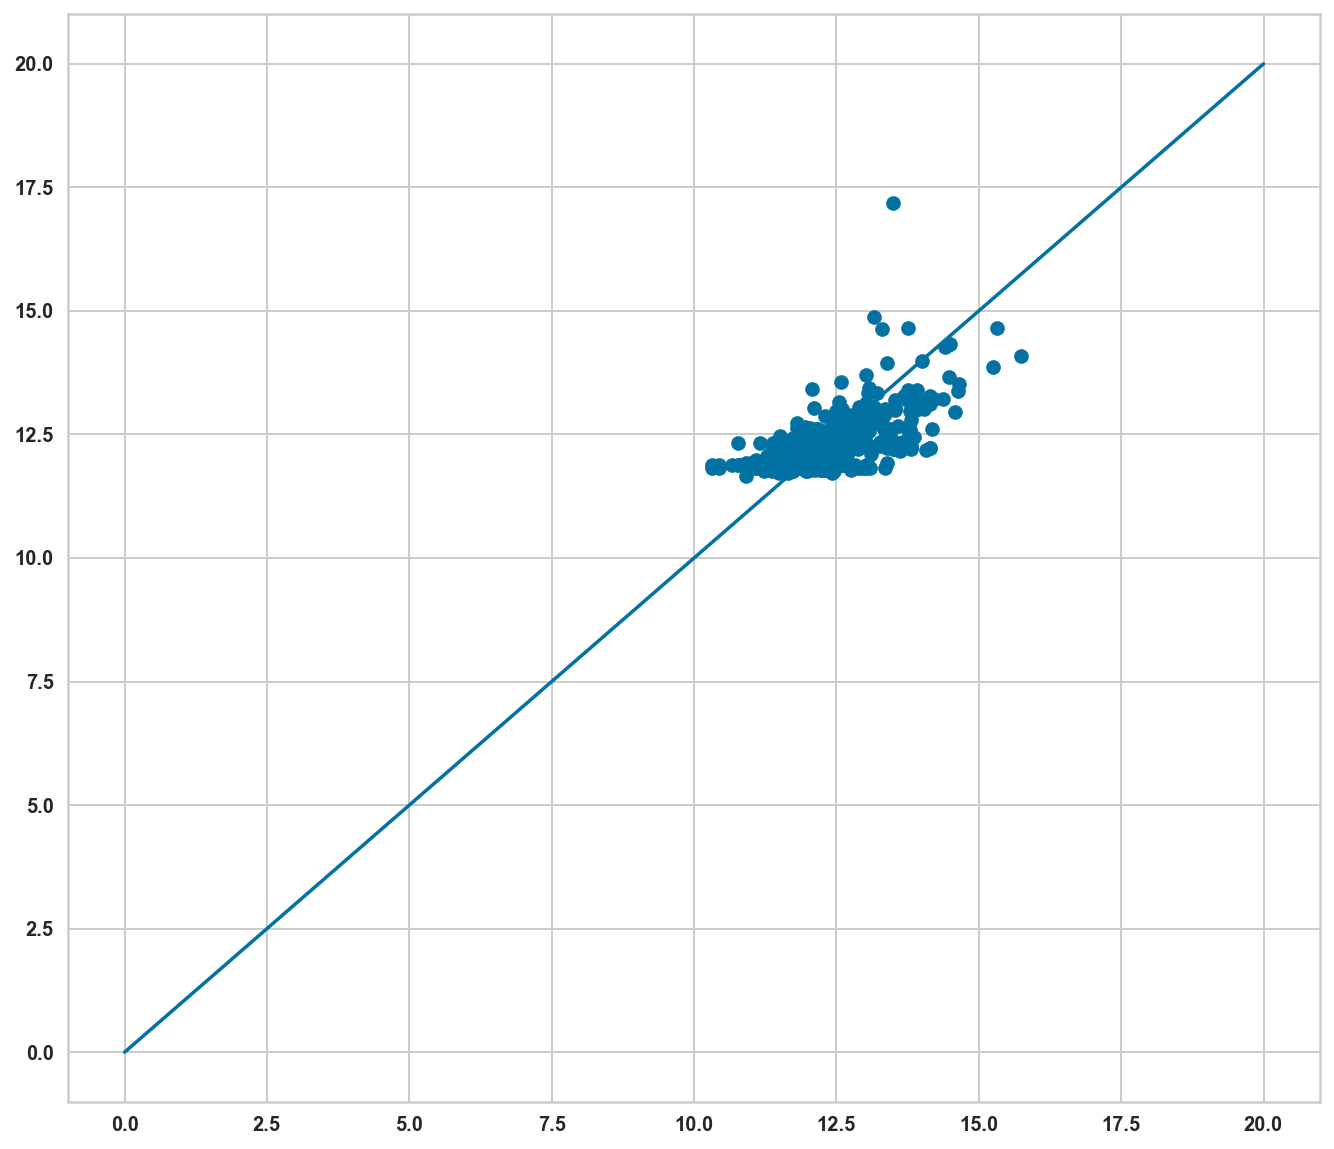

In [425]:
yhat = lr2.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat)
plt.plot([0,20],[0,20])
plt.show()

In [426]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics

In [427]:
# iterate through folds 5-10
for folds in range(5,11):
    
    kf = KFold(n_splits=folds,shuffle=True,random_state=1)
    
    print('------------------------------------\n')
    print('K:', folds)
    model = linear_model.LinearRegression()
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

------------------------------------

K: 5
Cross-validated scores: [0.38335378 0.42296596 0.39014863 0.35223758 0.41791574]
Mean CV R2: 0.39332433828578817
Std CV R2: 0.025616329386324292
------------------------------------

K: 6
Cross-validated scores: [0.38993904 0.42366822 0.38907516 0.40302339 0.31203435 0.42380909]
Mean CV R2: 0.39025820960038243
Std CV R2: 0.037694636257657614
------------------------------------

K: 7
Cross-validated scores: [0.37524932 0.40608207 0.4279789  0.39749655 0.44487965 0.22810851
 0.40853278]
Mean CV R2: 0.38404682430116105
Std CV R2: 0.0668589382738532
------------------------------------

K: 8
Cross-validated scores: [0.38847601 0.39815373 0.41617176 0.39803778 0.39603312 0.35285521
 0.38998622 0.40793923]
Mean CV R2: 0.3934566325963642
Std CV R2: 0.017538303551423405
------------------------------------

K: 9
Cross-validated scores: [0.37960266 0.40738699 0.43142536 0.37880793 0.40666367 0.40083166
 0.28877638 0.41861172 0.39042432]
Mean CV R2: 0.

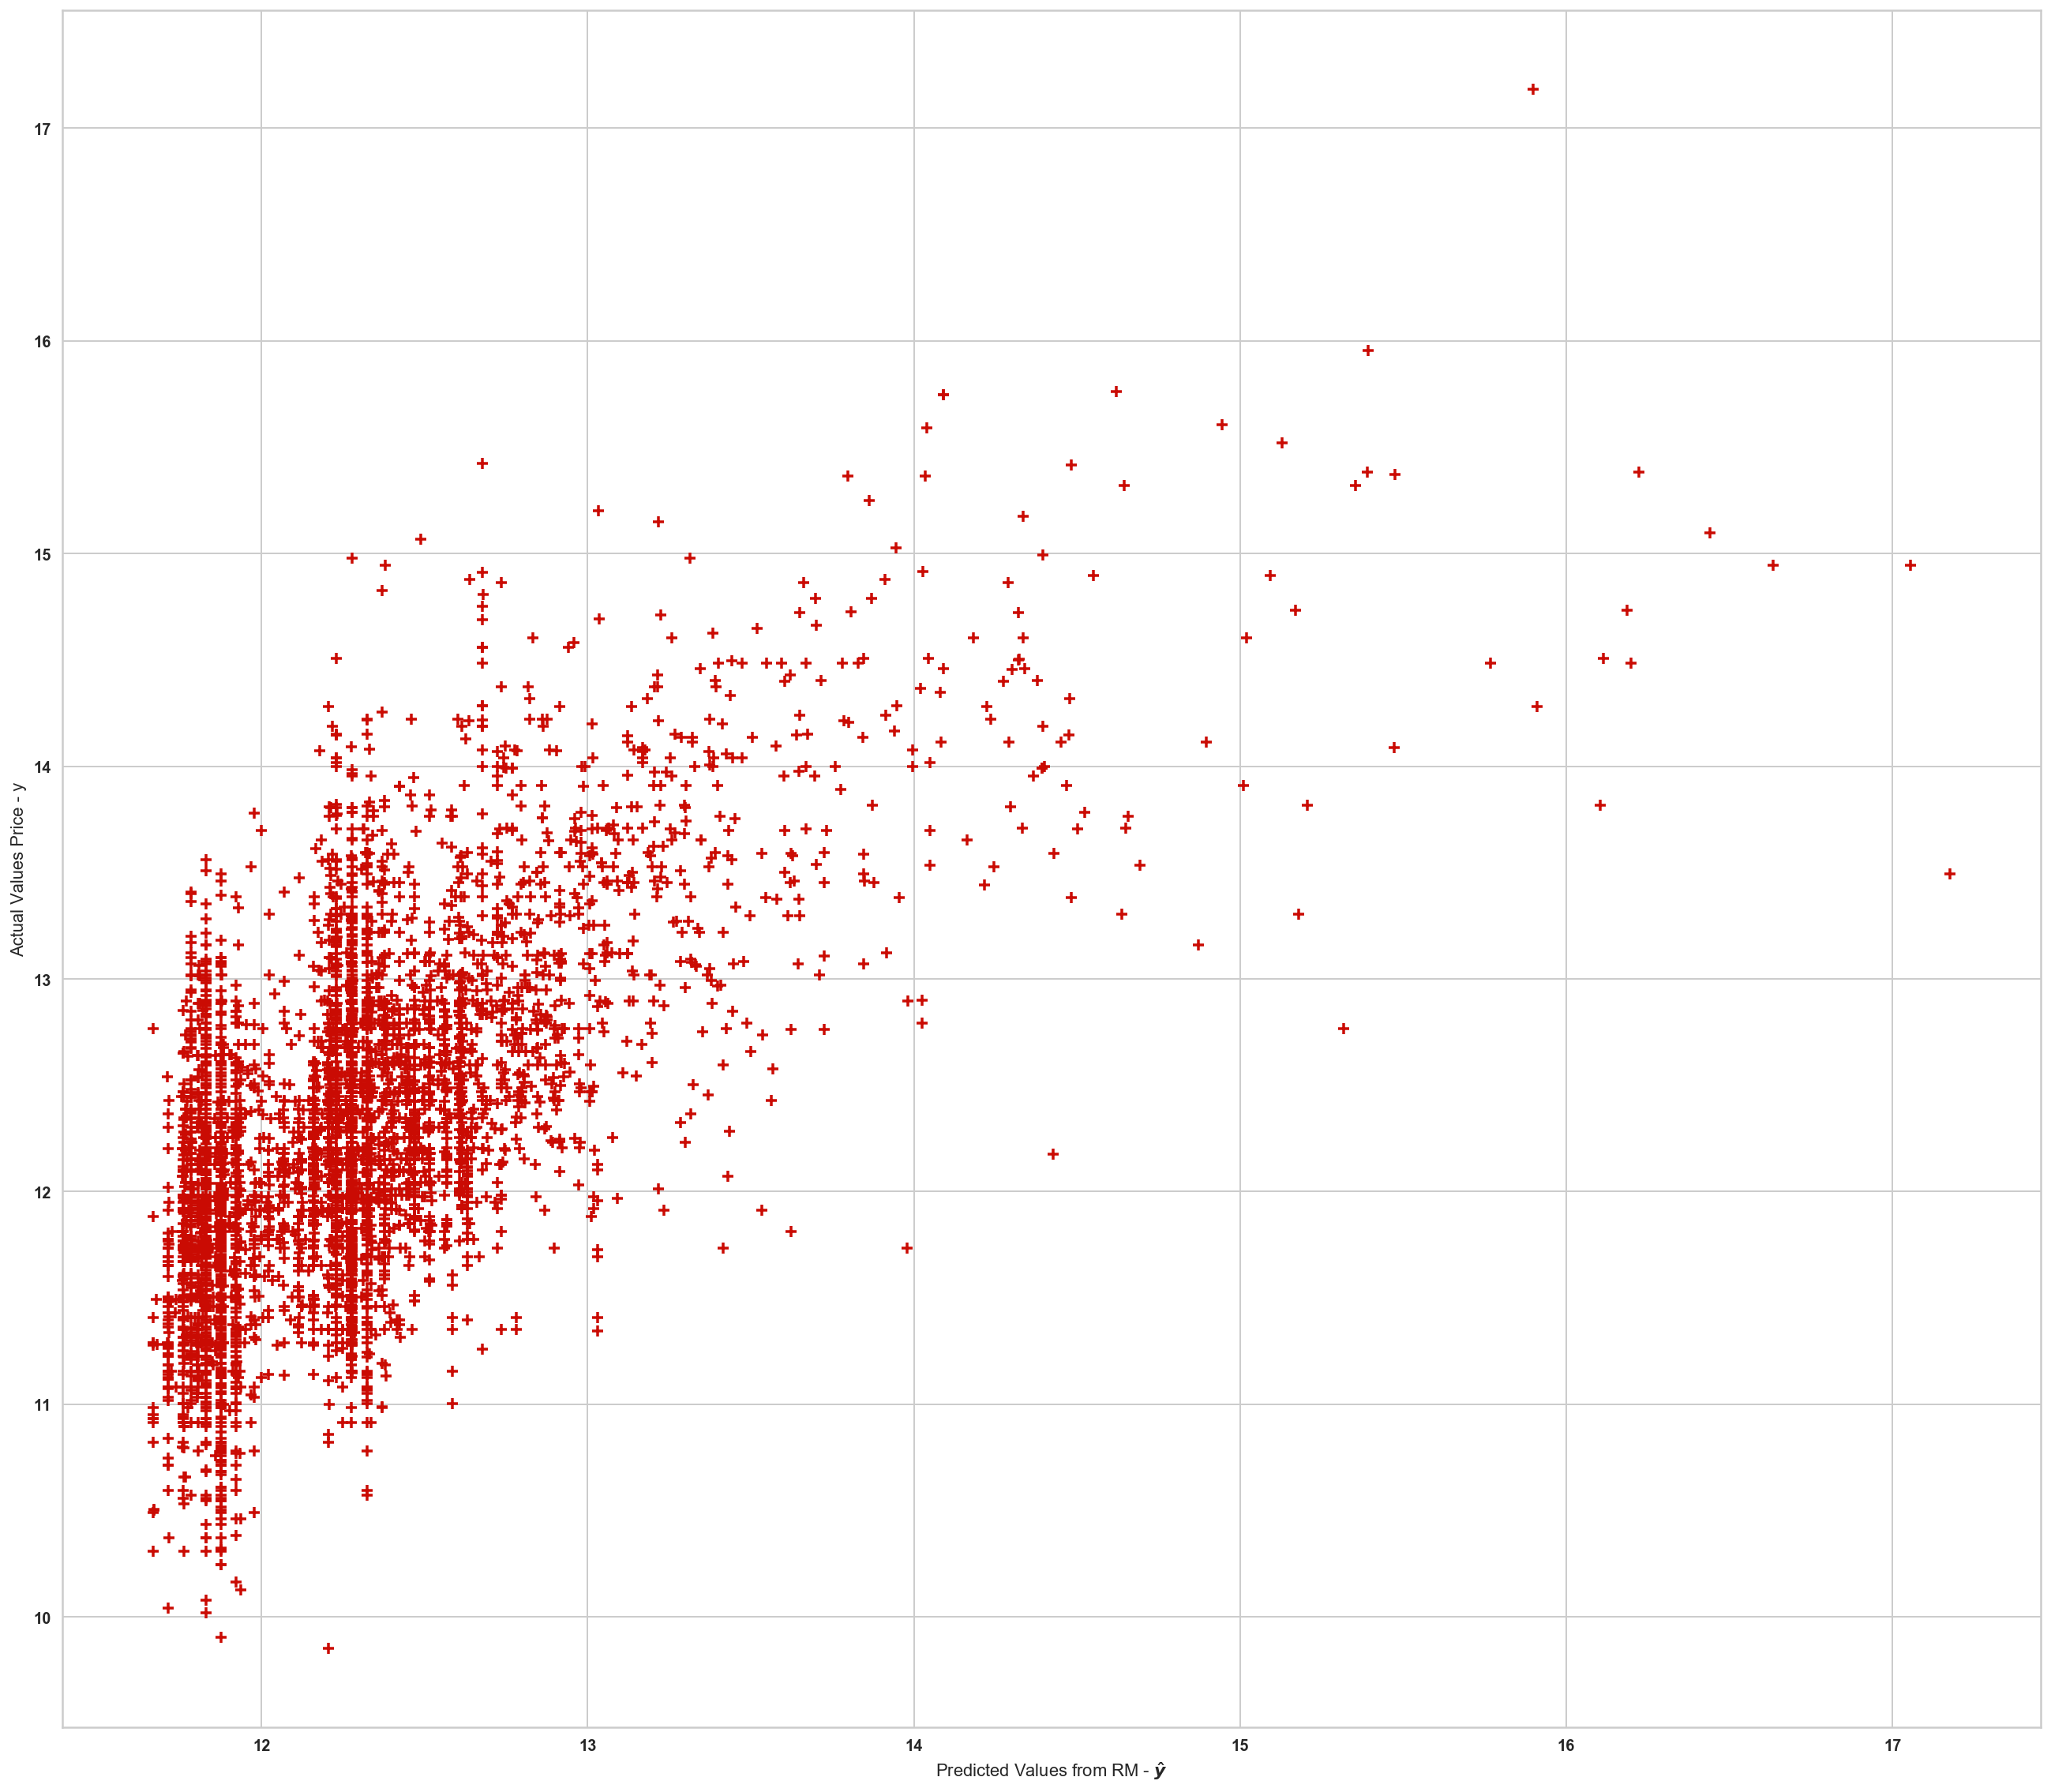

score:  0.4138191927082213


In [428]:
predictions  =  lr2.predict(X)
score        =  lr2.score(X, y)

# Plot the model
plt.figure(figsize=(20,20))
plt.scatter(predictions, y, s=50, c='r', marker='+', zorder=20)
plt.xlabel("Predicted Values from RM - $\hat{y}$")
plt.ylabel("Actual Values Price - y")
plt.show()

print ("score: ", score)

In [429]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = scaler.fit_transform(X)

# Standardization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are different sizes just because of the scale of predictor variables
# the regularization term can't determine which betas are more/less 
# important based on their size.

In [430]:
linreg = linear_model.LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[-0.00672907  0.34814051  0.05903392  0.16500245 -0.00173721 -0.18885854
 -0.11201598  0.38153344  0.50733607  0.20240183]
0.13541074138545217


In [431]:
predictions = cross_val_predict(linreg, Xs, y)
r2_score(y,predictions)

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.2000876879370378

In [432]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=2)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

121.7382727739662


In [433]:
optimal_ridge.score(Xs,y)

0.4136611394476197

In [434]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=2)

print(ridge_scores)
print(np.mean(ridge_scores))
predictions = cross_val_predict(ridge, Xs, y, cv=2)
print(r2_score(y,predictions))

[0.15756374 0.14763909]
0.15260141340411598
0.20798343891392312


In [435]:
# It's vastly better than the Linear Regression. 
# There is likely so much multicollinearity in the data that "vanilla" regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

In [436]:
# compare to ridge with optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(Xs,y)
print(ridge.score(Xs,y))

0.4136611394476197


In [437]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.026829841629325196


......................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


In [438]:
print(optimal_lasso.score(Xs,y))

0.4071755857614724


In [439]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))
predictions = cross_val_predict(lasso, Xs, y, cv=10)
print(r2_score(y,predictions))

[ 0.20779771  0.38678853  0.060241    0.16844883  0.00985385 -0.18248366
 -0.13627381  0.36208761  0.51252644  0.22934172]
0.16183282231409285
0.3687456391360414


In [440]:
# The lasso performs slightly better than the Ridge, but similarly.
# Lasso deals primarily with the feature selection of valuable variables,
# eliminating ones that are not useful. This also takes care of multicollinearity,
# but in a different way: it will choose the "best" of the correlated variables
# and zero-out the other redundant ones.
# There may also be useless variables in the data which it is simply getting rid
# of entirely.

In [441]:
# compare to Lasso with optimal alpha
lasso.fit(Xs,y)
print(lasso.score(Xs,y))

0.4071755857614724


In [442]:
lasso.fit(Xs, y)

Lasso(alpha=0.026829841629325196, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [443]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
5,Bathrooms,0.444862,0.444862
7,Garden,0.074610,0.074610
4,Bedrooms,0.048245,0.048245
3,Plot,0.028988,0.028988
6,Parking,0.006584,0.006584
0,FLOORS,0.000000,0.000000
1,Not_detached,-0.000000,0.000000
2,m2,0.000000,0.000000
8,Type_estate_House,-0.000000,0.000000
9,Type_estate_Villa,0.000000,0.000000


In [444]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.0010462439840970914


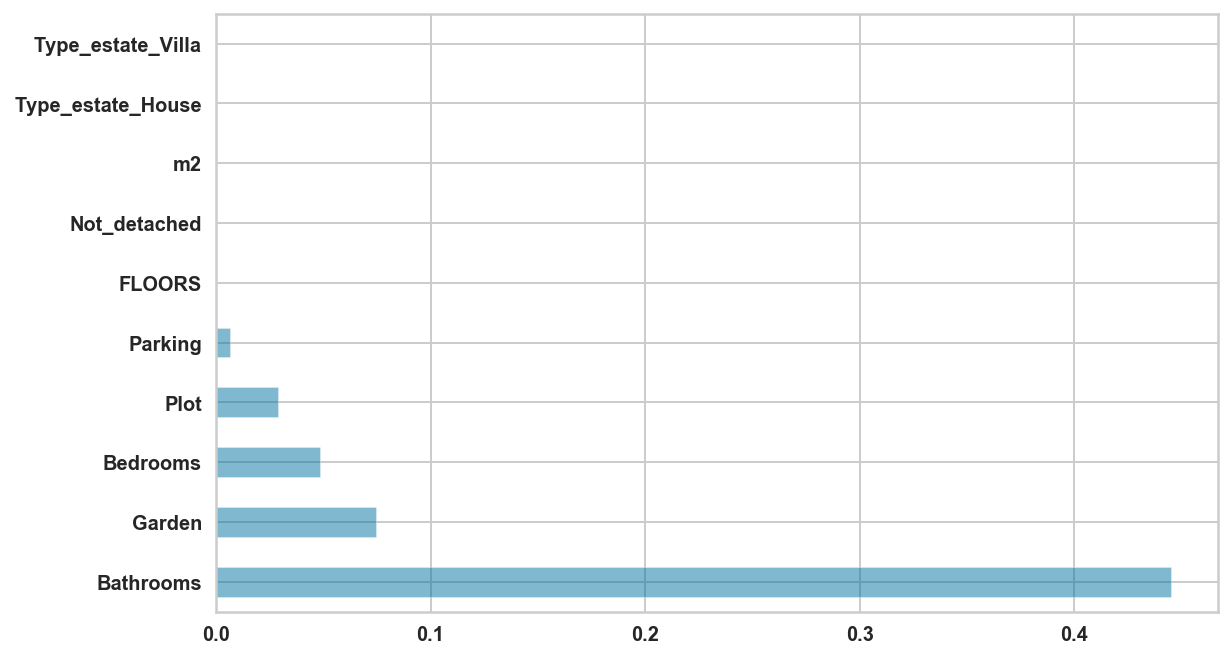

In [445]:
fig, ax = plt.subplots()
lasso_coefs.coef[:10].plot(kind='barh',ax=ax,alpha=0.5)
ax.set_yticklabels(lasso_coefs.variable[:10].values)
plt.show()

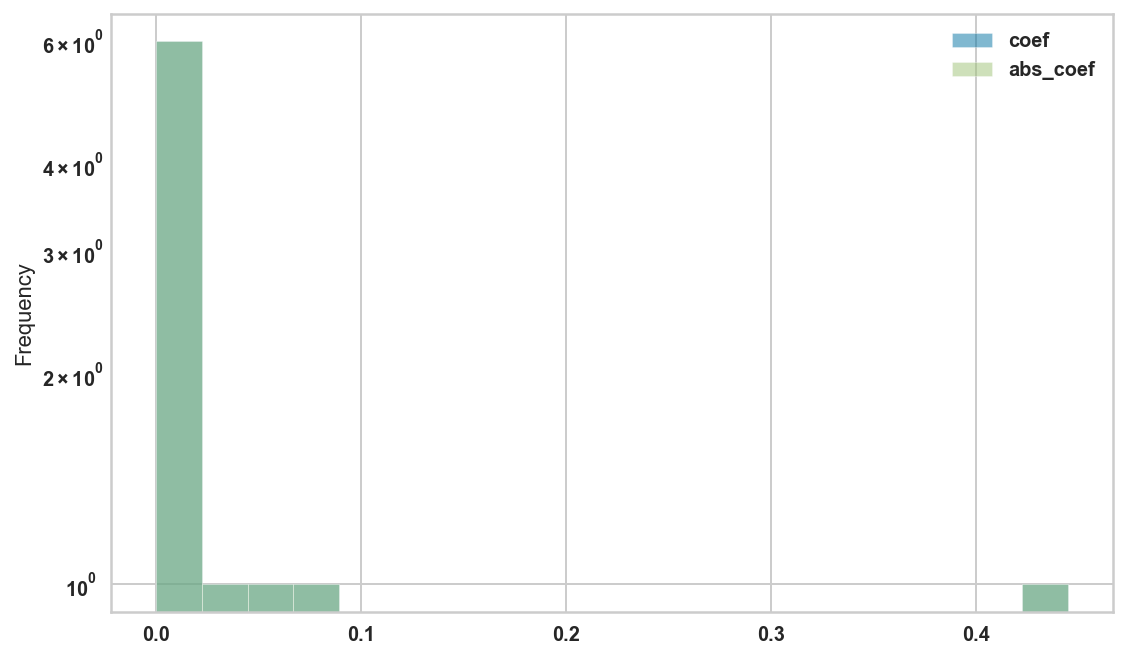

In [446]:
fig, ax = plt.subplots()
lasso_coefs.plot(kind='hist',bins=20,ax=ax,alpha=0.5)
ax.set_yscale('log')
plt.show()

In [447]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs, y)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.025832173706339192
1.0


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    7.8s finished


In [448]:
optimal_enet.score(Xs,y)

0.40743085359282316

In [449]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y, cv=10)

print(enet_scores)
print(np.mean(enet_scores))
predictions = cross_val_predict(enet,Xs,y,cv=10)
print(r2_score(y,predictions))

[ 0.20696328  0.38666709  0.06034448  0.16800502  0.00984185 -0.1830312
 -0.13527685  0.36276675  0.5129302   0.22920688]
0.16184174970541823
0.36873967883799885


In [450]:
# compare to elastic net with optimal alpha and l1_ratio
enet.fit(Xs,y)
print(enet.score(Xs,y))

0.40743085359282316


In [451]:
# Need to fit the ElasticNet and Ridge outside of cross_val_score like done with the ridge
ridge.fit(Xs, y)
lasso.fit(Xs, y)

Lasso(alpha=0.026829841629325196, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [452]:
# model residuals:

ridge_resid = y - ridge.predict(Xs)
lasso_resid = y - lasso.predict(Xs)


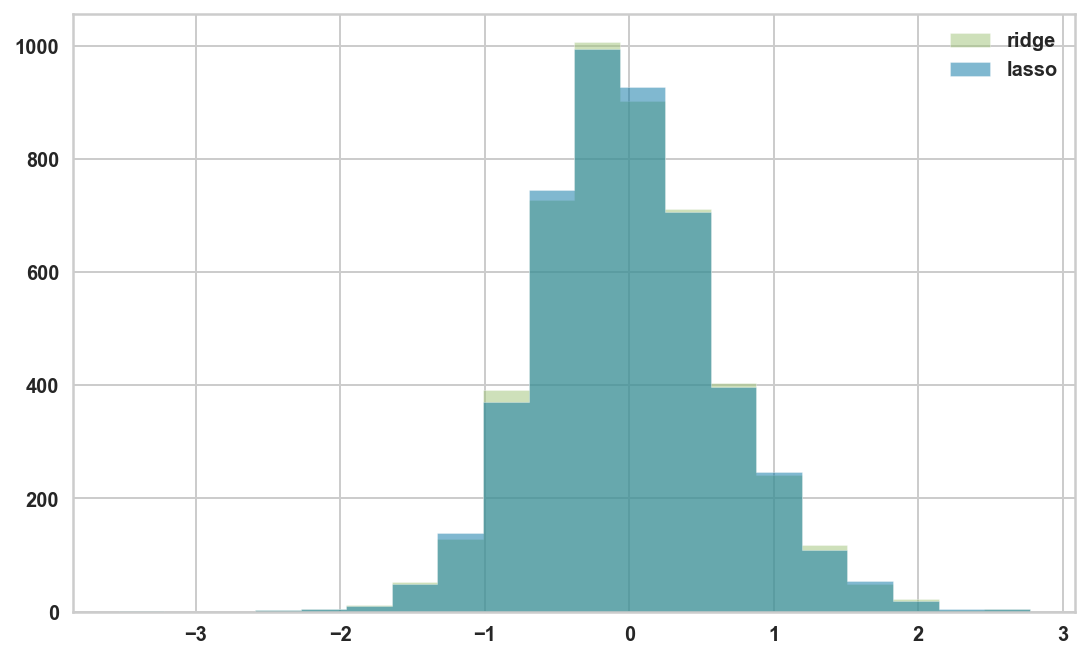

In [453]:
plt.hist([ridge_resid,lasso_resid],bins=20,histtype='stepfilled',alpha=0.5)
plt.legend(['ridge','lasso']);

In [454]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import Ridge
from yellowbrick.regressor import PredictionError, ResidualsPlot

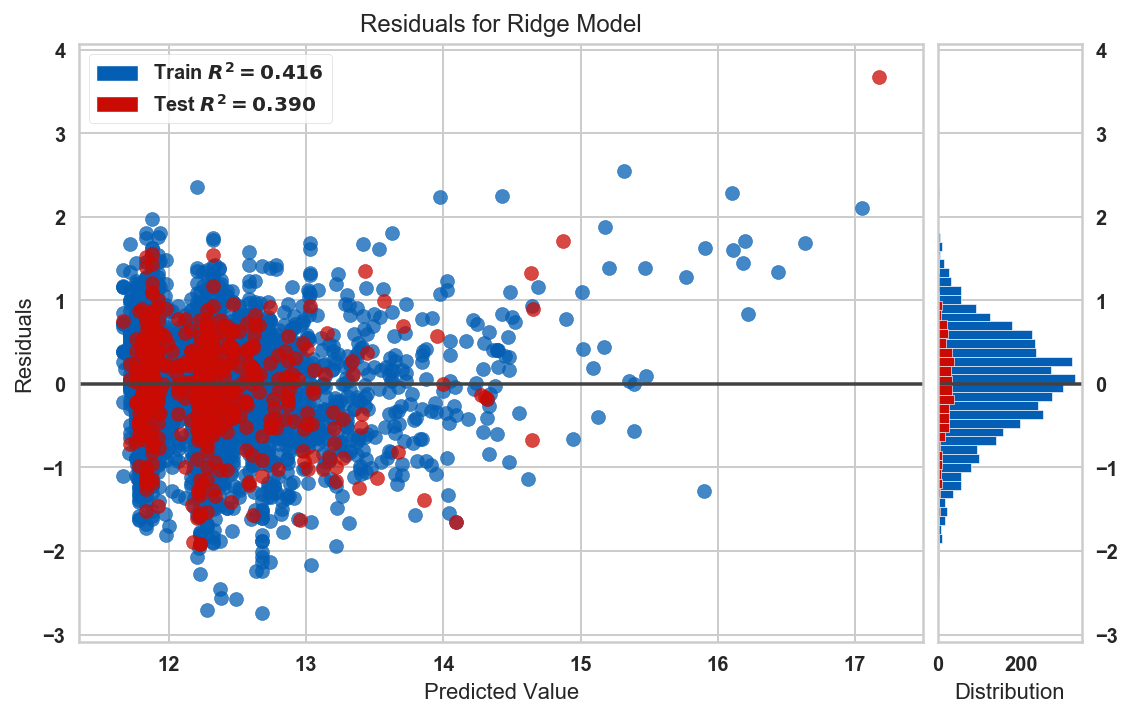

In [455]:
ridge = Ridge()
visualizer = ResidualsPlot(ridge, train_color='#045FB4', test_color='r', line_color='#424242')
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
g = visualizer.poof(outpath="residual_plot")

In [456]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [457]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[00:17:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [458]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 4.225158


In [486]:
mse = mean_squared_error(y_test, preds)
print("MSE: %f" % (mse))

MSE: 17.851962


In [459]:
print(xg_reg.feature_importances_)

[0.19630115 0.         0.3032428  0.         0.13869329 0.3087984
 0.         0.05296437 0.         0.        ]


In [485]:
X.head()

,FLOORS,Not_detached,m2,Plot,Bedrooms,Bathrooms,Parking,Garden,Type_estate_House,Type_estate_Villa
0,1,1,77.0,0.0,2,1.0,0,0,0,0
1,1,1,78.0,0.0,2,1.0,0,0,0,0
2,1,1,89.0,0.0,1,1.0,0,0,0,0
3,1,1,75.0,0.0,2,1.0,0,0,0,0
4,3,0,739.0,2000.0,5,7.0,0,0,1,0


In [479]:
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  

In [480]:
from sklearn.model_selection import RandomizedSearchCV


In [481]:

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)  

/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is depre

[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mamer/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None, nthreads=-1,
                                          objective='reg:...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2c28eb50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen 

In [482]:
predictions = gs.predict(X_test)

In [483]:
print(gs.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.954027314609628,
             gamma=6.738466420808918, importance_type='gain',
             learning_rate=0.2953185403224953, max_delta_step=0, max_depth=37,
             min_child_weight=1.3122119725758365, missing=None, n_estimators=14,
             n_jobs=1, nthread=None, nthreads=-1, objective='reg:linear',
             random_state=0, reg_alpha=3.32253267127228, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.9711619456128201, verbosity=1)


In [484]:
print(gs.best_score_)

0.4973384601928343


##### we can see here the score has been enhanced by using only the four features as predictors 'Type_estate_House','Plot', 'Bedrooms', 'Bathrooms'

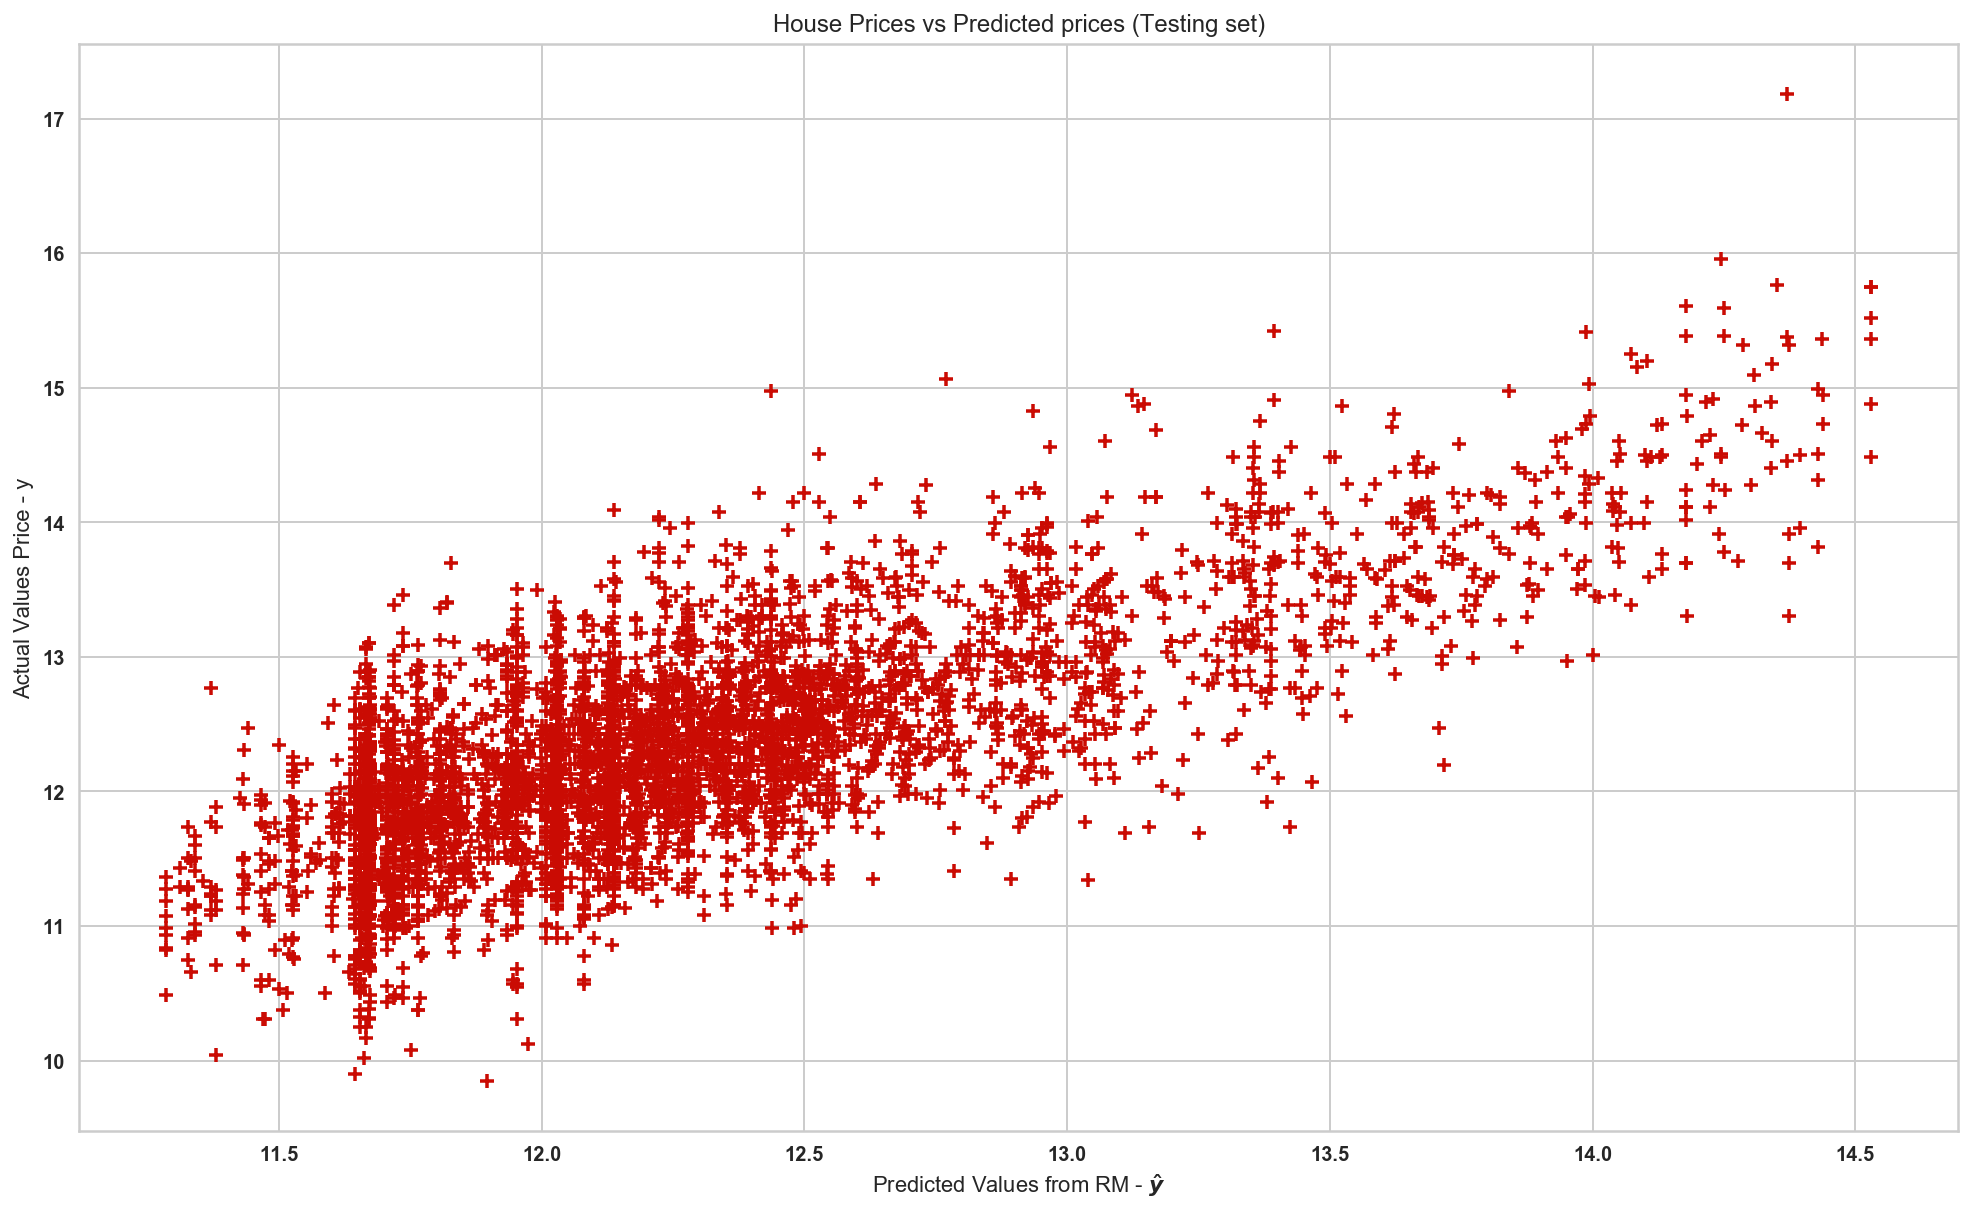

score:  0.5476510270480306


In [466]:
predictions  =  gs.predict(X)
score        =  gs.score(X, y)

# Plot the model
plt.figure(figsize=(15,10))
plt.scatter(predictions, y, s=50, c='r', marker='+', zorder=20)
plt.title("House Prices vs Predicted prices (Testing set)")
plt.xlabel("Predicted Values from RM - $\hat{y}$")
plt.ylabel("Actual Values Price - y")
plt.show()

print ("score: ", score)


In [467]:
print(gs.cv_results_)

{'mean_fit_time': array([0.03607631, 0.02090669, 0.06566278, 0.02816407, 0.05151248,
       0.08200836, 0.07382091, 0.03563722, 0.01750096, 0.09606751]), 'std_fit_time': array([0.01422265, 0.00731752, 0.01029866, 0.00819058, 0.01013757,
       0.00559229, 0.00792677, 0.00813784, 0.00258391, 0.02648039]), 'mean_score_time': array([0.00205668, 0.00258621, 0.00356309, 0.00247359, 0.00239913,
       0.00354234, 0.00267474, 0.00206073, 0.00221666, 0.0024391 ]), 'std_score_time': array([0.00035117, 0.0001663 , 0.00222266, 0.00040245, 0.00057108,
       0.00122807, 0.00043442, 0.00036105, 0.0005775 , 0.00076081]), 'param_colsample_bytree': masked_array(data=[0.9997033584645864, 0.9376712620943956,
                   0.9064983836872726, 0.965063687131882,
                   0.9245247281463048, 0.9319302091865859,
                   0.754151349050332, 0.9551956328193546,
                   0.9640628122465811, 0.9564073428666953],
             mask=[False, False, False, False, False, False, Fals

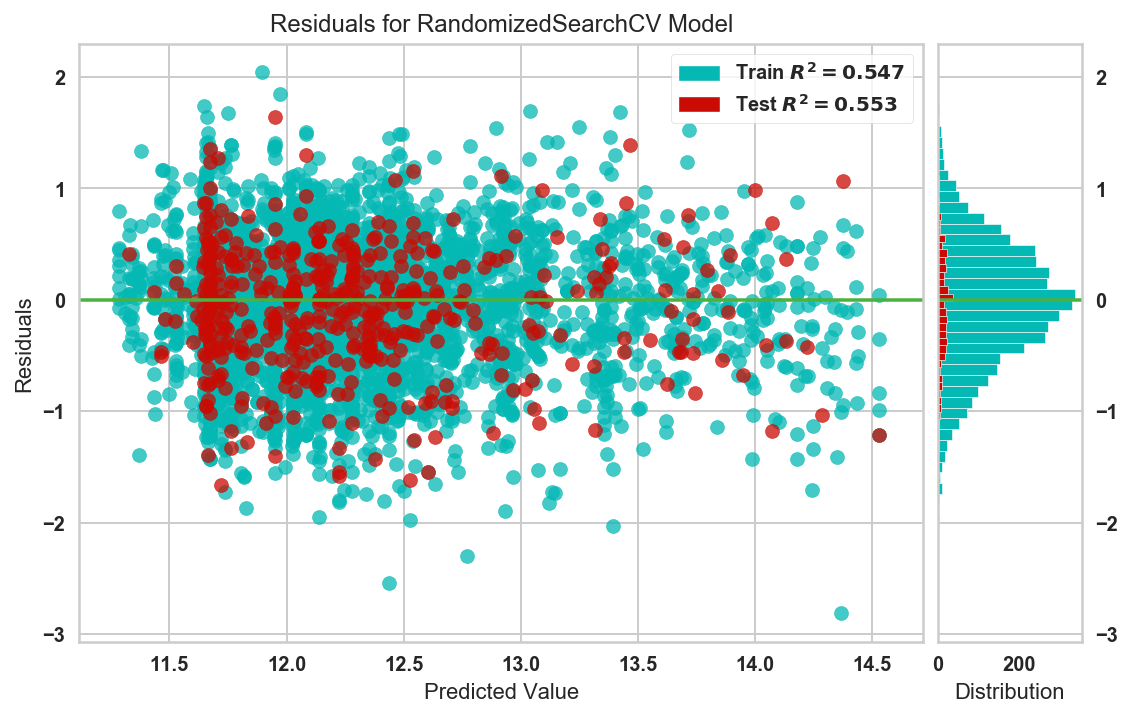

In [468]:

visualizer = ResidualsPlot(gs, train_color='#04B8B4', test_color='r', line_color='#4BB242')
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
g = visualizer.poof(outpath="residual_plot")

## It can been seen from the above score that by using the logarithic transformation for the porices we've gort a final better score of 54.8% with only four features that are important predictors

In [ ]:
booster=gblinear